# Text classification task: Bag of Words Approach Comparison
Comparing performances of TF-IDF and simple word-count, testing different feature dimensionalities and different classifiers

## TL;DR

- A good feature range for the TF-IDF seems to be max_features = 5000 (above this threshold the classification results do not vary significantly
- A good feature range for the simple word-count seems to be max_features = 5000  (same consideration as above)
- The Random Forest Classifier parameters have been tuned with a RandomSearchCV, but the obtained "best_params" does not perform better than the default ones. Therefore, the default ones will be used in the successive classifications (time-saving) 


## Packages

In [1]:
#---- magic trio + special guest
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#---- utils
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from pprint import pprint 
from sklearn.model_selection import RandomizedSearchCV# Number of trees in random forest
import time

In [10]:
df = pd.read_pickle("../data/df_preprocessed_eng.pckle")

df.head()

description      event_id  \
0  <p><span>Hey explorersssss, what's up?</span><...     239719250   
1  <p>Free, unauditioned, collaborative pop choir...  gpjktmywhbnb   
2  <p>We provide a forum to learn about, promote ...  drrtzmywhbgb   
3  <p><b>【WhyNot!?JAPAN + MeetUp Collaboration Ev...     239719229   
4  <p>This is an introductory meeting to get to k...  mtzxwmywjbjb   

                   category  category_label     lang lang_reliab  \
0  language/ethnic identity              15  English          99   
1                     music              18  English          99   
2           career/business               3  English          98   
3               socializing              27  English          92   
4                      tech              30  English          99   

                                          desc_stemm  \
0  secret spot hong kong night view food adventur...   
1  sing us free unaudit collabor pop choir identi...   
2  east valley busi network meetup provid forum l...   
3  friendli friday whynot japan meetup collabor e...   
4  authent option introductori meet get know fell...   

                                           desc_lemm  \
0  secret spot hong kong night view food adventur...   
1  sing u free unauditioned collaborative pop cho...   
2  east valley business network meetup provide fo...   
3  friendly friday whynot japan meetup collaborat...   
4  authentication option introductory meet get kn...   

                              desc_stemm_no_badwords  \
0  secret spot hong kong night view food adventur...   
1  sing us unaudit collabor pop choir identifi wo...   
2  east valley busi network provid forum learn pr...   
3  friendli whynot japan collabor whynot japan si...   
4  authent option introductori get fellow coder s...   

                               desc_lemm_no_badwords  \
0  secret spot hong kong night view food adventur...   
1  sing u unauditioned collaborative pop choir id...   
2  east valley business network provide forum lea...   
3  friendly whynot japan collaboration whynot jap...   
4  authentication option introductory get fellow ...   

             remap_category  remap_category_label  
0  language/ethnic identity                    11  
1                     music                    13  
2           career/business                     1  
3               socializing                    20  
4                      tech                    22

# Text representation 

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(df.category)


def run_experiment(X_data, y_data, 
                   mode = "tfidf", classifier = "rf", 
                   tf_idf_features = None, max_features = 10000, ngram_range = (1,1),
                   count_vect_features = None,
                   random_search = False, param_grid = None, params = None,
                   verbose = False, get_exec_time = False, n_jobs = 35,
                   print_classification_report= False, show_confusion_matrix= False, le = None):
    
    t0 = time.time()
    if mode == "tfidf":
        
        if tf_idf_features is None:
            
            tf_vectorizer = TfidfVectorizer(analyzer = "word", tokenizer = None, norm = 'l1',ngram_range = ngram_range,
                                        preprocessor = None, max_features = max_features, sublinear_tf = True)
            if verbose:
                print("extracting tf-idf features...")
            X_data = tf_vectorizer.fit_transform(X_data)
            
        else:
        
            if verbose:
                print("using previously extracted tf-idf features")
            X_data = tf_idf_features
        if verbose:
            print("tf-idf features shape:", end="\t")
            print(X_data.shape)

    elif mode == "count":
        
        if count_vect_features is None:
            if verbose:
                print("extracting count-resulting features...")

            count_vect = CountVectorizer(max_features = max_features, analyzer = 'word', ngram_range = ngram_range)
            X_data = count_vect.fit_transform(X_data)
        else:
            if verbose:
                print("using previously extracted count-vect features")
            X_data = count_vect_features
        
        if verbose:
            print("count-vect features shape:", end="\t")
            print(X_data.shape)

    else:
        raise NotImplementedError
        
    X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size = 0.2, random_state = 42, stratify = y_data)
    
    if classifier == "rf":
        if verbose:
            print("Classifying with Random Forest...")
        if random_search:
            if verbose:
                print("Init RandomizedSearchCV...")
            rf = RandomForestClassifier(n_jobs=22)
            model = RandomizedSearchCV(estimator = rf, param_distributions = param_grid, n_iter = 20, cv = 3, verbose=10, random_state=42, n_jobs = 2)
        else:
            if params is not None:
                print("Using best params previously found")
                model = RandomForestClassifier(**params, n_jobs=n_jobs, verbose = 1)
            else:
                model = RandomForestClassifier(n_jobs=n_jobs, verbose = 1) 
    
        
    else:
        raise NotImplementedError
    if verbose:
        print(model)
        print("Starting to fit")
    model = model.fit(X_train, y_train)
    if verbose:
        print("Scoring")
    score = model.score(X_test, y_test)#100 est
    if verbose:
        print("Test score:", end="\t")
        print(score)
    
    
    if print_classification_report:
        names = le.inverse_transform(np.unique(y_test)) #remember to fix in case of remapping/not_remapping
        y_pred = model.predict(X_test)
        print(classification_report(y_test, y_pred, target_names=names, digits = 3))  
    if show_confusion_matrix:
        names = le.inverse_transform(np.unique(y_test)) #remember to fix in case of remapping/not_remapping
        print("recall-way confusion matrix")
        plt.figure(figsize = (20,20))
        sns.heatmap(np.round(confusion_matrix(y_test, y_pred, normalize = "pred"),2), cmap = "YlGnBu", annot=True, square=True, linewidths=.2, linecolor="black", xticklabels=list(names), yticklabels=list(names))
        plt.show()
        print("precision-way confusion matrix")
        plt.figure(figsize = (20,20))
        sns.heatmap(np.round(confusion_matrix(y_test, y_pred, normalize = "true"), 2), cmap = "YlGnBu", annot=True, square=True, linewidths=.2, linecolor="black", xticklabels=list(names), yticklabels=list(names))
        plt.show()
    if get_exec_time:
        print(f"Experiment run in {round(time.time()-t0, 2)}s")
    return model, score

## TF-IDF feature extraction 

based on the previous results, max_features = 5000 in tf-idf vectorizer

stemm vs lemm vs stemm_no_badwords vs lemm_no_badwords

extracting tf-idf features...
tf-idf features shape:	(120809, 5000)
Classifying with Random Forest...
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=35, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)
Starting to fit


[Parallel(n_jobs=35)]: Using backend ThreadingBackend with 35 concurrent workers.
[Parallel(n_jobs=35)]: Done 100 out of 100 | elapsed:  1.0min finished
[Parallel(n_jobs=35)]: Using backend ThreadingBackend with 35 concurrent workers.


Scoring


[Parallel(n_jobs=35)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=35)]: Using backend ThreadingBackend with 35 concurrent workers.


Test score:	0.6734127969538946


[Parallel(n_jobs=35)]: Done 100 out of 100 | elapsed:    0.3s finished


                          precision    recall  f1-score   support

                    LGBT      0.909     0.244     0.385       205
   alternative lifestyle      0.963     0.706     0.815       109
              book clubs      0.546     0.446     0.491       186
         career/business      0.695     0.776     0.733      2214
        cars/motorcycles      0.846     0.433     0.572       178
   community/environment      0.728     0.281     0.405       449
                 dancing      0.750     0.829     0.787       643
      education/learning      0.787     0.312     0.447       461
          fashion/beauty      0.556     0.106     0.179        47
       fine arts/culture      0.702     0.495     0.581       537
                 fitness      0.791     0.747     0.768      1286
              food/drink      0.647     0.425     0.513       684
                   games      0.751     0.857     0.800       790
        health/wellbeing      0.683     0.771     0.724      2371
         

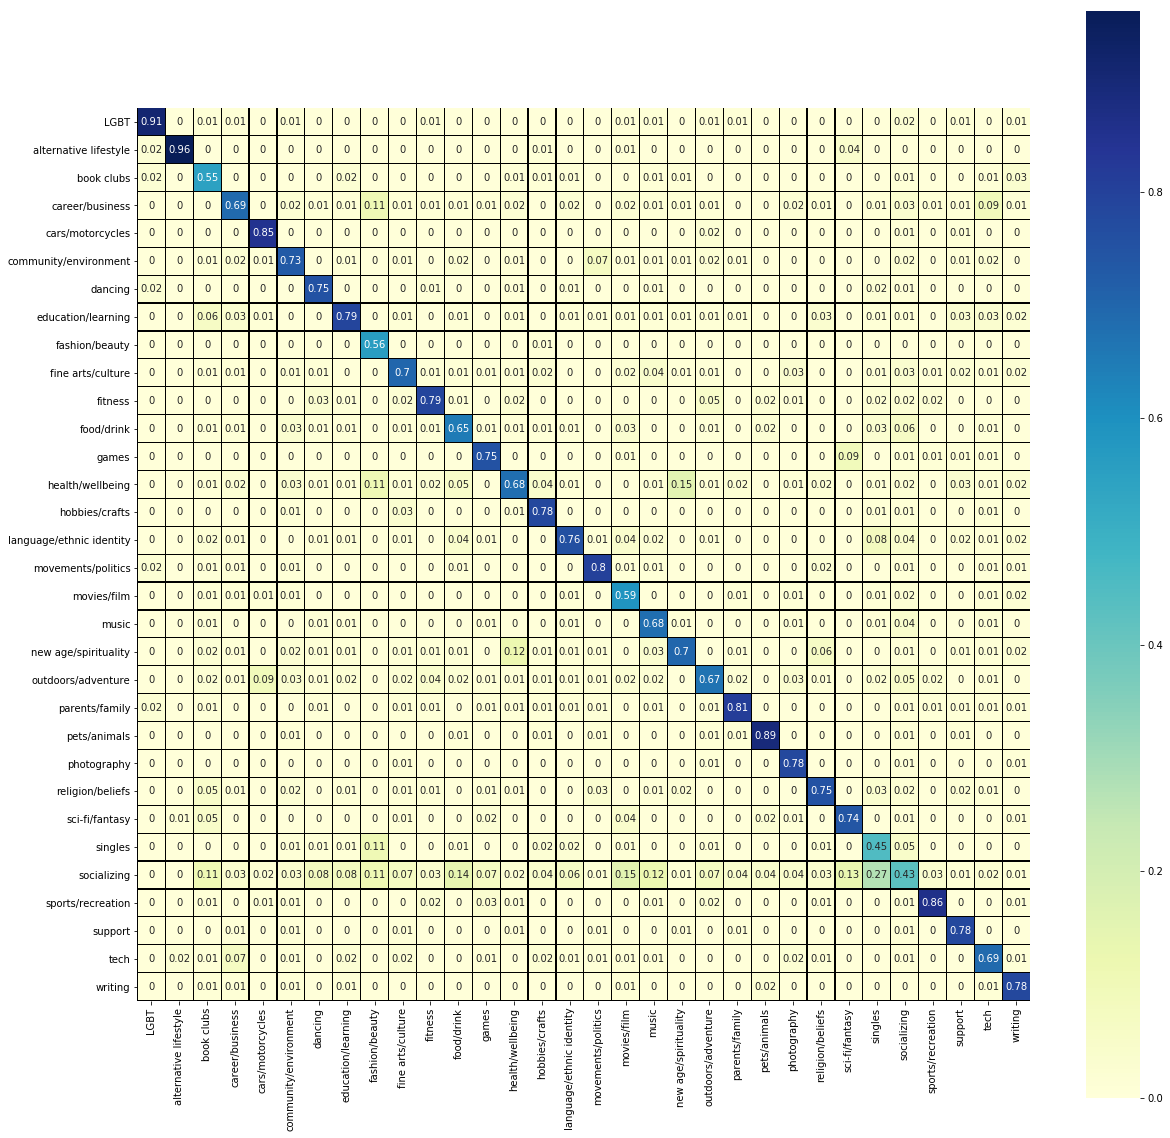

precision-way confusion matrix


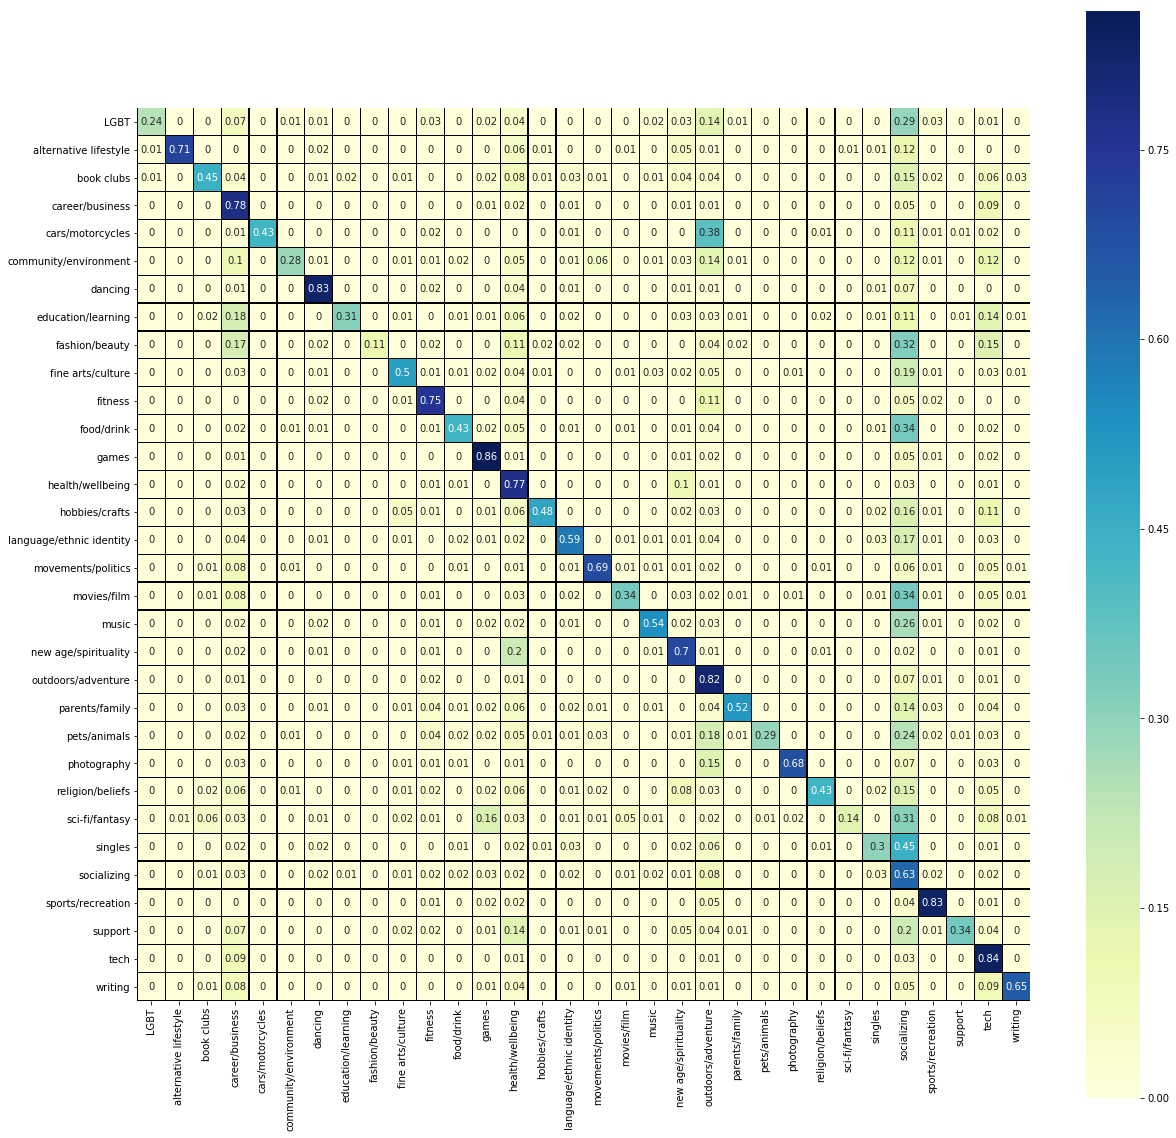

CPU times: user 33min 2s, sys: 9.81 s, total: 33min 12s
Wall time: 1min 24s


In [350]:
%%time
model_desc_lemm, score = run_experiment(df.desc_lemm, df.category_label, 
               mode = "tfidf", max_features=5000, 
               param_grid = None, print_classification_report = True, show_confusion_matrix = True, le = le,
               verbose = True, random_search=False, params = None)

extracting tf-idf features...
tf-idf features shape:	(120809, 5000)
Classifying with Random Forest...
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=35, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)
Starting to fit


[Parallel(n_jobs=35)]: Using backend ThreadingBackend with 35 concurrent workers.
[Parallel(n_jobs=35)]: Done 100 out of 100 | elapsed:   58.9s finished
[Parallel(n_jobs=35)]: Using backend ThreadingBackend with 35 concurrent workers.


Scoring


[Parallel(n_jobs=35)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=35)]: Using backend ThreadingBackend with 35 concurrent workers.


Test score:	0.6748613525370416


[Parallel(n_jobs=35)]: Done 100 out of 100 | elapsed:    0.3s finished


                          precision    recall  f1-score   support

                    LGBT      0.891     0.239     0.377       205
   alternative lifestyle      0.975     0.706     0.819       109
              book clubs      0.513     0.435     0.471       186
         career/business      0.691     0.781     0.733      2214
        cars/motorcycles      0.819     0.483     0.608       178
   community/environment      0.747     0.269     0.396       449
                 dancing      0.767     0.821     0.793       643
      education/learning      0.763     0.315     0.445       461
          fashion/beauty      0.556     0.106     0.179        47
       fine arts/culture      0.672     0.488     0.565       537
                 fitness      0.788     0.750     0.768      1286
              food/drink      0.646     0.430     0.516       684
                   games      0.754     0.852     0.800       790
        health/wellbeing      0.684     0.778     0.728      2371
         

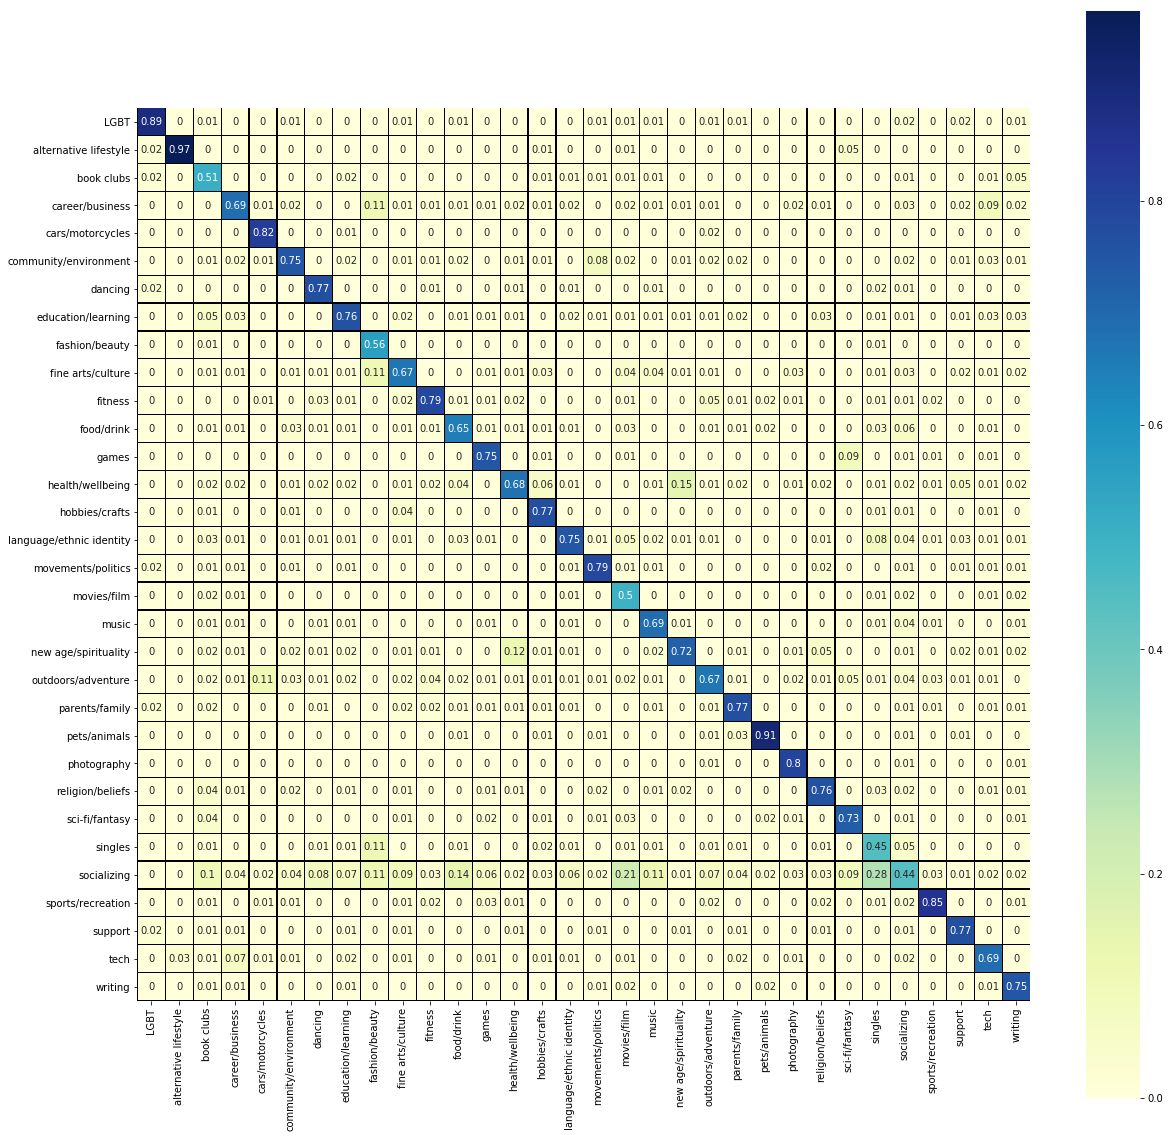

precision-way confusion matrix


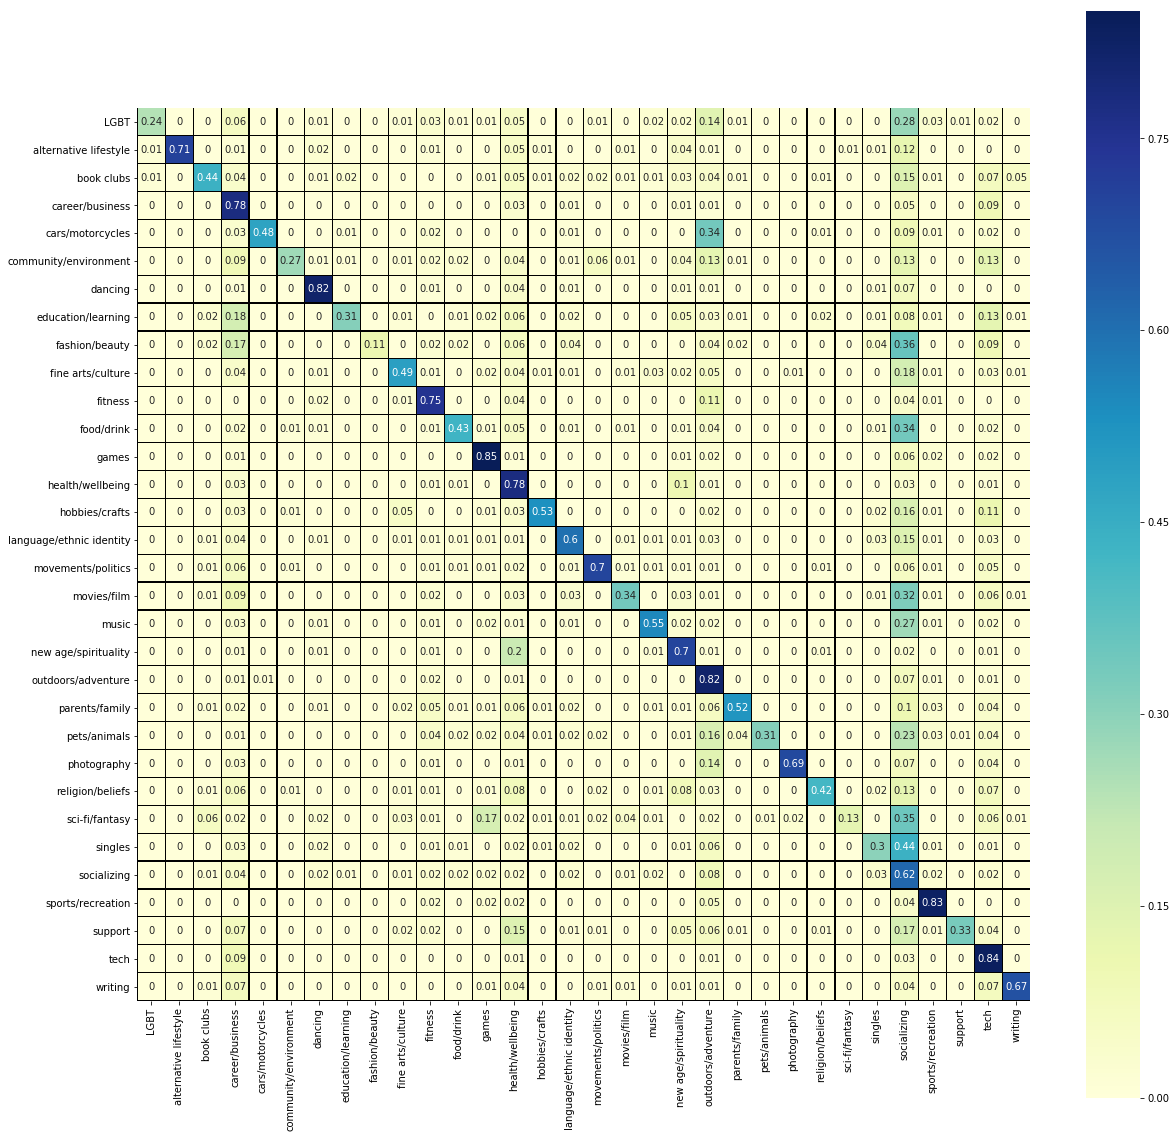

CPU times: user 31min 44s, sys: 9.43 s, total: 31min 53s
Wall time: 1min 20s


In [353]:
%%time
model_desc_lemm_no_badwords, score = run_experiment(df.desc_lemm_no_badwords, df.category_label, 
               mode = "tfidf", max_features=5000, 
               param_grid = None, print_classification_report = True, show_confusion_matrix = True, le = le,
               verbose = True, random_search=False, params = None)

extracting tf-idf features...
tf-idf features shape:	(120809, 5000)
Classifying with Random Forest...
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=35, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)
Starting to fit


[Parallel(n_jobs=35)]: Using backend ThreadingBackend with 35 concurrent workers.
[Parallel(n_jobs=35)]: Done 100 out of 100 | elapsed:  1.0min finished
[Parallel(n_jobs=35)]: Using backend ThreadingBackend with 35 concurrent workers.


Scoring


[Parallel(n_jobs=35)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=35)]: Using backend ThreadingBackend with 35 concurrent workers.


Test score:	0.6710123334161079


[Parallel(n_jobs=35)]: Done 100 out of 100 | elapsed:    0.3s finished


                          precision    recall  f1-score   support

                    LGBT      0.911     0.249     0.391       205
   alternative lifestyle      0.963     0.706     0.815       109
              book clubs      0.526     0.441     0.480       186
         career/business      0.691     0.772     0.729      2214
        cars/motorcycles      0.843     0.421     0.562       178
   community/environment      0.753     0.265     0.392       449
                 dancing      0.773     0.823     0.797       643
      education/learning      0.738     0.306     0.433       461
          fashion/beauty      0.556     0.106     0.179        47
       fine arts/culture      0.695     0.480     0.568       537
                 fitness      0.787     0.747     0.767      1286
              food/drink      0.649     0.427     0.515       684
                   games      0.768     0.849     0.806       790
        health/wellbeing      0.682     0.776     0.726      2371
         

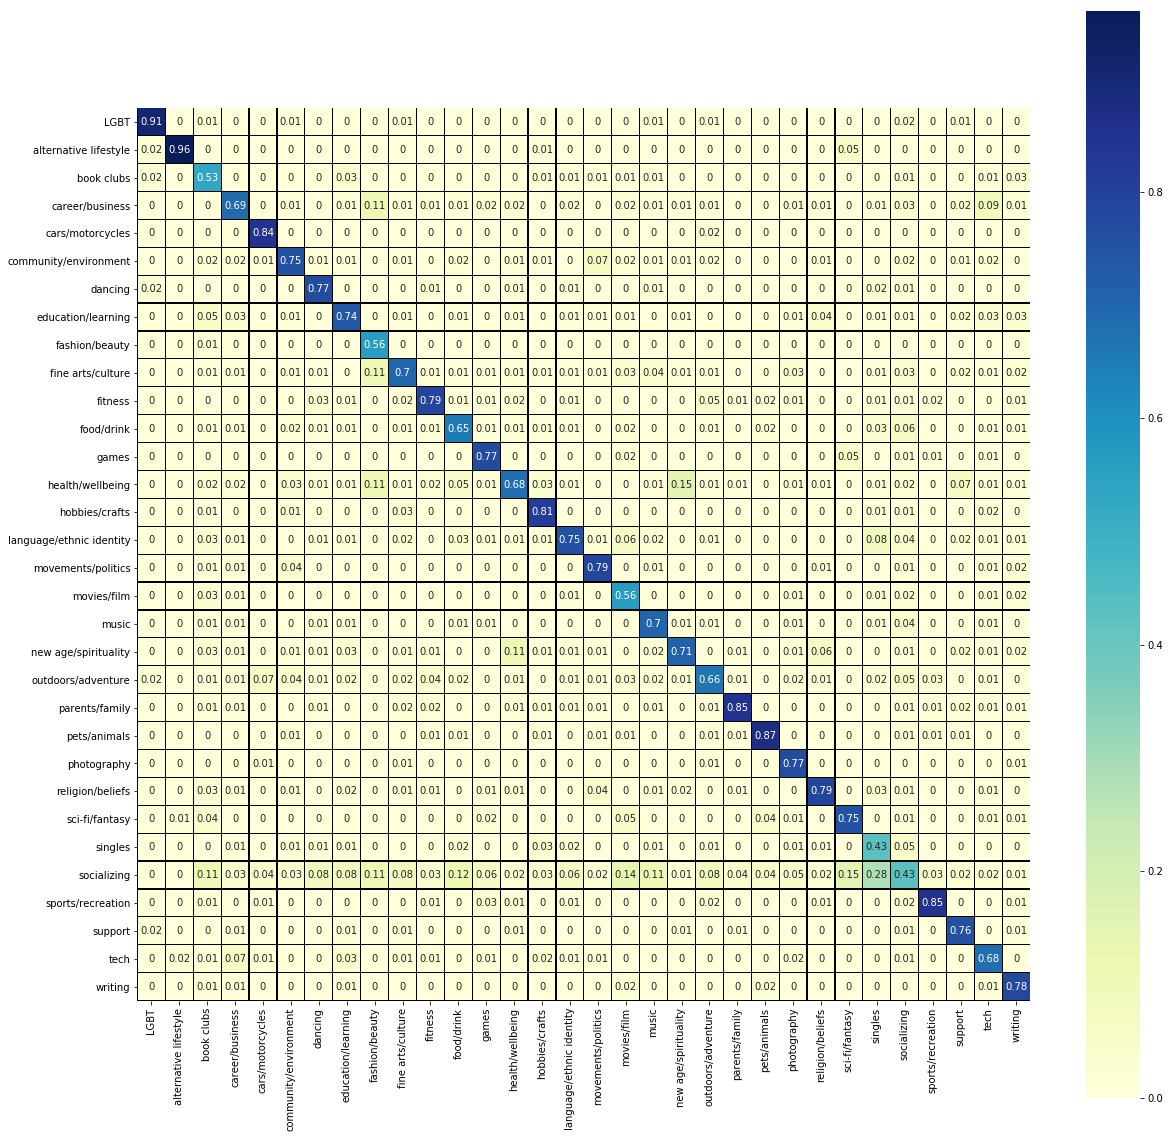

precision-way confusion matrix


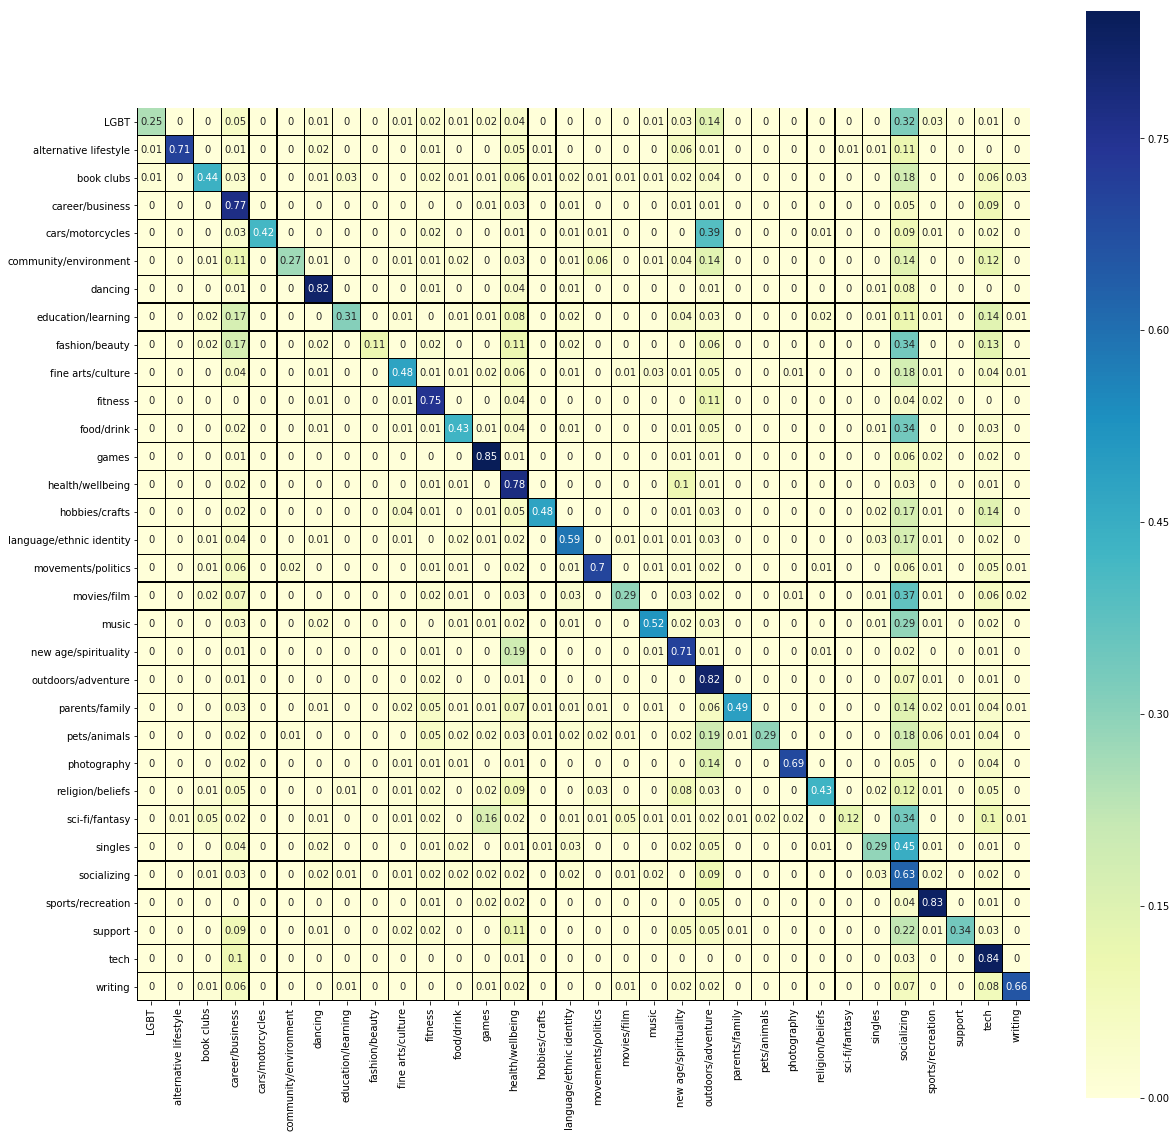

CPU times: user 33min 42s, sys: 9.04 s, total: 33min 51s
Wall time: 1min 24s


In [354]:
%%time
model_desc_stemm, score = run_experiment(df.desc_stemm, df.category_label, 
               mode = "tfidf", max_features=5000, 
               param_grid = None, print_classification_report = True, show_confusion_matrix = True, le = le,
               verbose = True, random_search=False, params = None)

extracting tf-idf features...
tf-idf features shape:	(120809, 5000)
Classifying with Random Forest...
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=35, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)
Starting to fit


[Parallel(n_jobs=35)]: Using backend ThreadingBackend with 35 concurrent workers.
[Parallel(n_jobs=35)]: Done 100 out of 100 | elapsed:   59.3s finished
[Parallel(n_jobs=35)]: Using backend ThreadingBackend with 35 concurrent workers.


Scoring


[Parallel(n_jobs=35)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=35)]: Using backend ThreadingBackend with 35 concurrent workers.


Test score:	0.6710951080208593


[Parallel(n_jobs=35)]: Done 100 out of 100 | elapsed:    0.3s finished


                          precision    recall  f1-score   support

                    LGBT      0.914     0.259     0.403       205
   alternative lifestyle      0.963     0.706     0.815       109
              book clubs      0.509     0.446     0.476       186
         career/business      0.697     0.773     0.733      2214
        cars/motorcycles      0.786     0.433     0.558       178
   community/environment      0.745     0.267     0.393       449
                 dancing      0.761     0.815     0.787       643
      education/learning      0.739     0.319     0.445       461
          fashion/beauty      0.625     0.106     0.182        47
       fine arts/culture      0.673     0.495     0.571       537
                 fitness      0.796     0.750     0.773      1286
              food/drink      0.642     0.423     0.510       684
                   games      0.755     0.854     0.802       790
        health/wellbeing      0.672     0.767     0.716      2371
         

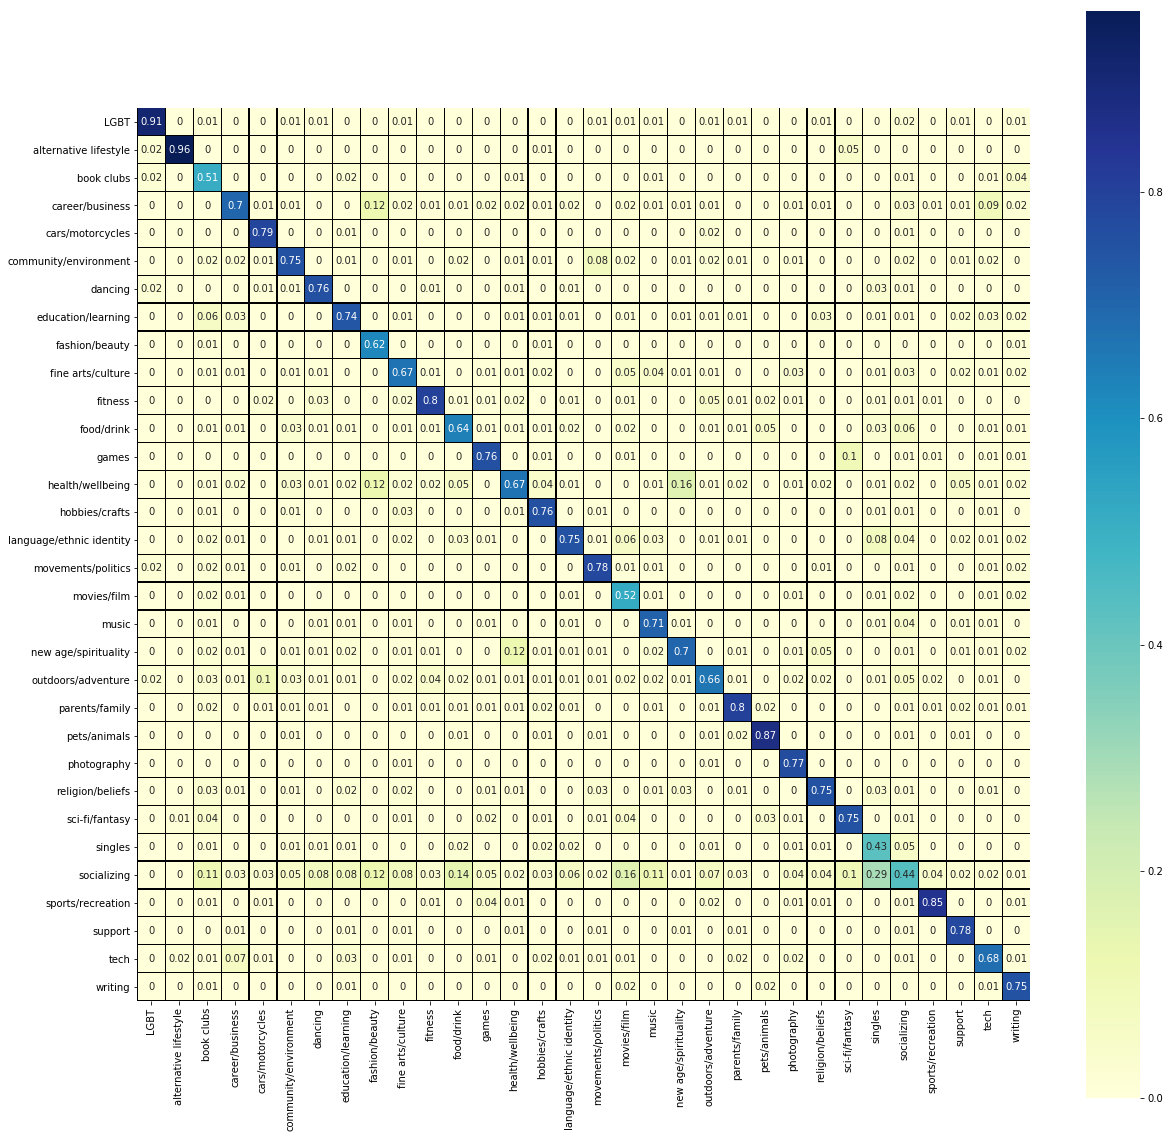

precision-way confusion matrix


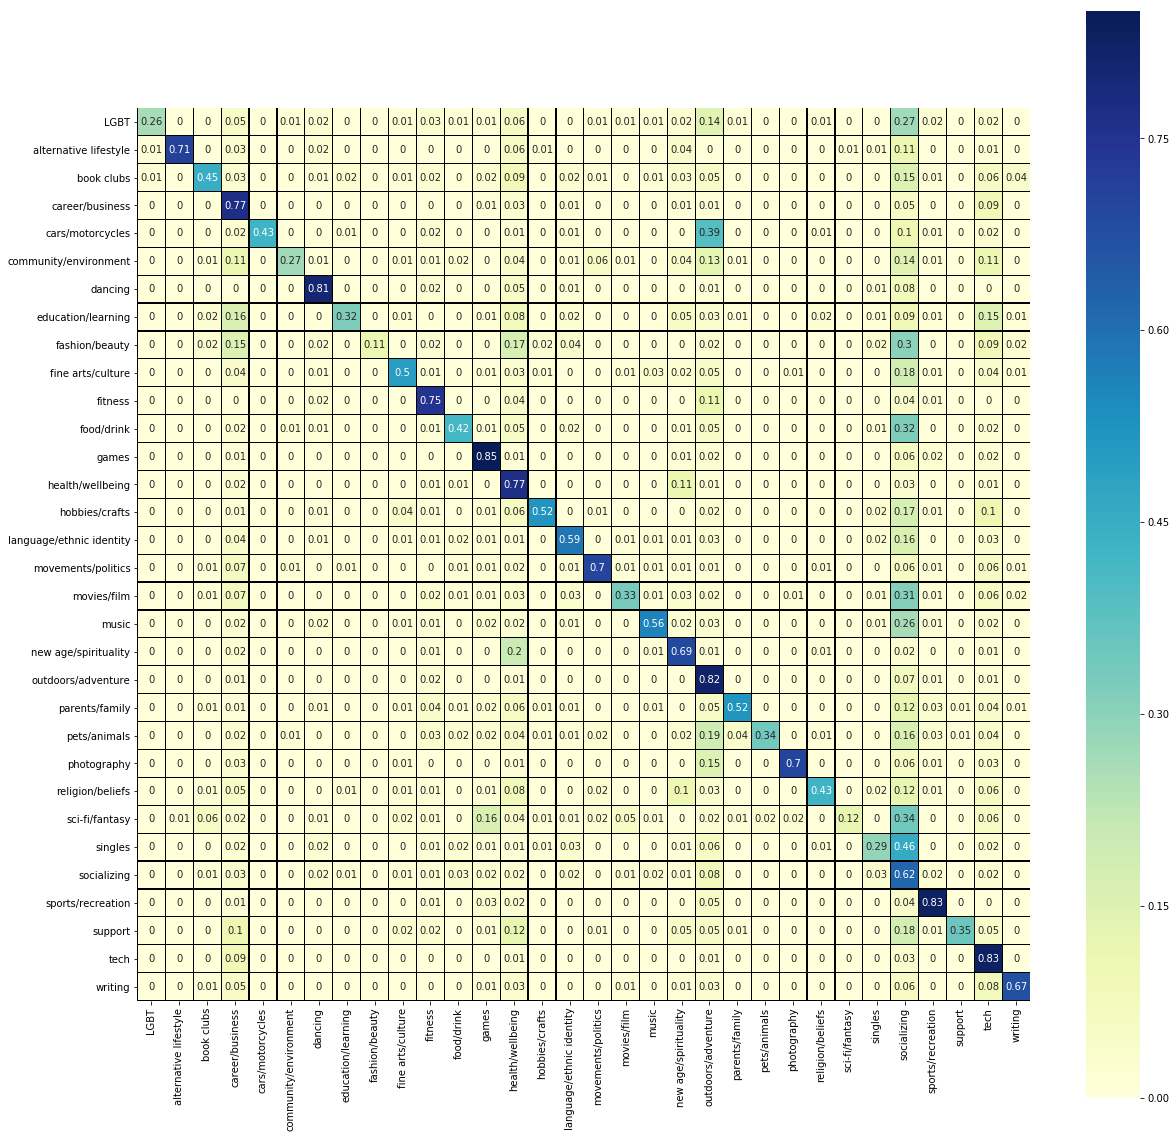

CPU times: user 32min 2s, sys: 9.3 s, total: 32min 11s
Wall time: 1min 20s


In [355]:
%%time
model_desc_stemm_no_badwords, score = run_experiment(df.desc_stemm_no_badwords, df.category_label, 
               mode = "tfidf", max_features=5000, 
               param_grid = None, print_classification_report = True, show_confusion_matrix = True, le = le,
               verbose = True, random_search=False, params = None)

## Count Vectorizer

extracting count-resulting features...
count-vect features shape:	(120809, 5000)
Classifying with Random Forest...
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=35, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)
Starting to fit


[Parallel(n_jobs=35)]: Using backend ThreadingBackend with 35 concurrent workers.
[Parallel(n_jobs=35)]: Done 100 out of 100 | elapsed:  1.1min finished
[Parallel(n_jobs=35)]: Using backend ThreadingBackend with 35 concurrent workers.


Scoring


[Parallel(n_jobs=35)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=35)]: Using backend ThreadingBackend with 35 concurrent workers.


Test score:	0.6769307176558232


[Parallel(n_jobs=35)]: Done 100 out of 100 | elapsed:    0.3s finished


                          precision    recall  f1-score   support

                    LGBT      0.867     0.254     0.392       205
   alternative lifestyle      0.975     0.706     0.819       109
              book clubs      0.536     0.441     0.484       186
         career/business      0.682     0.786     0.730      2214
        cars/motorcycles      0.827     0.455     0.587       178
   community/environment      0.786     0.269     0.401       449
                 dancing      0.778     0.827     0.802       643
      education/learning      0.799     0.302     0.438       461
          fashion/beauty      0.500     0.106     0.175        47
       fine arts/culture      0.688     0.484     0.568       537
                 fitness      0.792     0.755     0.773      1286
              food/drink      0.675     0.425     0.522       684
                   games      0.751     0.857     0.800       790
        health/wellbeing      0.689     0.767     0.726      2371
         

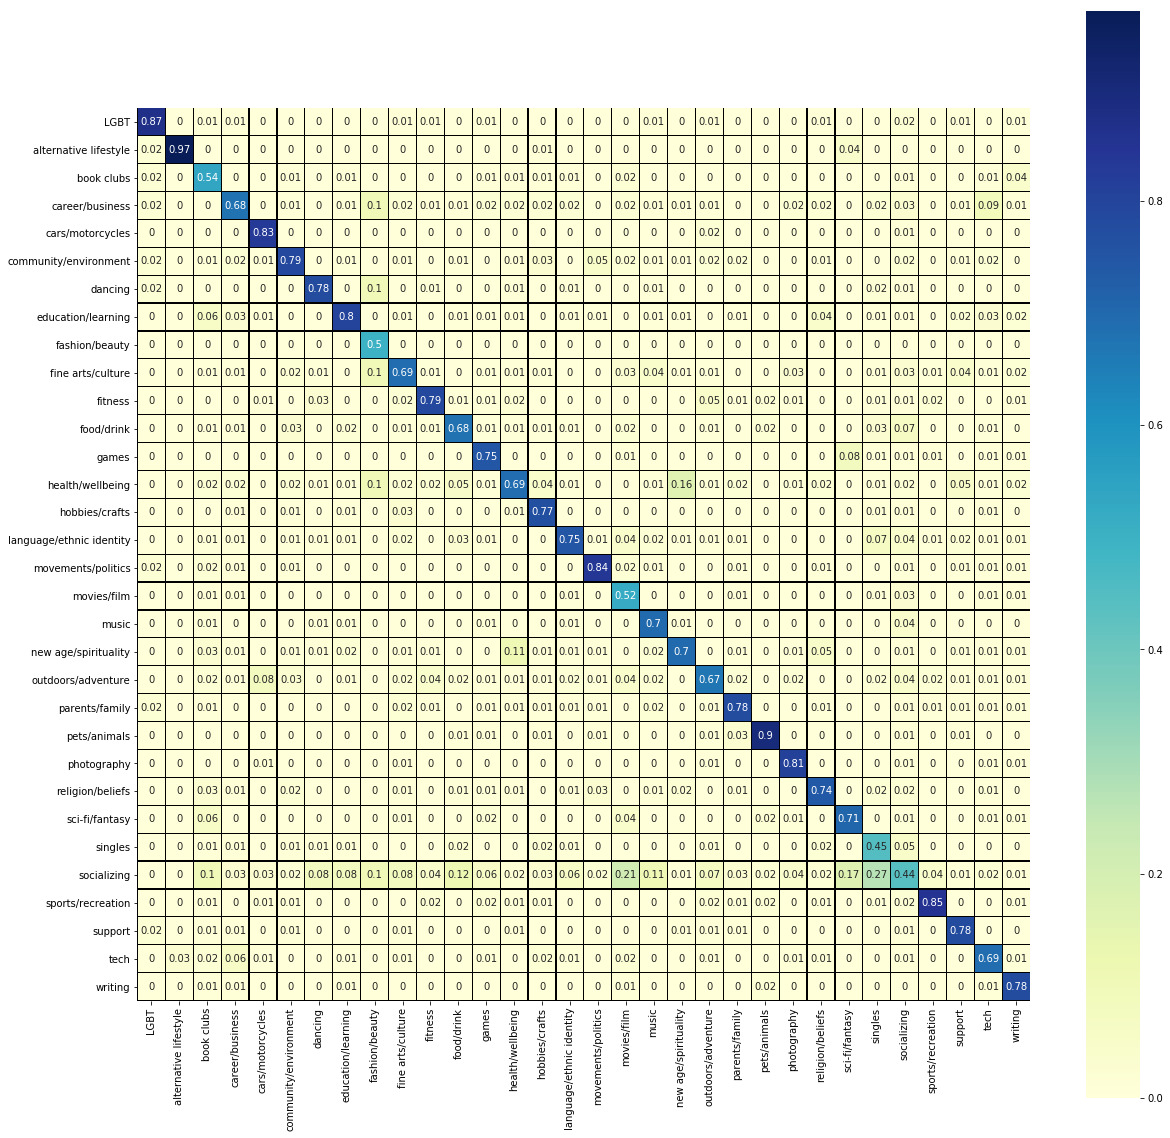

precision-way confusion matrix


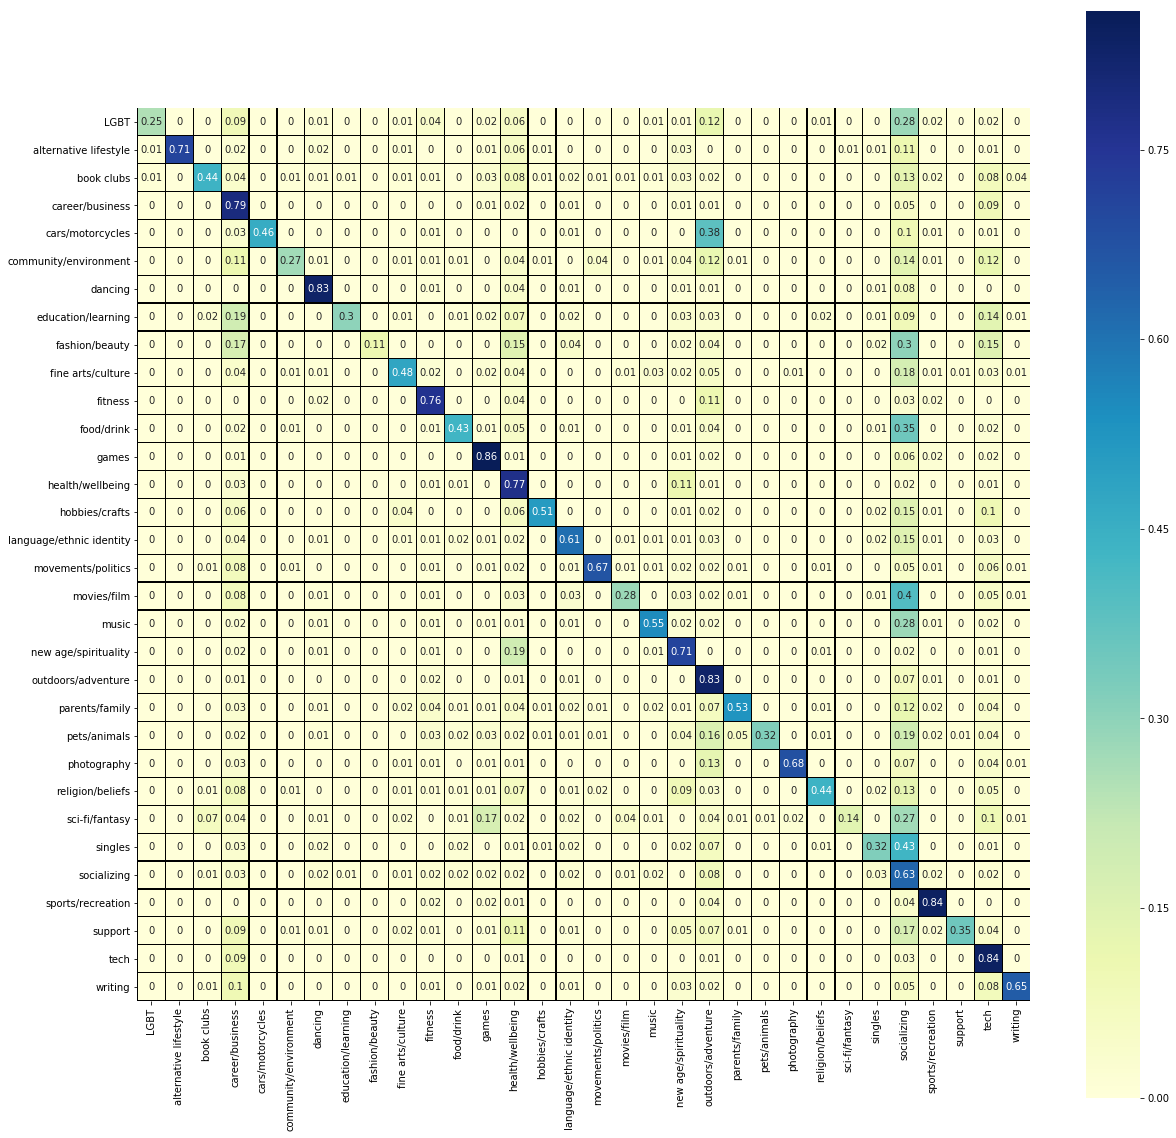

CPU times: user 34min 35s, sys: 10.6 s, total: 34min 46s
Wall time: 1min 27s


In [356]:
%%time
count_model_desc_lemm, score = run_experiment(df.desc_lemm, df.category_label, 
               mode = "count", max_features=5000, 
               param_grid = None, print_classification_report = True, show_confusion_matrix = True, le = le,
               verbose = True, random_search=False, params = None)

extracting count-resulting features...
count-vect features shape:	(120809, 5000)
Classifying with Random Forest...
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=35, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)
Starting to fit


[Parallel(n_jobs=35)]: Using backend ThreadingBackend with 35 concurrent workers.
[Parallel(n_jobs=35)]: Done 100 out of 100 | elapsed:  1.0min finished
[Parallel(n_jobs=35)]: Using backend ThreadingBackend with 35 concurrent workers.


Scoring


[Parallel(n_jobs=35)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=35)]: Using backend ThreadingBackend with 35 concurrent workers.


Test score:	0.6759788097011836


[Parallel(n_jobs=35)]: Done 100 out of 100 | elapsed:    0.3s finished


                          precision    recall  f1-score   support

                    LGBT      0.900     0.263     0.408       205
   alternative lifestyle      0.963     0.706     0.815       109
              book clubs      0.560     0.452     0.500       186
         career/business      0.678     0.779     0.725      2214
        cars/motorcycles      0.798     0.466     0.589       178
   community/environment      0.762     0.272     0.401       449
                 dancing      0.756     0.838     0.795       643
      education/learning      0.736     0.308     0.434       461
          fashion/beauty      0.556     0.106     0.179        47
       fine arts/culture      0.672     0.484     0.563       537
                 fitness      0.784     0.761     0.773      1286
              food/drink      0.669     0.437     0.529       684
                   games      0.737     0.859     0.794       790
        health/wellbeing      0.686     0.765     0.724      2371
         

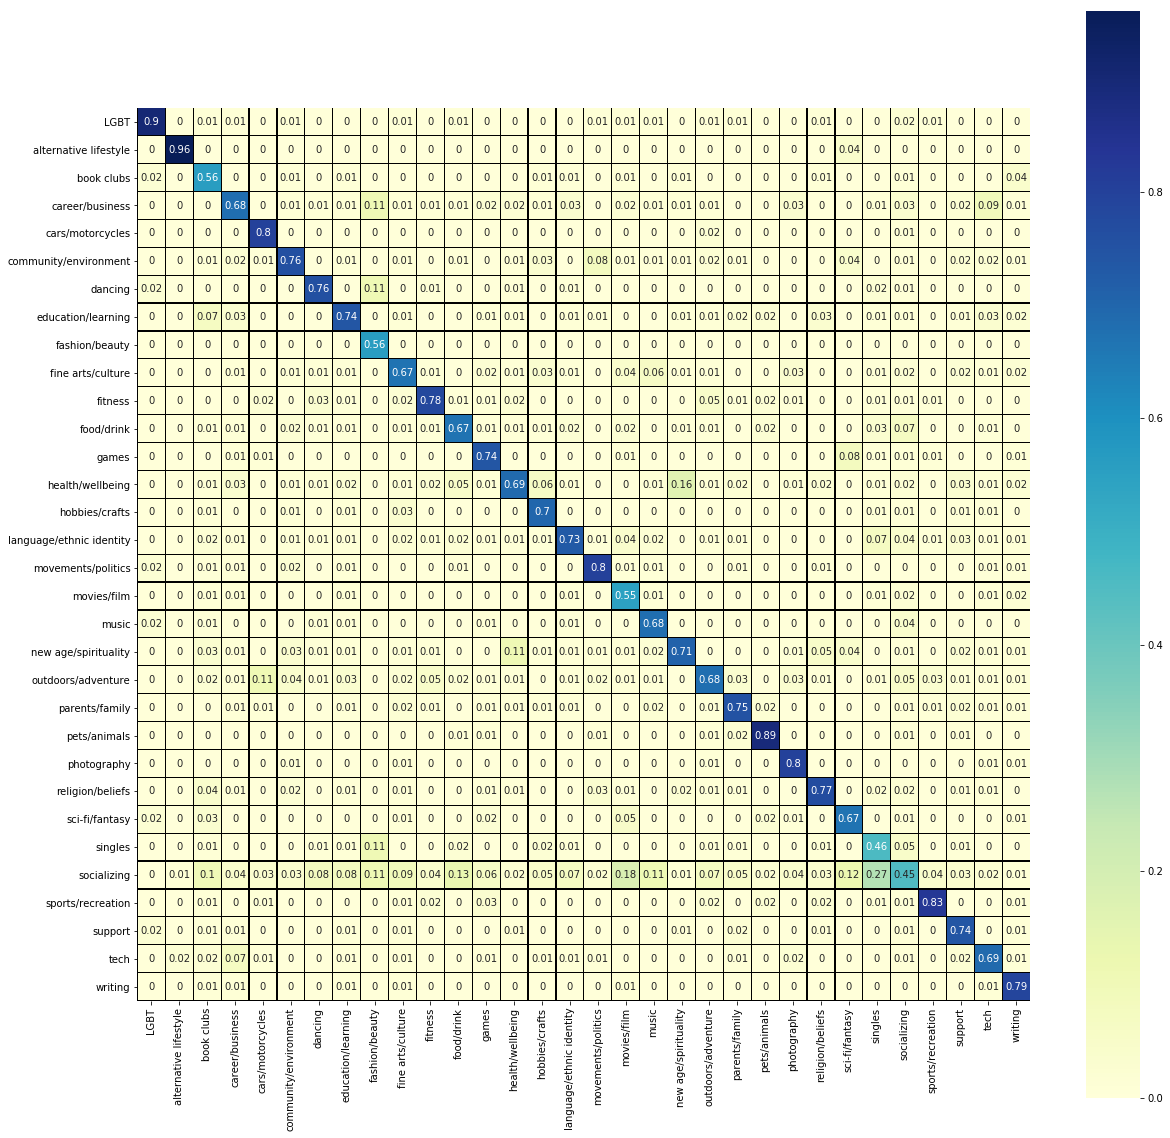

precision-way confusion matrix


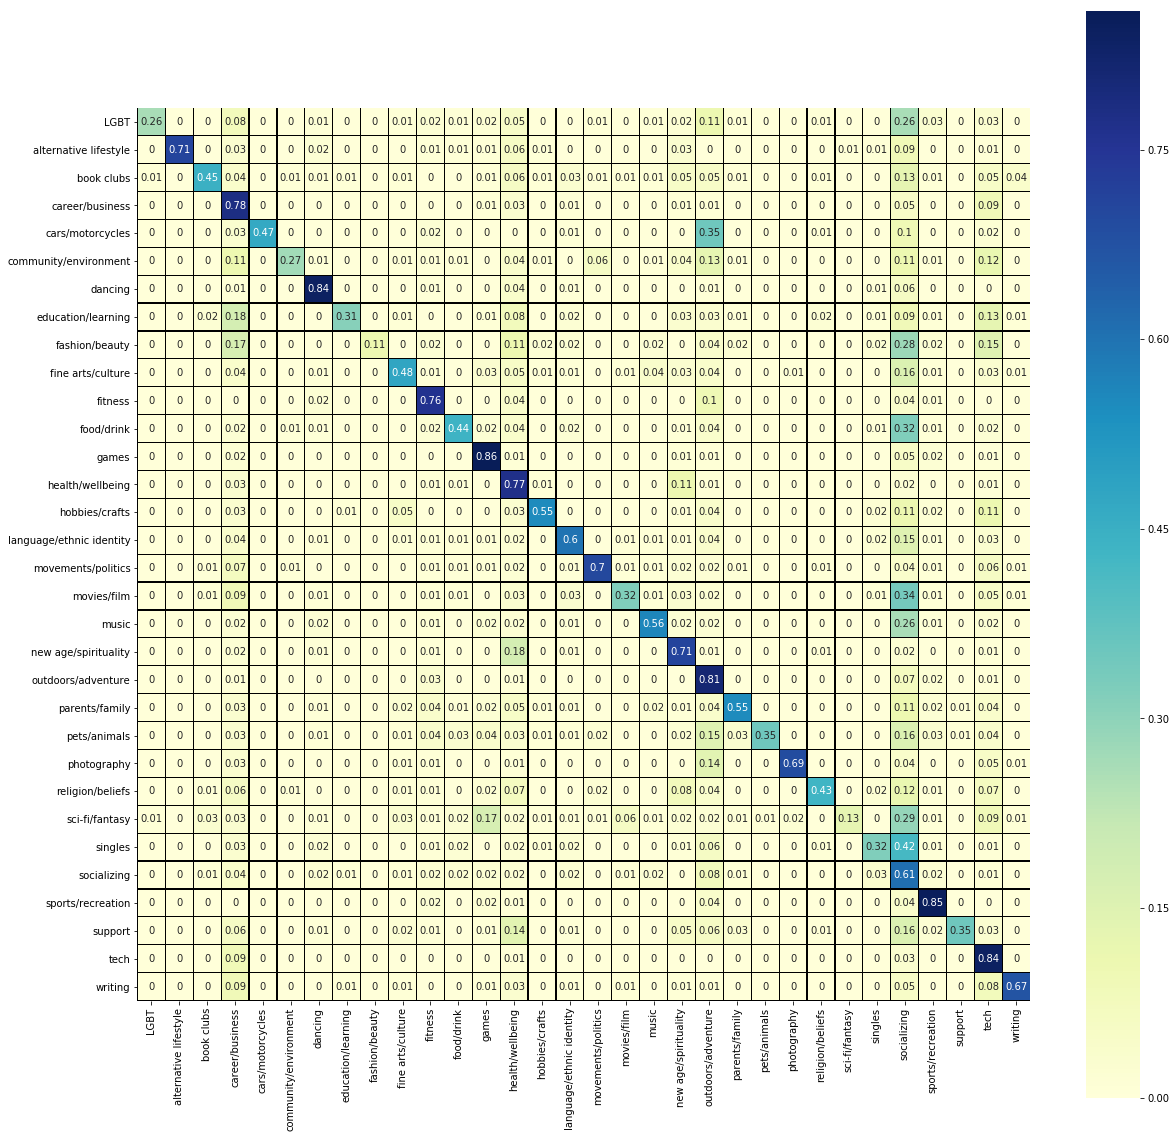

CPU times: user 32min 44s, sys: 12.1 s, total: 32min 56s
Wall time: 1min 22s


In [357]:
%%time
count_model_desc_lemm_no_badwords, score = run_experiment(df.desc_lemm_no_badwords, df.category_label, 
               mode = "count", max_features=5000, 
               param_grid = None, print_classification_report = True, show_confusion_matrix = True, le = le,
               verbose = True, random_search=False, params = None)

extracting count-resulting features...
count-vect features shape:	(120809, 5000)
Classifying with Random Forest...
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=35, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)
Starting to fit


[Parallel(n_jobs=35)]: Using backend ThreadingBackend with 35 concurrent workers.
[Parallel(n_jobs=35)]: Done 100 out of 100 | elapsed:  1.1min finished
[Parallel(n_jobs=35)]: Using backend ThreadingBackend with 35 concurrent workers.


Scoring


[Parallel(n_jobs=35)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=35)]: Using backend ThreadingBackend with 35 concurrent workers.


Test score:	0.675937422398808


[Parallel(n_jobs=35)]: Done 100 out of 100 | elapsed:    0.3s finished


                          precision    recall  f1-score   support

                    LGBT      0.877     0.244     0.382       205
   alternative lifestyle      0.963     0.706     0.815       109
              book clubs      0.503     0.441     0.470       186
         career/business      0.690     0.785     0.735      2214
        cars/motorcycles      0.827     0.483     0.610       178
   community/environment      0.796     0.269     0.403       449
                 dancing      0.769     0.820     0.794       643
      education/learning      0.731     0.306     0.431       461
          fashion/beauty      0.455     0.106     0.172        47
       fine arts/culture      0.718     0.479     0.574       537
                 fitness      0.790     0.758     0.774      1286
              food/drink      0.677     0.425     0.522       684
                   games      0.756     0.857     0.804       790
        health/wellbeing      0.682     0.772     0.724      2371
         

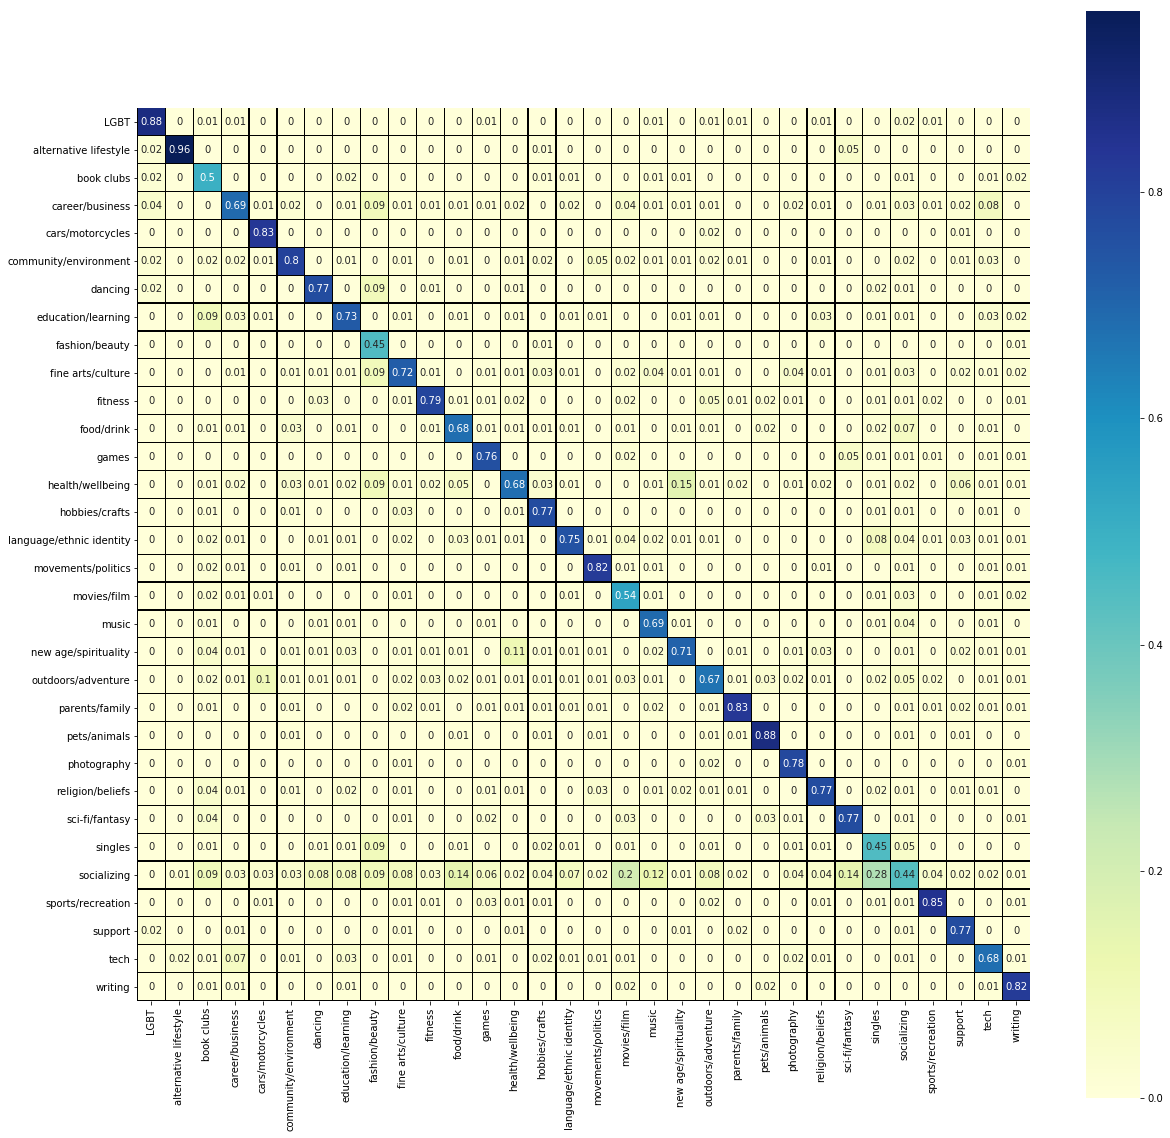

precision-way confusion matrix


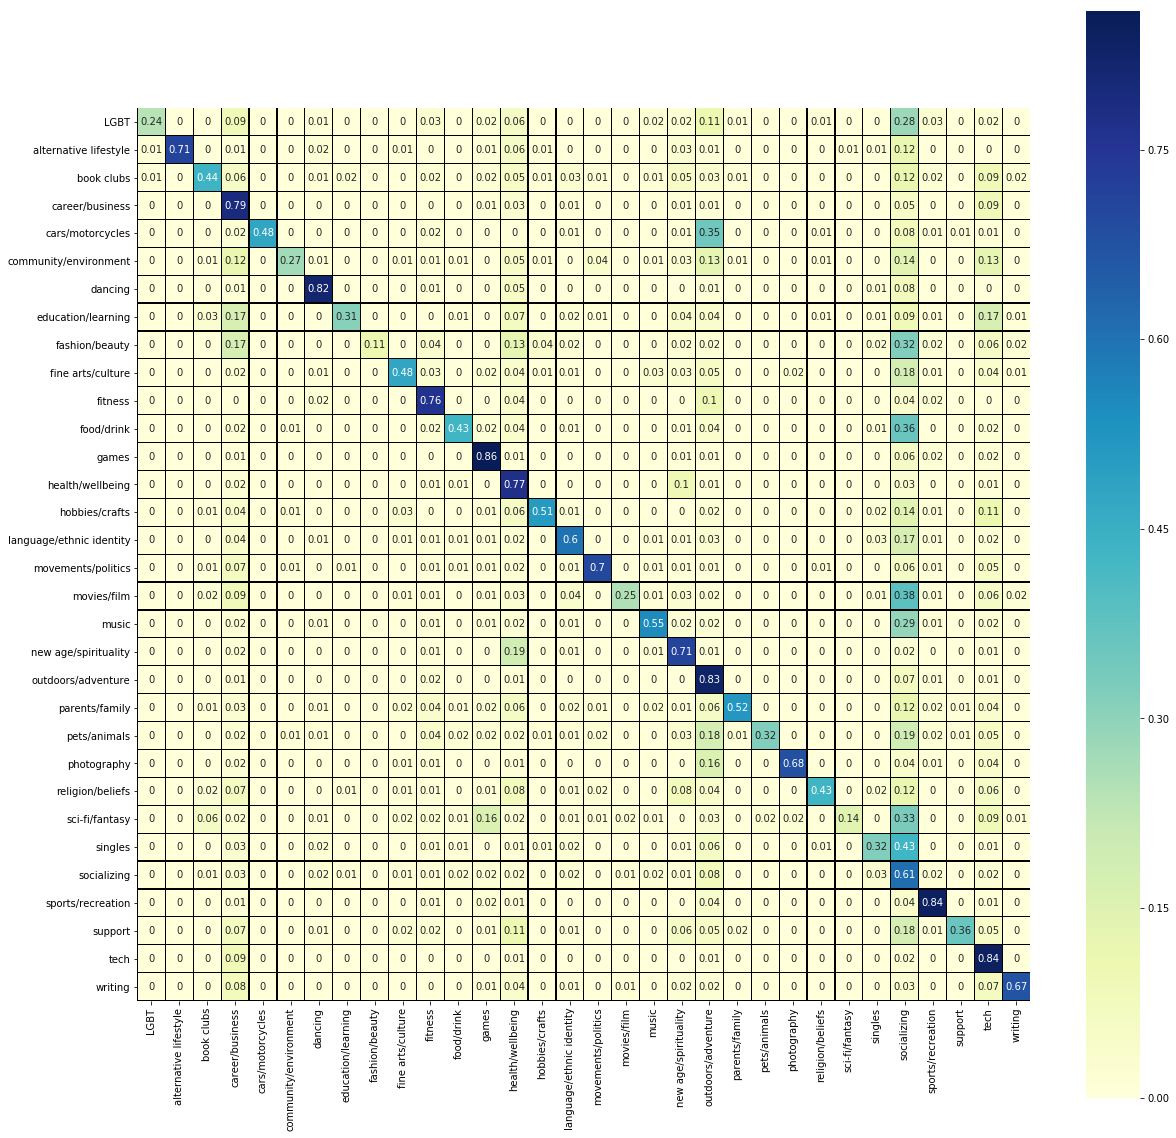

CPU times: user 34min 15s, sys: 11.6 s, total: 34min 26s
Wall time: 1min 25s


In [358]:
%%time
count_model_desc_stemm, score = run_experiment(df.desc_stemm, df.category_label, 
               mode = "count", max_features=5000, 
               param_grid = None, print_classification_report = True, show_confusion_matrix = True, le = le,
               verbose = True, random_search=False, params = None)

extracting count-resulting features...
count-vect features shape:	(120809, 5000)
Classifying with Random Forest...
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=35, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)
Starting to fit


[Parallel(n_jobs=35)]: Using backend ThreadingBackend with 35 concurrent workers.
[Parallel(n_jobs=35)]: Done 100 out of 100 | elapsed:  1.0min finished
[Parallel(n_jobs=35)]: Using backend ThreadingBackend with 35 concurrent workers.


Scoring


[Parallel(n_jobs=35)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=35)]: Using backend ThreadingBackend with 35 concurrent workers.


Test score:	0.6748613525370416


[Parallel(n_jobs=35)]: Done 100 out of 100 | elapsed:    0.3s finished


                          precision    recall  f1-score   support

                    LGBT      0.897     0.254     0.395       205
   alternative lifestyle      0.963     0.706     0.815       109
              book clubs      0.494     0.435     0.463       186
         career/business      0.694     0.777     0.733      2214
        cars/motorcycles      0.791     0.489     0.604       178
   community/environment      0.753     0.272     0.399       449
                 dancing      0.763     0.829     0.794       643
      education/learning      0.741     0.304     0.431       461
          fashion/beauty      0.625     0.106     0.182        47
       fine arts/culture      0.675     0.488     0.566       537
                 fitness      0.778     0.757     0.767      1286
              food/drink      0.648     0.436     0.521       684
                   games      0.743     0.851     0.793       790
        health/wellbeing      0.686     0.768     0.725      2371
         

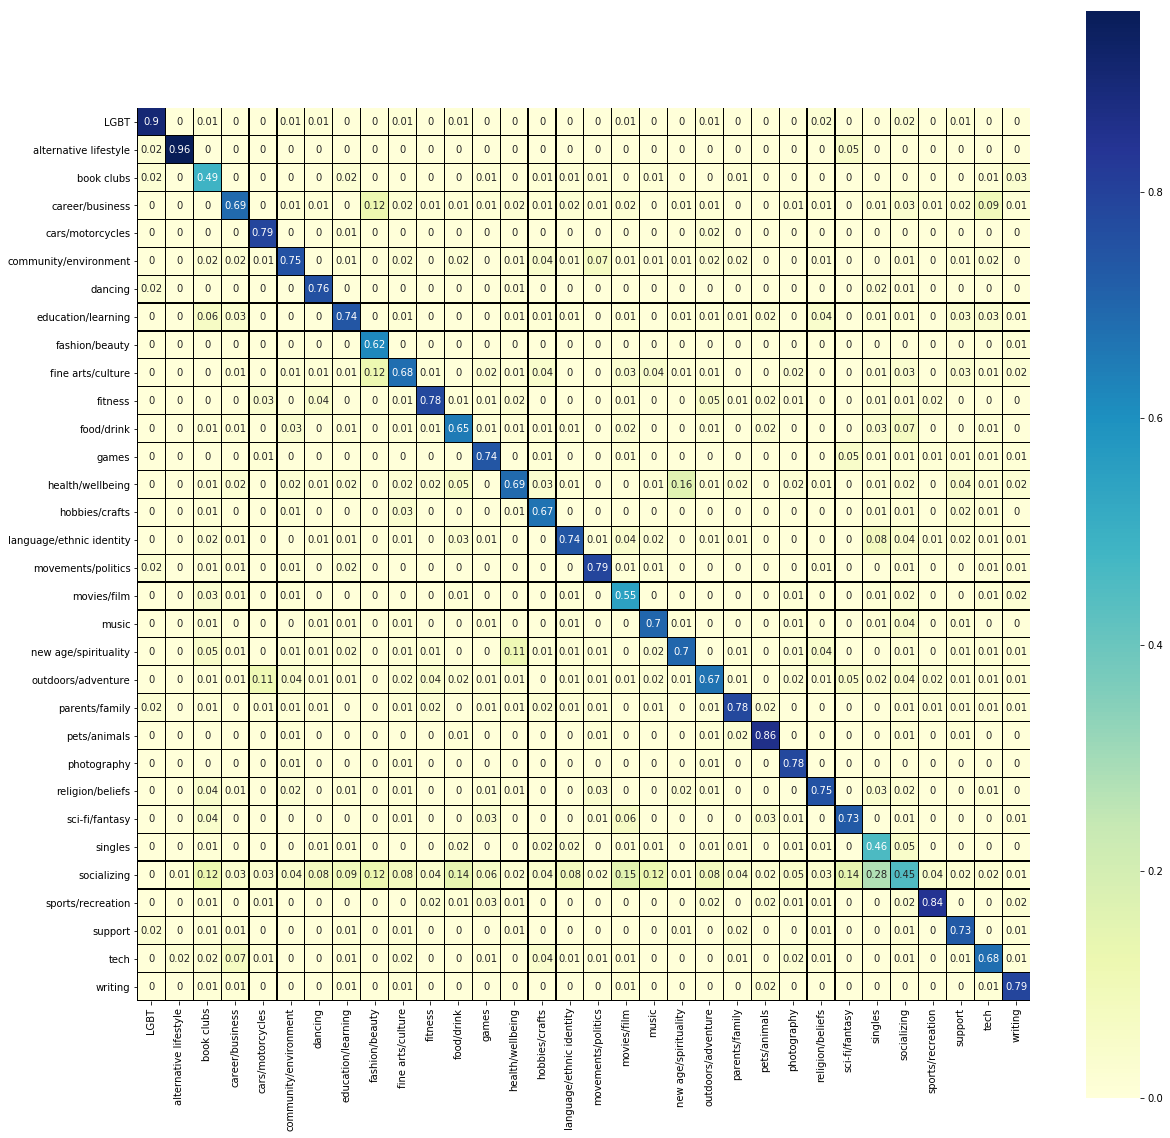

precision-way confusion matrix


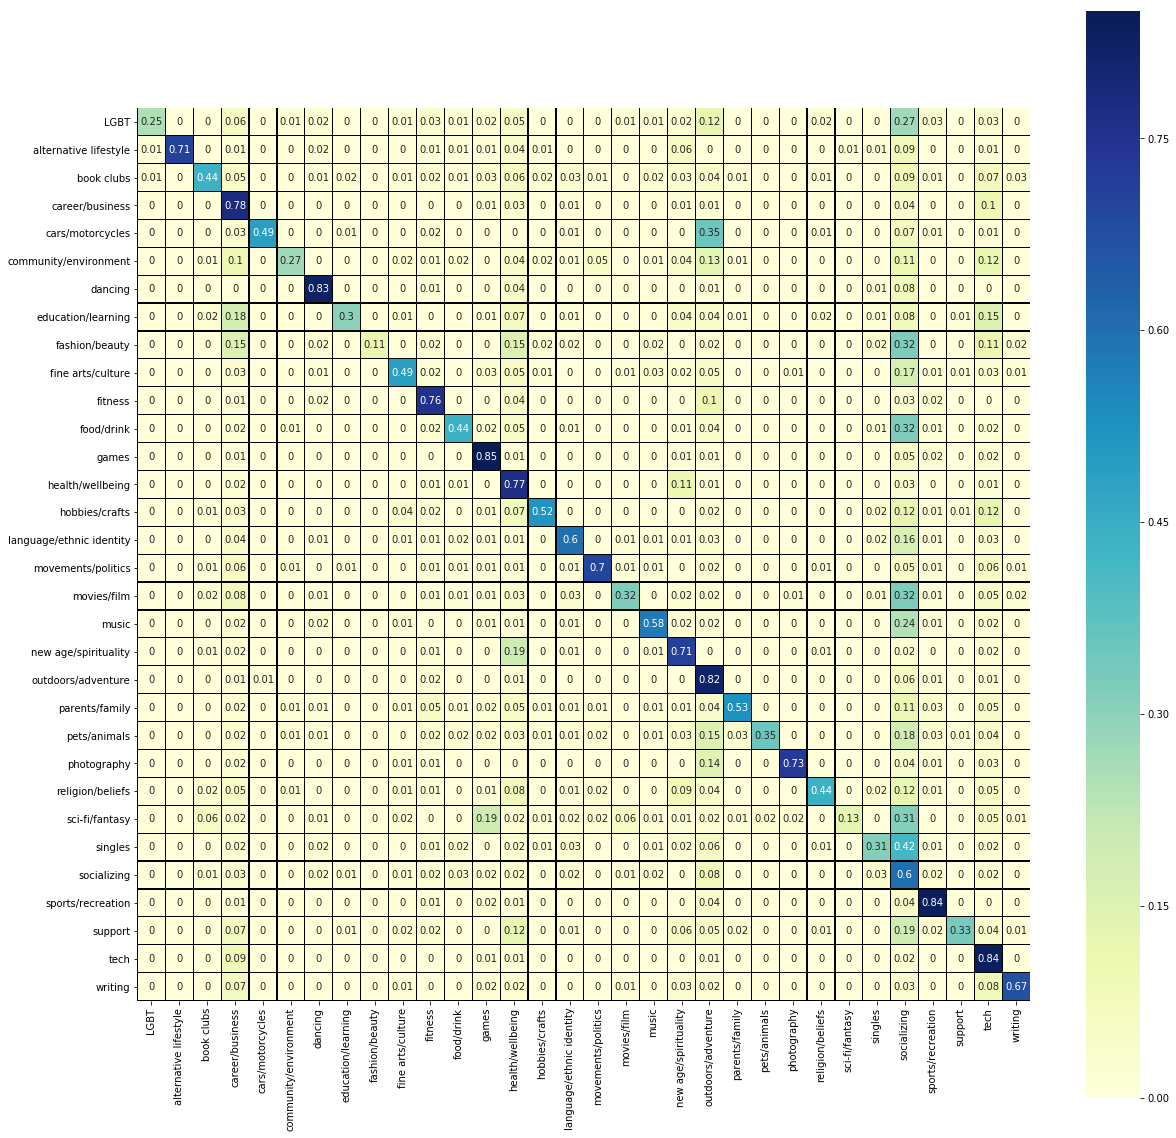

CPU times: user 32min 59s, sys: 10.7 s, total: 33min 9s
Wall time: 1min 22s


In [359]:
%%time
count_model_desc_stemm_no_badwords, score = run_experiment(df.desc_stemm_no_badwords, df.category_label, 
               mode = "count", max_features=5000, 
               param_grid = None, print_classification_report = True, show_confusion_matrix = True, le = le,
            
                                                           
               verbose = True, random_search=False, params = None)

In [215]:
#avg top-k acc test

X_train,X_test, y_train, y_test = train_test_split(X_data, y_data, test_size = 0.2, random_state = 42, stratify = y_data)

k=3
probs = count_model_desc_stemm_no_badwords.predict_proba(X_test)
y_true = y_test.values
topn = np.argsort(probs, axis = 1)[:,-k:]
np.mean(np.array([1 if y_true[k] in topn[k] else 0 for k in range(len(topn))]))

## Initial Evaluation (no remapping)

In [219]:
y_pred = count_model_desc_stemm_no_badwords.predict(X_test)
print(classification_report(y_test, y_pred, target_names=names))  

[Parallel(n_jobs=35)]: Using backend ThreadingBackend with 35 concurrent workers.


                          precision    recall  f1-score   support

                    LGBT       0.91      0.24      0.38       205
   alternative lifestyle       0.96      0.71      0.81       109
              book clubs       0.46      0.40      0.43       186
         career/business       0.70      0.78      0.74      2214
        cars/motorcycles       0.82      0.47      0.59       178
   community/environment       0.76      0.28      0.41       449
                 dancing       0.75      0.83      0.79       643
      education/learning       0.73      0.32      0.44       461
          fashion/beauty       0.56      0.11      0.18        47
       fine arts/culture       0.69      0.49      0.57       537
                 fitness       0.78      0.76      0.77      1286
              food/drink       0.65      0.43      0.52       684
                   games       0.74      0.85      0.79       790
        health/wellbeing       0.68      0.77      0.72      2371
         

[Parallel(n_jobs=35)]: Done 100 out of 100 | elapsed:    0.3s finished


recall-way confusion matrix


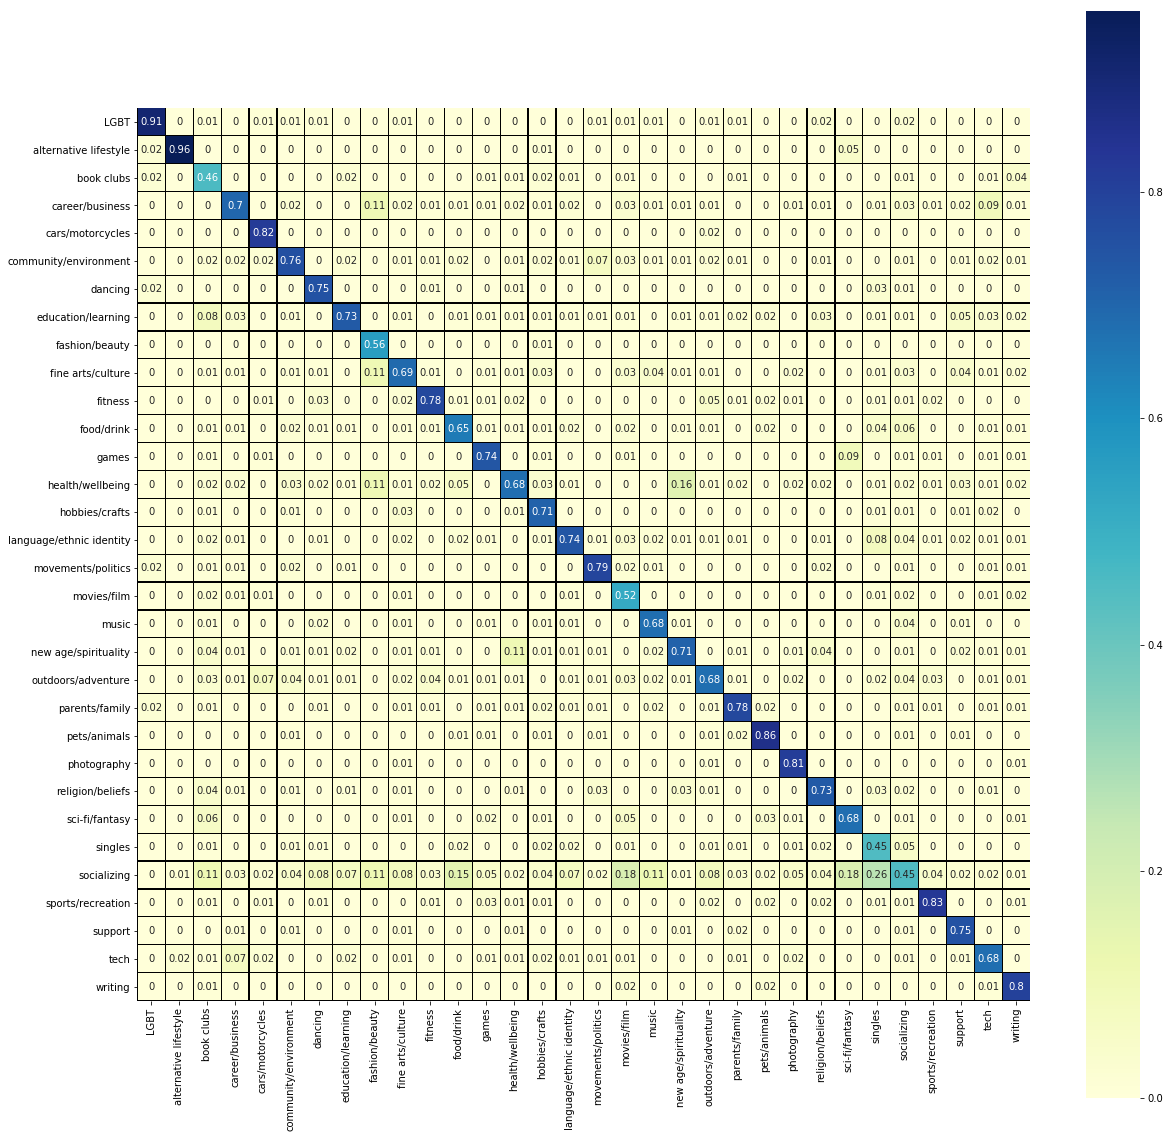

precision-way confusion matrix


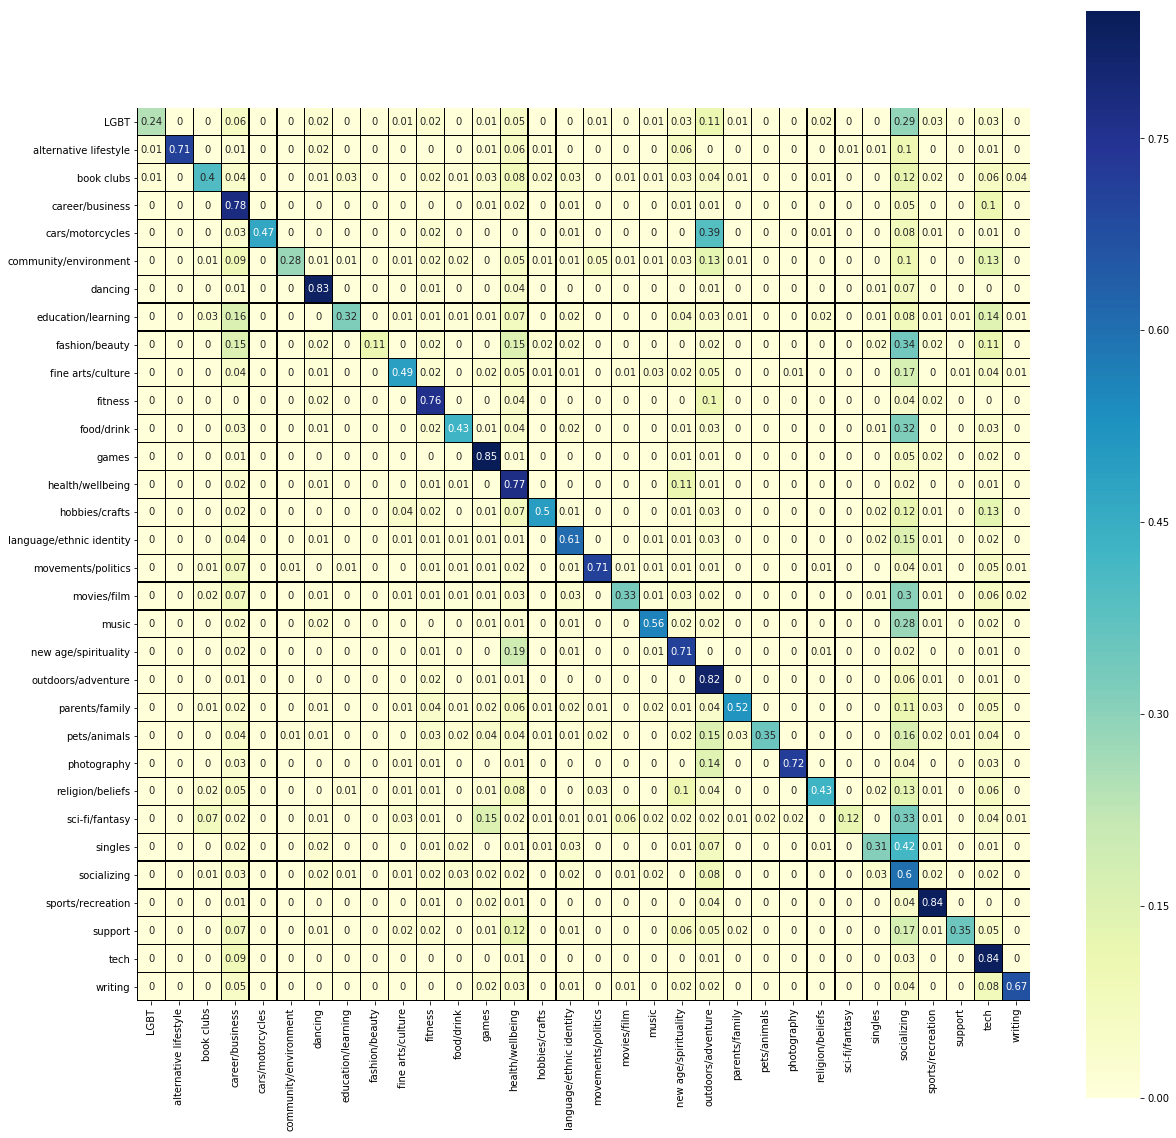

In [265]:
print("recall-way confusion matrix")
plt.figure(figsize = (20,20))
sns.heatmap(np.round(confusion_matrix(y_test, y_pred, normalize = "pred"),2), cmap = "YlGnBu", annot=True, square=True, linewidths=.2, linecolor="black", xticklabels=list(names), yticklabels=list(names))
plt.show()
print("precision-way confusion matrix")
plt.figure(figsize = (20,20))
sns.heatmap(np.round(confusion_matrix(y_test, y_pred, normalize = "true"), 2), cmap = "YlGnBu", annot=True, square=True, linewidths=.2, linecolor="black", xticklabels=list(names), yticklabels=list(names))
plt.show()


# Remapping under-represented categories

In [8]:
# LGBT --> socializing 
# singles --> socializing
# fashion/beauty --> health/wellbeing
# sci-fi/fantasy --> games
# support --> health/wellbeing (?) or socializing but meh

category_remap_dict = {
    "LGBT": "socializing",
    "singles": "socializing",
    "fashion/beauty": "health/wellbeing",
    "movies/film": "socializing",
    "book clubs": "education/learning",
    "sci-fi/fantasy": "games",
    "support": "health/wellbeing",
    "cars/motorcycles": "outdoors/adventure"
}


df["remap_category"] = df.category.map(lambda x: category_remap_dict[x] if x in category_remap_dict.keys() else x )
from sklearn.preprocessingssingocessingprocessing import LabelEncoder
l = LabelEncoder()
df["remap_category_label"] = l.fit_transform(df.remap_category)
df["remap_category_label"].unique().shape, df.category.unique().shape[0]-len(category_remap_dict)

((24,), 24)

In [9]:
df.to_pickle("../data/df_preprocessed_eng_remap.pckle")

## Re-Evaluation

extracting count-resulting features...
count-vect features shape:	(120809, 5000)
Classifying with Random Forest...
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=35, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)
Starting to fit


[Parallel(n_jobs=35)]: Using backend ThreadingBackend with 35 concurrent workers.
[Parallel(n_jobs=35)]: Done 100 out of 100 | elapsed:   57.6s finished
[Parallel(n_jobs=35)]: Using backend ThreadingBackend with 35 concurrent workers.


Scoring


[Parallel(n_jobs=35)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=35)]: Using backend ThreadingBackend with 35 concurrent workers.


Test score:	0.6923681814419336


[Parallel(n_jobs=35)]: Done 100 out of 100 | elapsed:    0.2s finished


                          precision    recall  f1-score   support

   alternative lifestyle      0.928     0.706     0.802       109
         career/business      0.707     0.776     0.740      2214
   community/environment      0.817     0.298     0.437       449
                 dancing      0.790     0.830     0.810       643
      education/learning      0.609     0.383     0.471       647
       fine arts/culture      0.652     0.492     0.561       537
                 fitness      0.791     0.733     0.761      1286
              food/drink      0.680     0.385     0.491       684
                   games      0.768     0.748     0.757       915
        health/wellbeing      0.664     0.732     0.696      2638
          hobbies/crafts      0.733     0.504     0.597       262
language/ethnic identity      0.782     0.594     0.675       854
      movements/politics      0.841     0.695     0.761       387
                   music      0.717     0.556     0.626       493
    new a

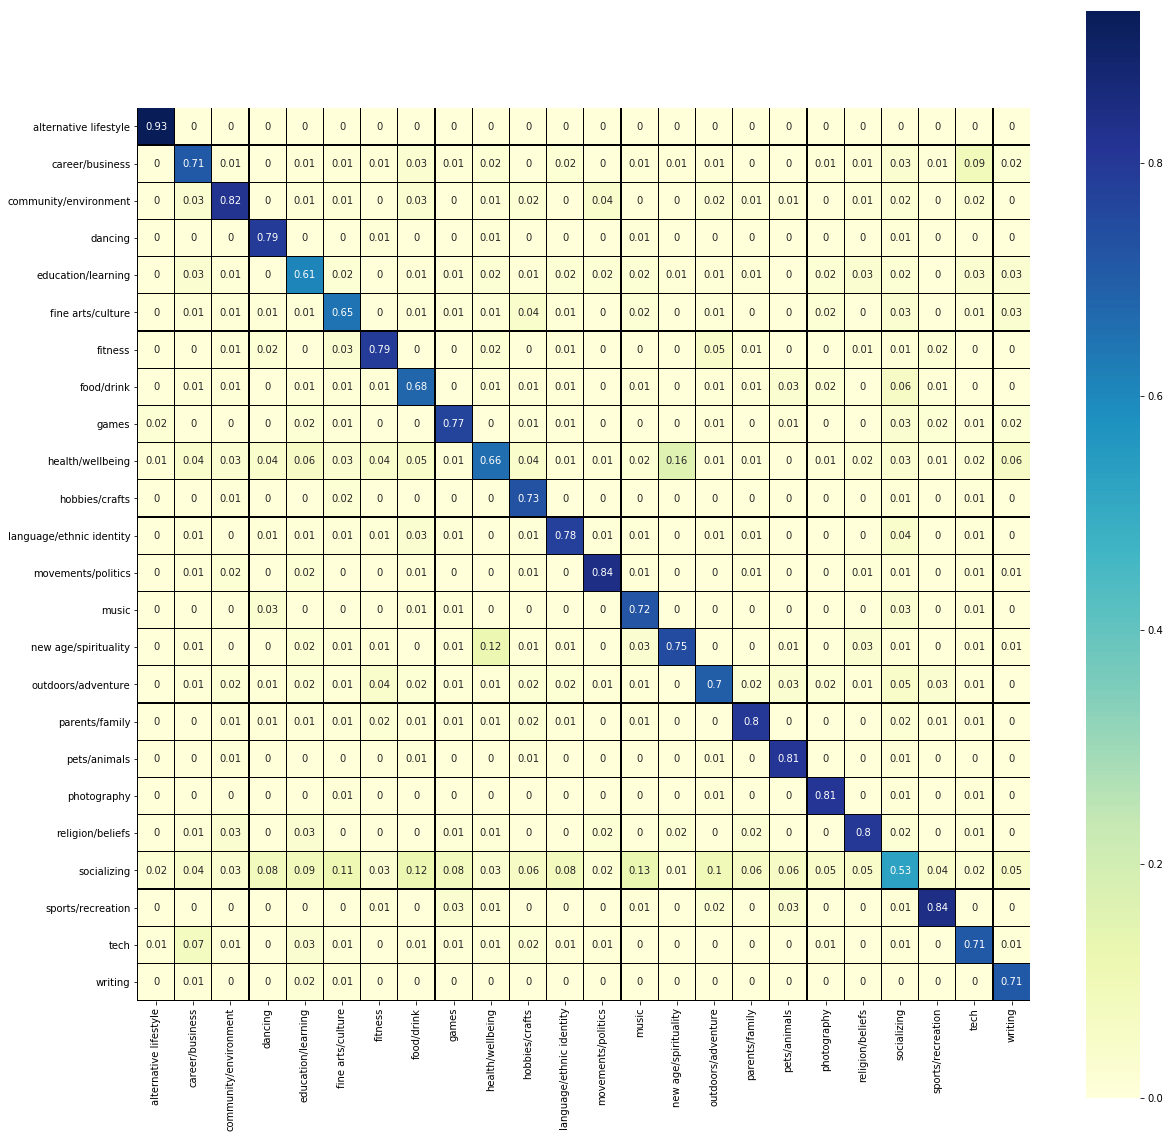

precision-way confusion matrix


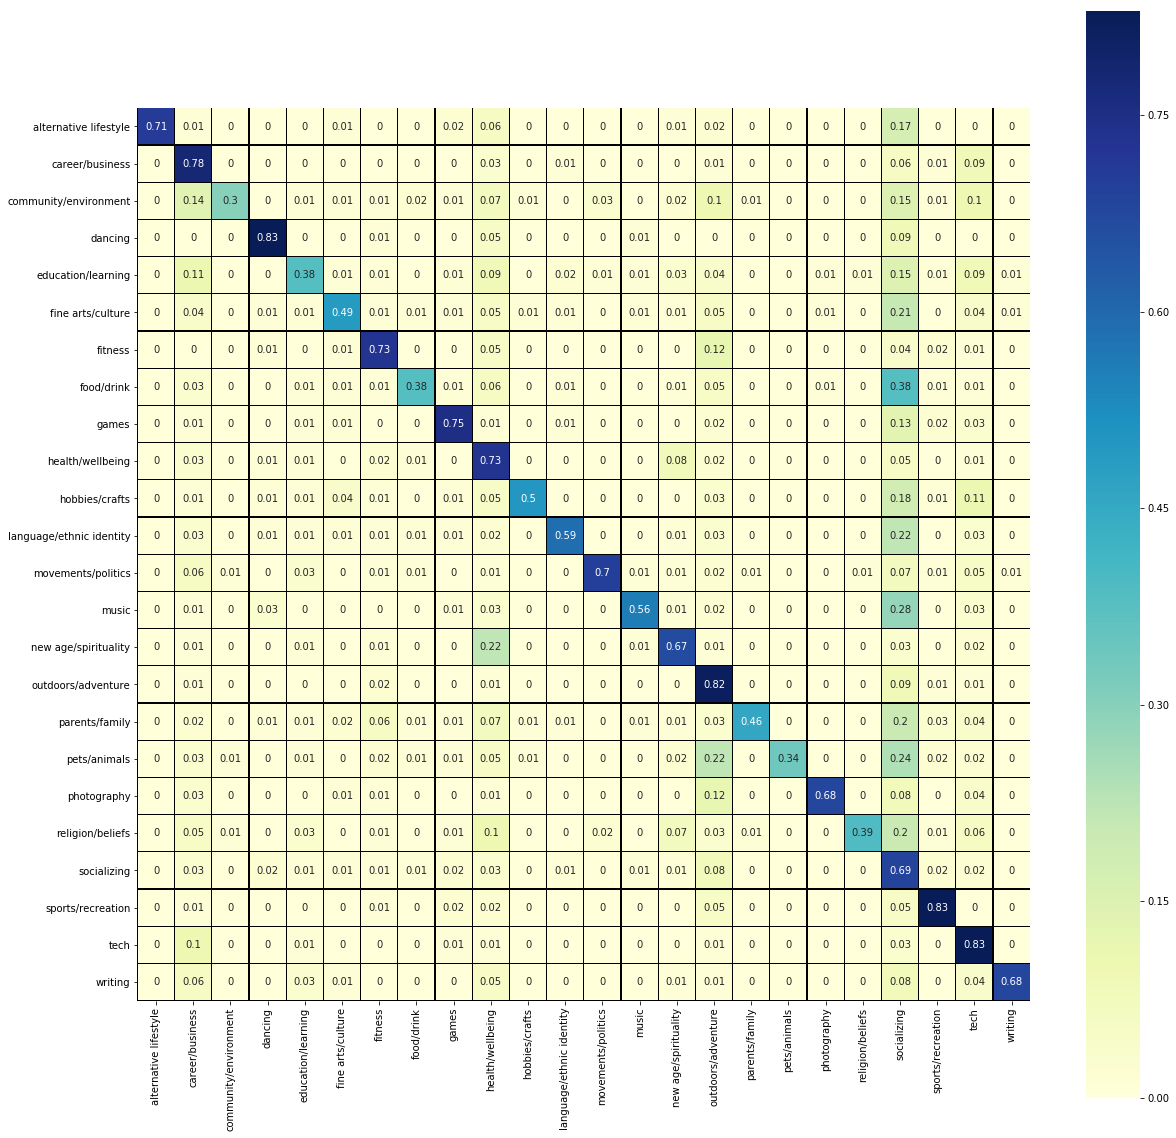

CPU times: user 30min 58s, sys: 9.47 s, total: 31min 8s
Wall time: 1min 17s


In [361]:
%%time
count_model_desc_stemm_no_badwords, score = run_experiment(df.desc_stemm_no_badwords, df.remap_category_label, 
               mode = "count", max_features=5000, 
               param_grid = None, print_classification_report = True, show_confusion_matrix = True, le = l,
            
                                                           
               verbose = True, random_search=False, params = None)

extracting tf-idf features...
tf-idf features shape:	(120809, 5000)
Classifying with Random Forest...
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=35, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)
Starting to fit


[Parallel(n_jobs=35)]: Using backend ThreadingBackend with 35 concurrent workers.
[Parallel(n_jobs=35)]: Done 100 out of 100 | elapsed:   55.8s finished
[Parallel(n_jobs=35)]: Using backend ThreadingBackend with 35 concurrent workers.


Scoring


[Parallel(n_jobs=35)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=35)]: Using backend ThreadingBackend with 35 concurrent workers.


Test score:	0.691209336975416


[Parallel(n_jobs=35)]: Done 100 out of 100 | elapsed:    0.2s finished


                          precision    recall  f1-score   support

   alternative lifestyle      0.951     0.706     0.811       109
         career/business      0.719     0.763     0.741      2214
   community/environment      0.813     0.310     0.448       449
                 dancing      0.789     0.818     0.803       643
      education/learning      0.602     0.400     0.481       647
       fine arts/culture      0.673     0.510     0.581       537
                 fitness      0.806     0.722     0.762      1286
              food/drink      0.681     0.358     0.469       684
                   games      0.762     0.744     0.753       915
        health/wellbeing      0.665     0.740     0.700      2638
          hobbies/crafts      0.794     0.469     0.590       262
language/ethnic identity      0.791     0.588     0.674       854
      movements/politics      0.840     0.680     0.751       387
                   music      0.726     0.505     0.596       493
    new a

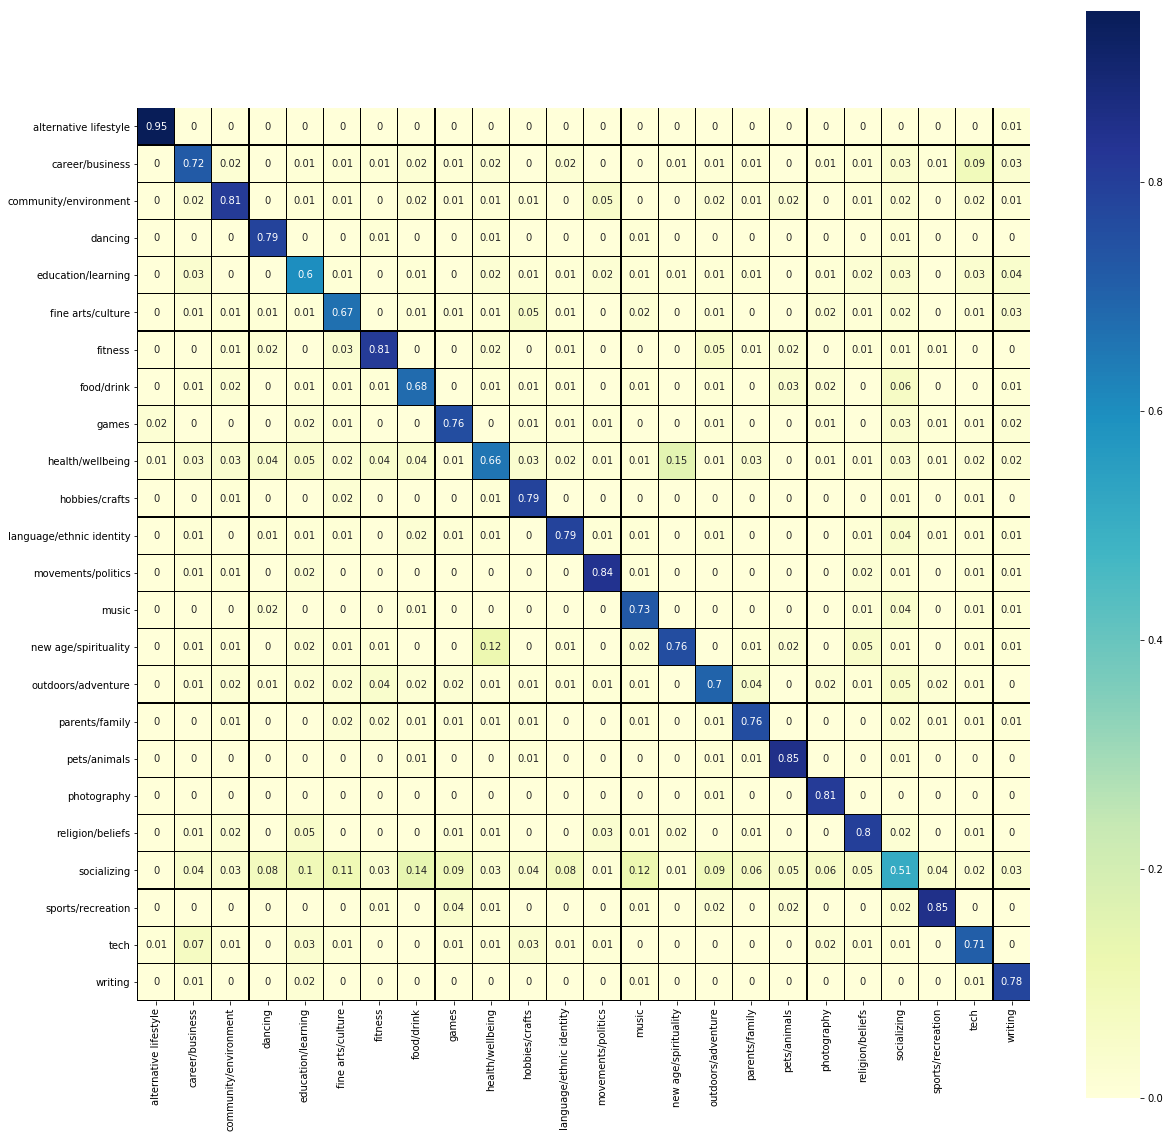

precision-way confusion matrix


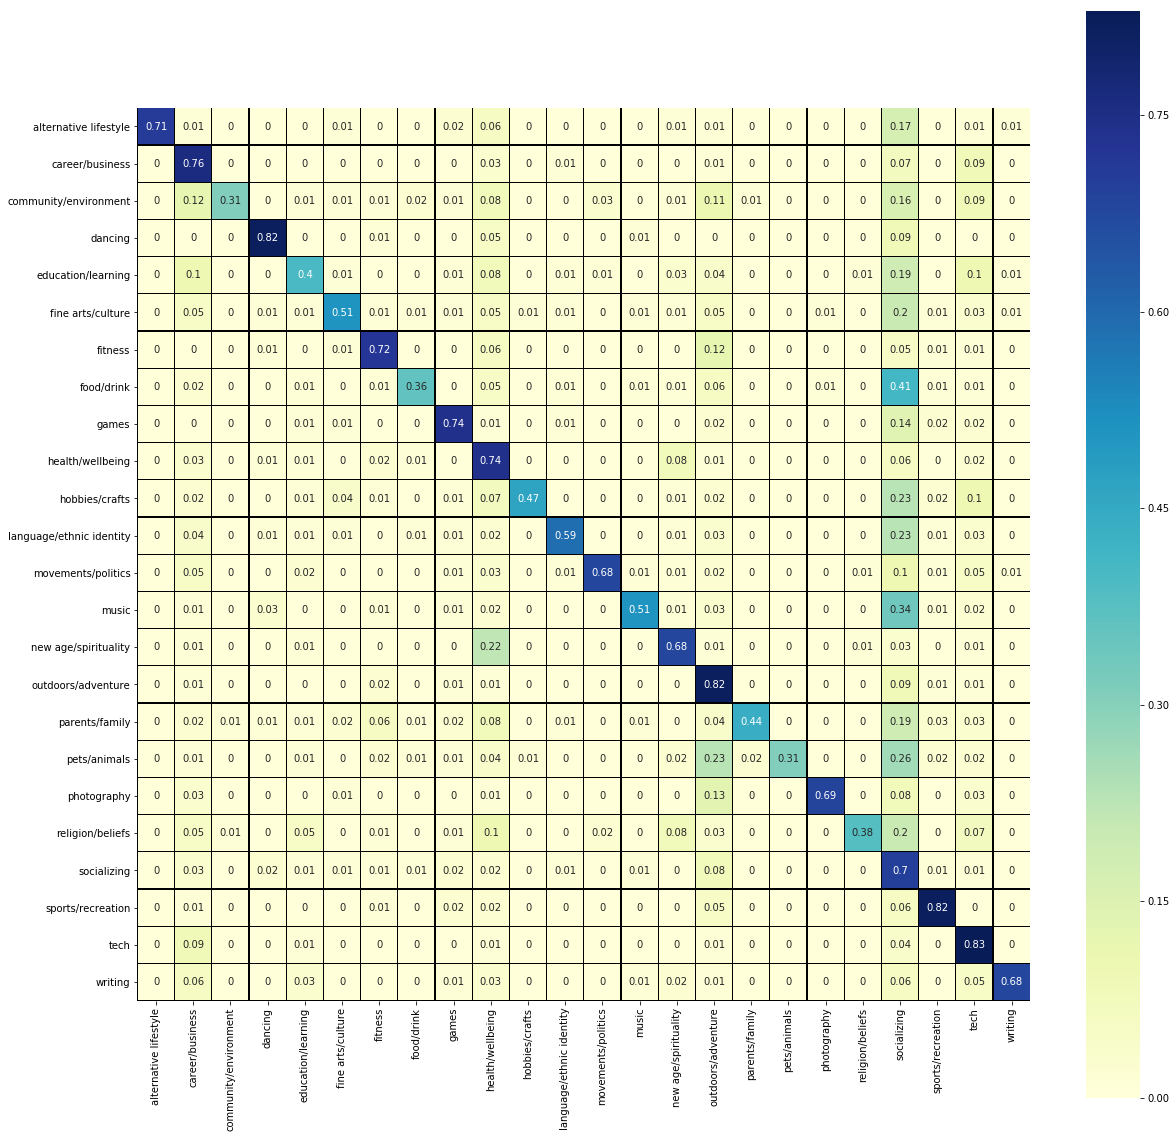

CPU times: user 29min 59s, sys: 8.45 s, total: 30min 7s
Wall time: 1min 15s


In [362]:
%%time
count_model_desc_stemm_no_badwords, score = run_experiment(df.desc_stemm_no_badwords, df.remap_category_label, 
               mode = "tfidf", max_features=5000, 
               param_grid = None, print_classification_report = True, show_confusion_matrix = True, le = l,
            
                                                           
               verbose = True, random_search=False, params = None)

## Complete Re-testing with mapped categories
## TF-IDF

extracting tf-idf features...
tf-idf features shape:	(120809, 5000)
Classifying with Random Forest...
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=35, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)
Starting to fit


[Parallel(n_jobs=35)]: Using backend ThreadingBackend with 35 concurrent workers.
[Parallel(n_jobs=35)]: Done 100 out of 100 | elapsed:   57.6s finished
[Parallel(n_jobs=35)]: Using backend ThreadingBackend with 35 concurrent workers.


Scoring


[Parallel(n_jobs=35)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=35)]: Using backend ThreadingBackend with 35 concurrent workers.


Test score:	0.6883122258091218


[Parallel(n_jobs=35)]: Done 100 out of 100 | elapsed:    0.2s finished


                          precision    recall  f1-score   support

   alternative lifestyle      0.951     0.706     0.811       109
         career/business      0.714     0.766     0.739      2214
   community/environment      0.836     0.307     0.450       449
                 dancing      0.797     0.820     0.808       643
      education/learning      0.640     0.402     0.494       647
       fine arts/culture      0.675     0.480     0.561       537
                 fitness      0.813     0.723     0.765      1286
              food/drink      0.704     0.348     0.466       684
                   games      0.764     0.752     0.758       915
        health/wellbeing      0.653     0.734     0.691      2638
          hobbies/crafts      0.784     0.458     0.578       262
language/ethnic identity      0.780     0.576     0.663       854
      movements/politics      0.858     0.669     0.752       387
                   music      0.762     0.499     0.603       493
    new a

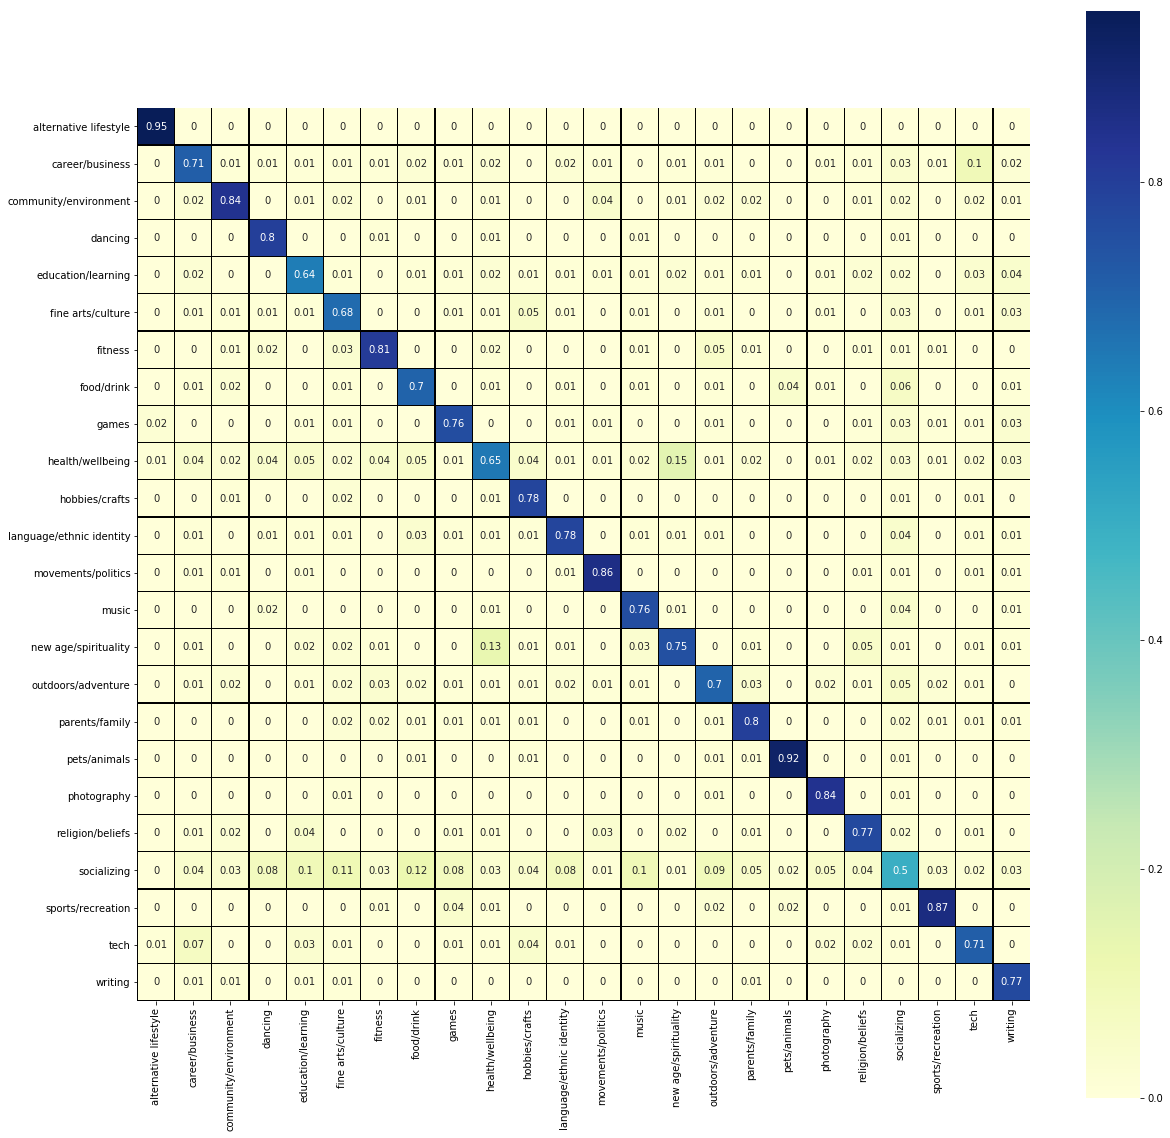

precision-way confusion matrix


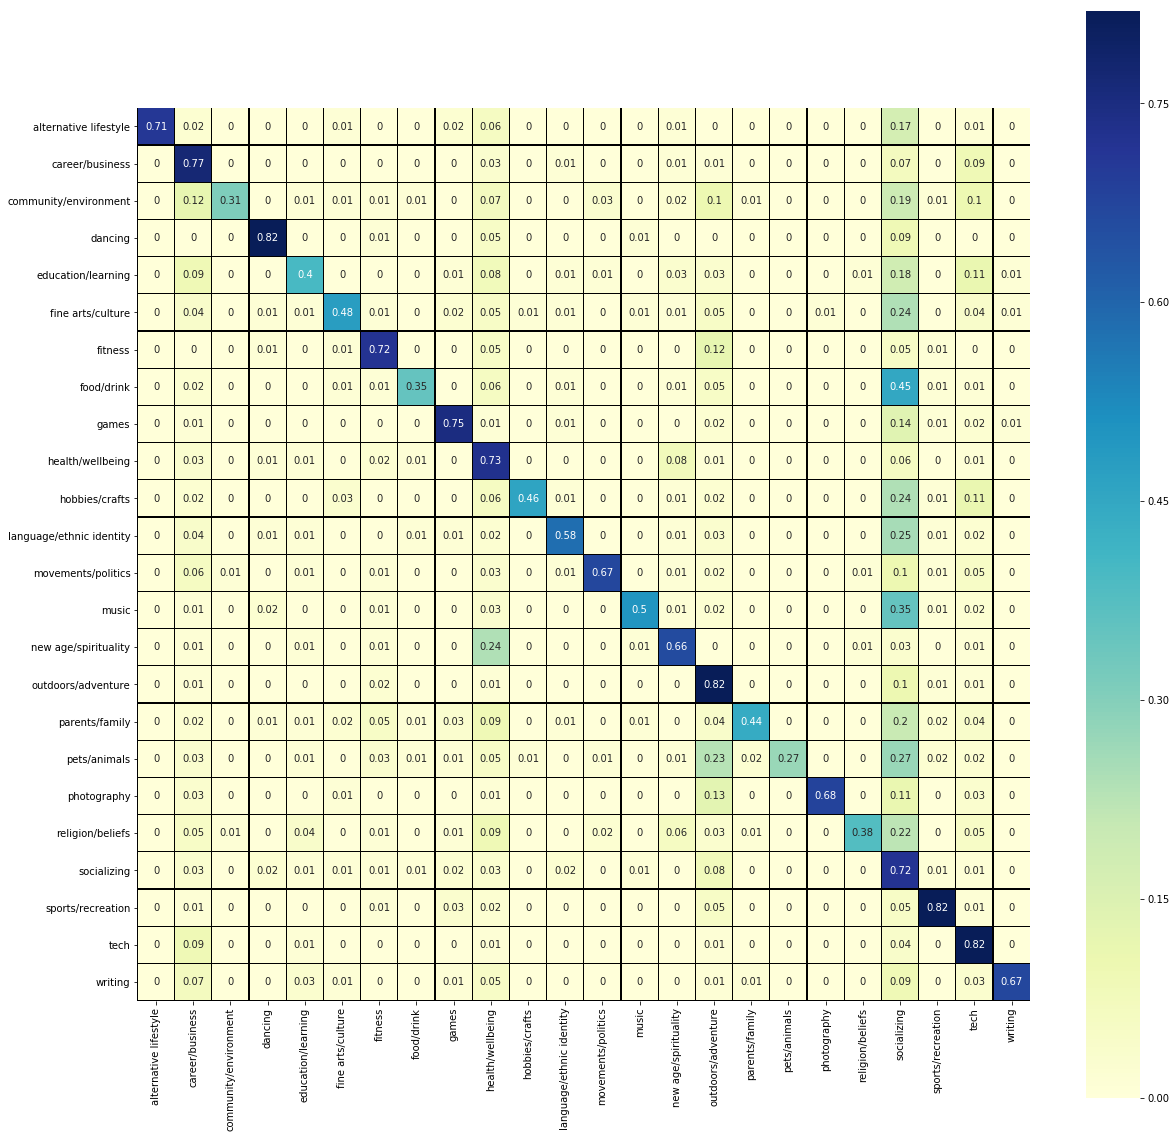

CPU times: user 31min 23s, sys: 8.71 s, total: 31min 31s
Wall time: 1min 19s


In [365]:
%%time
model_desc_lemm, score = run_experiment(df.desc_lemm, df.remap_category_label, 
               mode = "tfidf", max_features=5000, 
               param_grid = None, print_classification_report = True, show_confusion_matrix = True, le = l,
               verbose = True, random_search=False, params = None)

extracting tf-idf features...
tf-idf features shape:	(120809, 5000)
Classifying with Random Forest...
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=35, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)
Starting to fit


[Parallel(n_jobs=35)]: Using backend ThreadingBackend with 35 concurrent workers.
[Parallel(n_jobs=35)]: Done 100 out of 100 | elapsed:   54.6s finished
[Parallel(n_jobs=35)]: Using backend ThreadingBackend with 35 concurrent workers.


Scoring


[Parallel(n_jobs=35)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=35)]: Using backend ThreadingBackend with 35 concurrent workers.


Test score:	0.688395000413873


[Parallel(n_jobs=35)]: Done 100 out of 100 | elapsed:    0.2s finished


                          precision    recall  f1-score   support

   alternative lifestyle      0.951     0.706     0.811       109
         career/business      0.712     0.766     0.738      2214
   community/environment      0.793     0.307     0.443       449
                 dancing      0.797     0.813     0.805       643
      education/learning      0.611     0.382     0.470       647
       fine arts/culture      0.693     0.501     0.582       537
                 fitness      0.804     0.720     0.760      1286
              food/drink      0.693     0.367     0.480       684
                   games      0.751     0.753     0.752       915
        health/wellbeing      0.649     0.730     0.687      2638
          hobbies/crafts      0.813     0.481     0.604       262
language/ethnic identity      0.788     0.582     0.669       854
      movements/politics      0.845     0.674     0.750       387
                   music      0.741     0.505     0.601       493
    new a

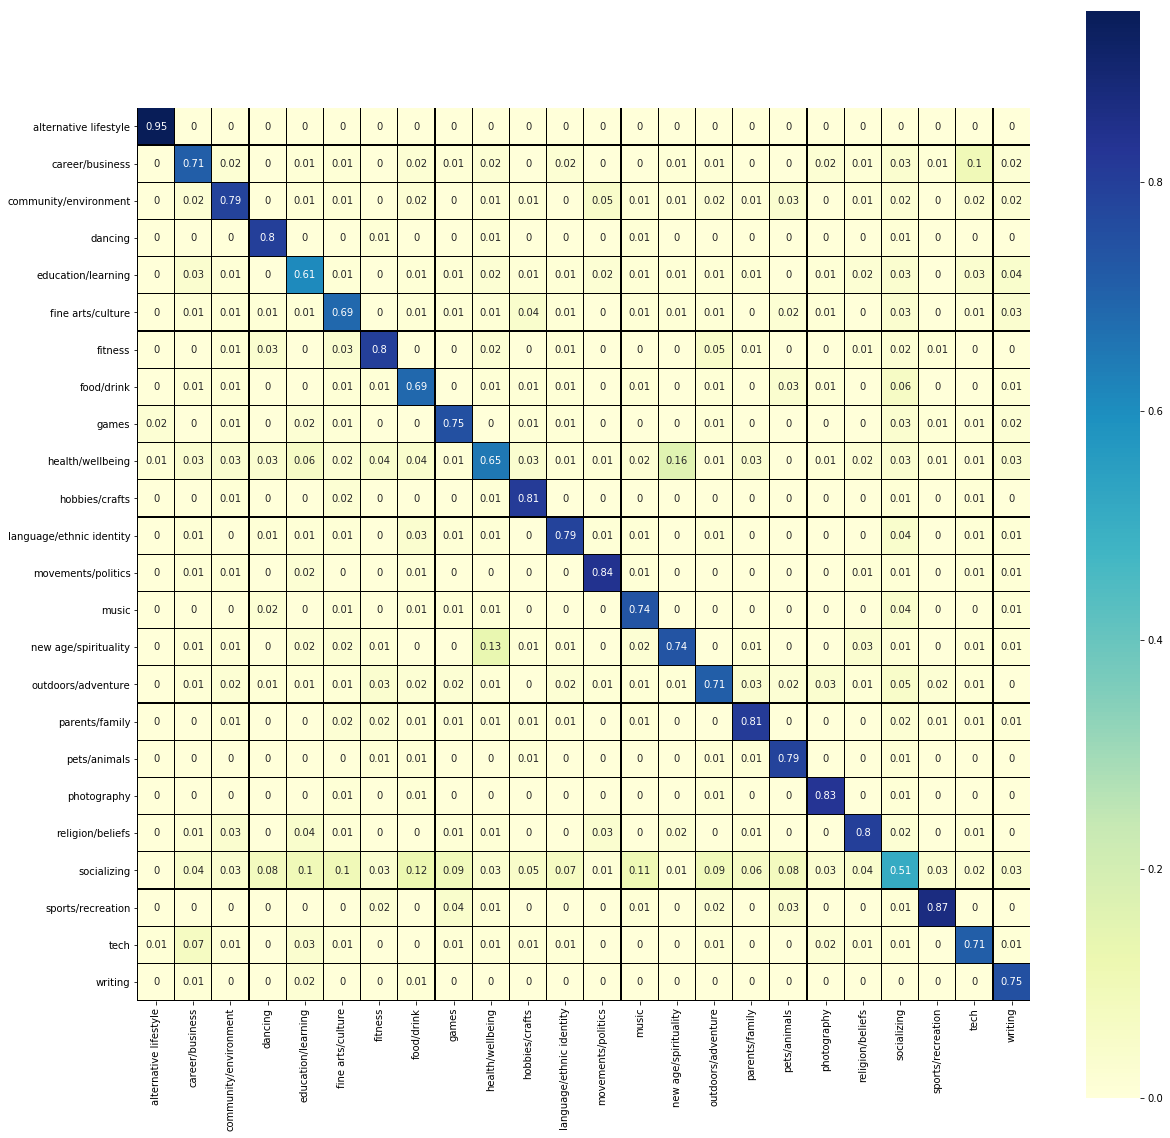

precision-way confusion matrix


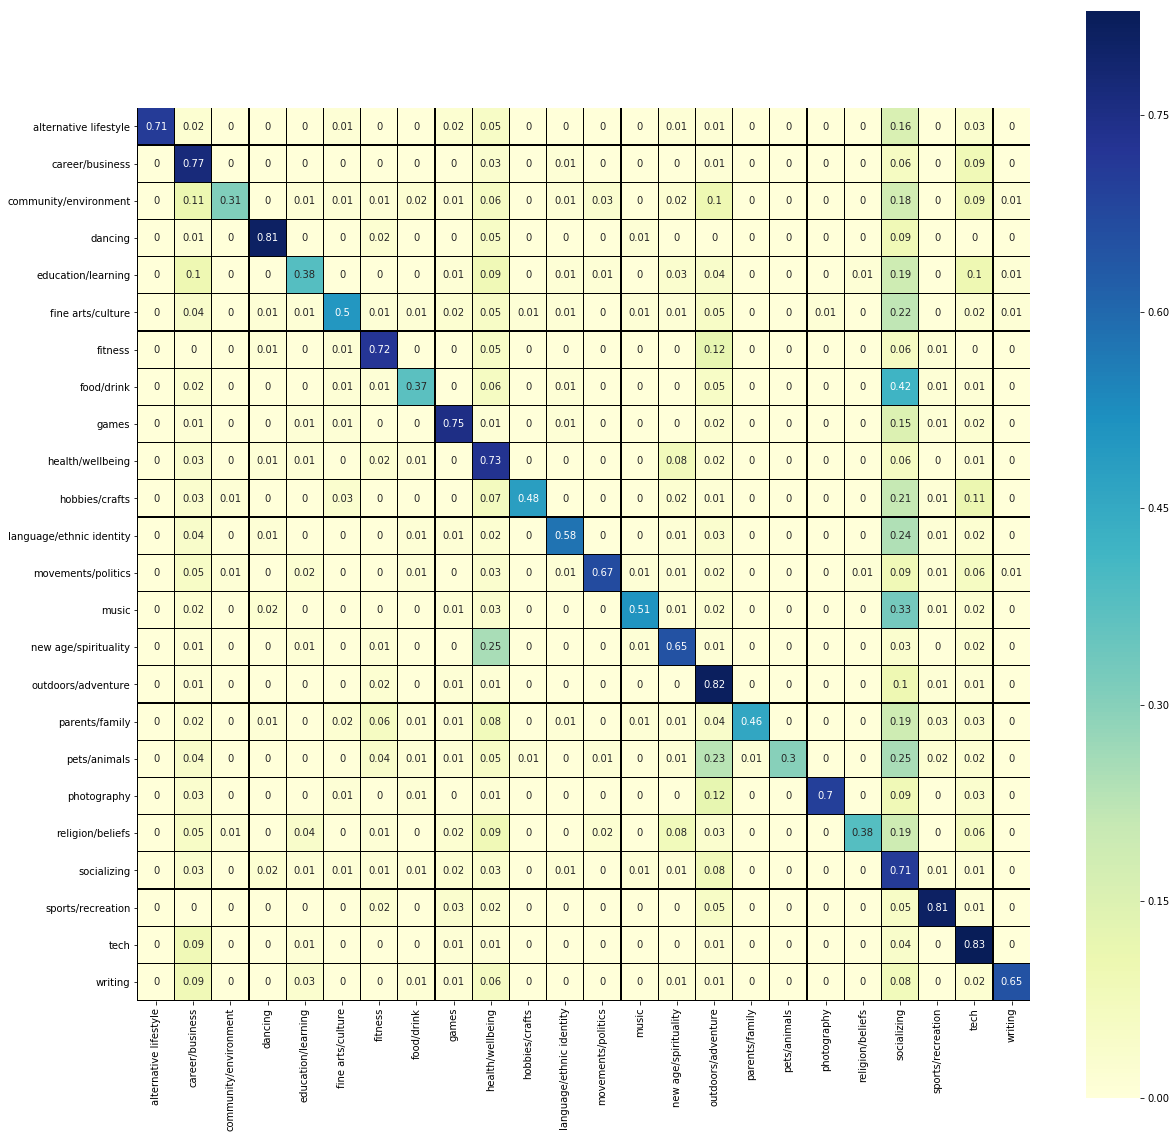

CPU times: user 29min 56s, sys: 8.72 s, total: 30min 4s
Wall time: 1min 14s


In [366]:
%%time
model_desc_lemm_no_badwords, score = run_experiment(df.desc_lemm_no_badwords, df.remap_category_label, 
               mode = "tfidf", max_features=5000, 
               param_grid = None, print_classification_report = True, show_confusion_matrix = True, le = l,
               verbose = True, random_search=False, params = None)

extracting tf-idf features...
tf-idf features shape:	(120809, 5000)
Classifying with Random Forest...
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=35, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)
Starting to fit


[Parallel(n_jobs=35)]: Using backend ThreadingBackend with 35 concurrent workers.
[Parallel(n_jobs=35)]: Done 100 out of 100 | elapsed:   56.7s finished


Scoring


[Parallel(n_jobs=35)]: Using backend ThreadingBackend with 35 concurrent workers.
[Parallel(n_jobs=35)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=35)]: Using backend ThreadingBackend with 35 concurrent workers.


Test score:	0.68918135915901


[Parallel(n_jobs=35)]: Done 100 out of 100 | elapsed:    0.2s finished


                          precision    recall  f1-score   support

   alternative lifestyle      0.951     0.706     0.811       109
         career/business      0.714     0.765     0.739      2214
   community/environment      0.829     0.292     0.432       449
                 dancing      0.801     0.813     0.807       643
      education/learning      0.633     0.394     0.486       647
       fine arts/culture      0.664     0.479     0.556       537
                 fitness      0.803     0.719     0.759      1286
              food/drink      0.701     0.354     0.470       684
                   games      0.776     0.743     0.759       915
        health/wellbeing      0.660     0.733     0.695      2638
          hobbies/crafts      0.795     0.443     0.569       262
language/ethnic identity      0.802     0.588     0.678       854
      movements/politics      0.864     0.687     0.765       387
                   music      0.748     0.481     0.585       493
    new a

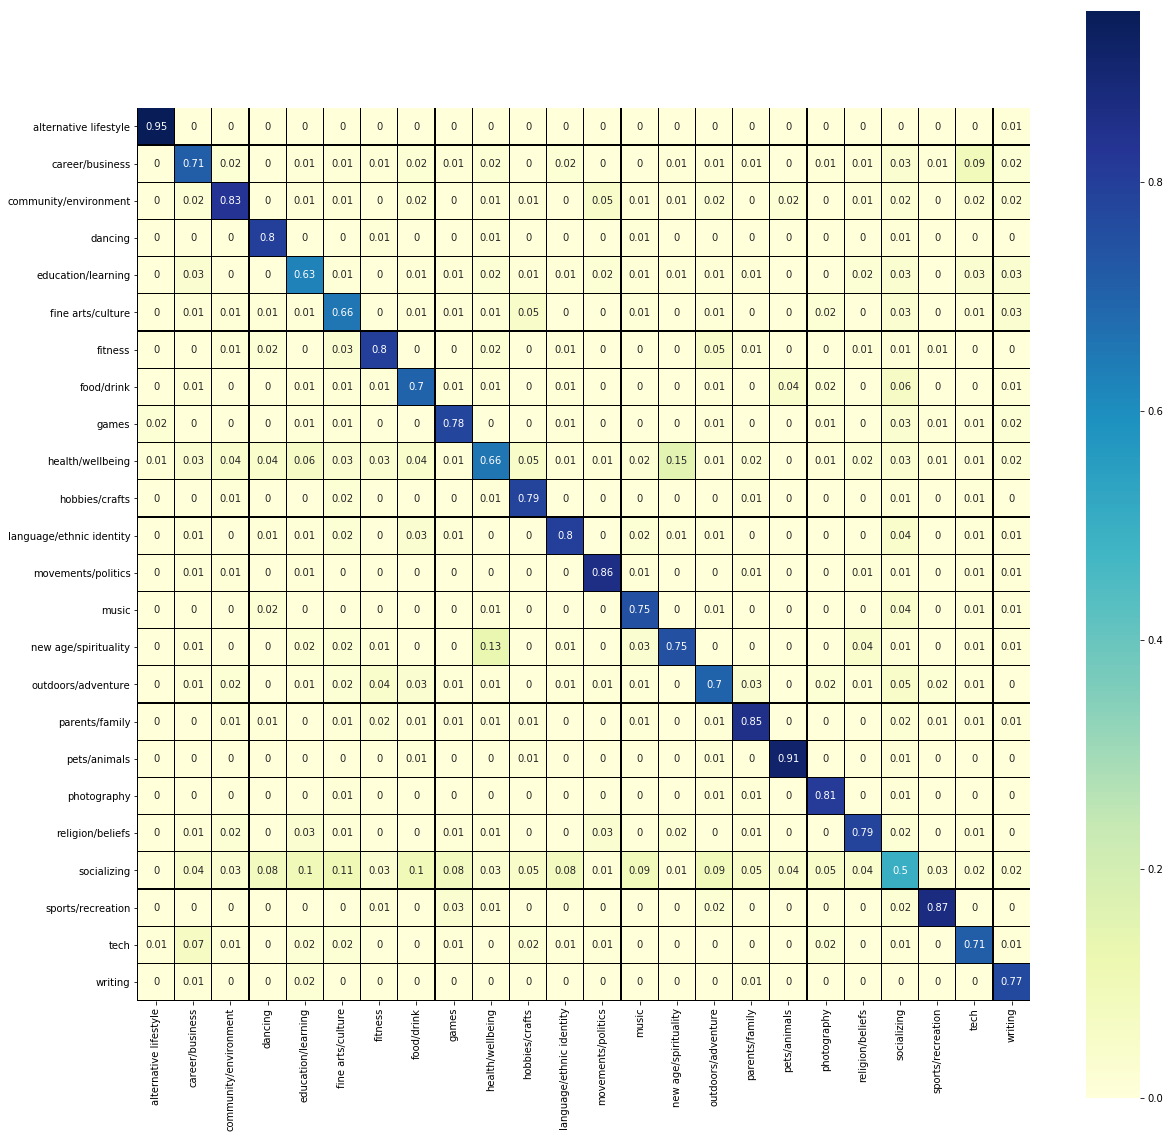

precision-way confusion matrix


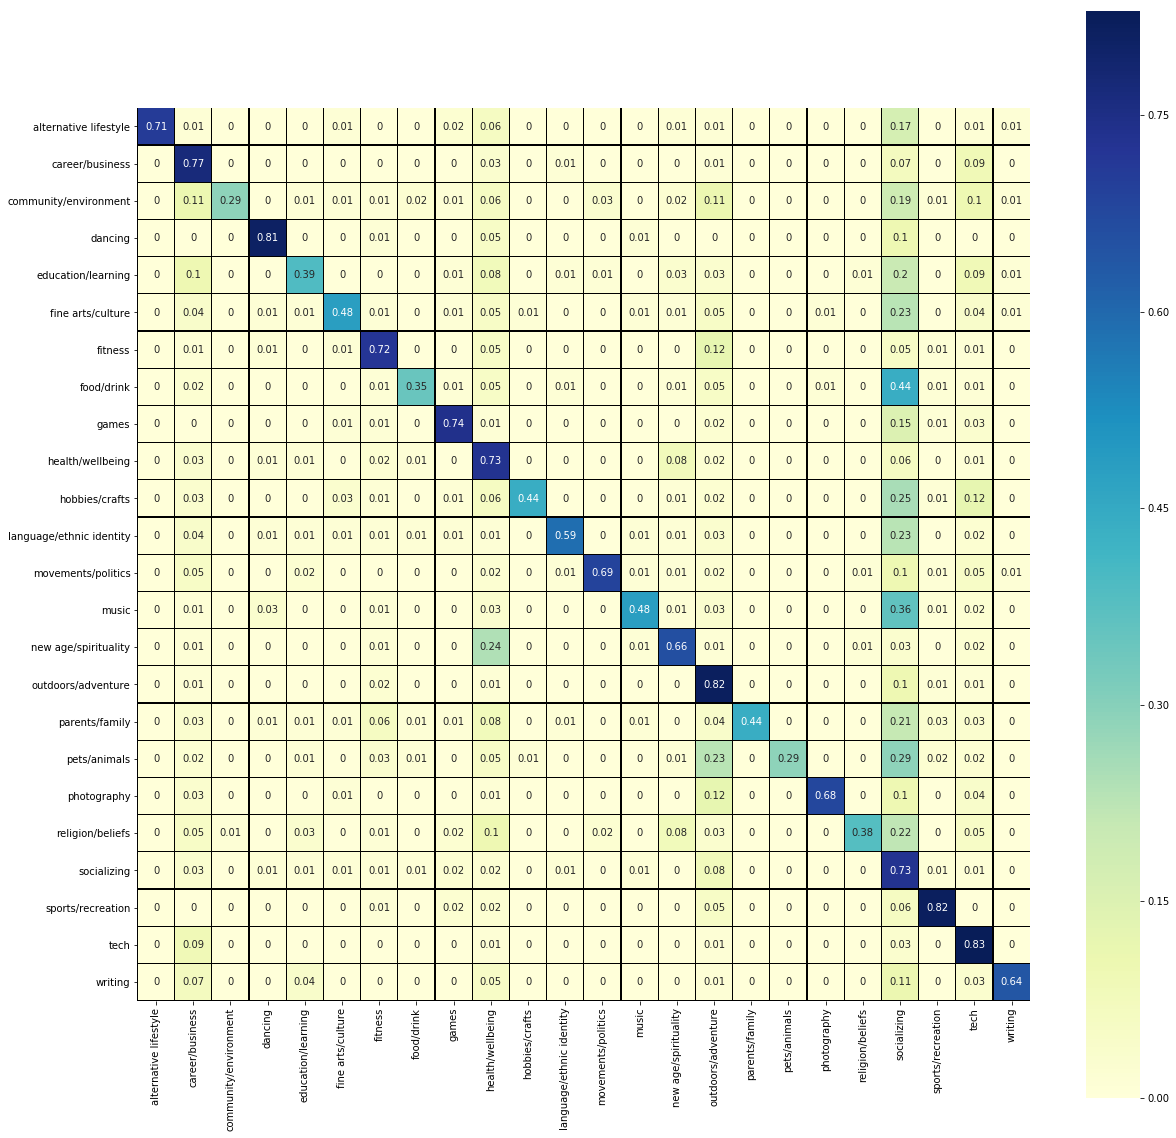

CPU times: user 30min 55s, sys: 8.09 s, total: 31min 3s
Wall time: 1min 17s


In [367]:
%%time
model_desc_stemm, score = run_experiment(df.desc_stemm, df.remap_category_label, 
               mode = "tfidf", max_features=5000, 
               param_grid = None, print_classification_report = True, show_confusion_matrix = True, le = l,
               verbose = True, random_search=False, params = None)

extracting tf-idf features...
tf-idf features shape:	(120809, 5000)
Classifying with Random Forest...
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=35, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)
Starting to fit


[Parallel(n_jobs=35)]: Using backend ThreadingBackend with 35 concurrent workers.
[Parallel(n_jobs=35)]: Done 100 out of 100 | elapsed:   54.7s finished
[Parallel(n_jobs=35)]: Using backend ThreadingBackend with 35 concurrent workers.


Scoring


[Parallel(n_jobs=35)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=35)]: Using backend ThreadingBackend with 35 concurrent workers.


Test score:	0.6907954639516596


[Parallel(n_jobs=35)]: Done 100 out of 100 | elapsed:    0.2s finished


                          precision    recall  f1-score   support

   alternative lifestyle      0.951     0.706     0.811       109
         career/business      0.718     0.771     0.744      2214
   community/environment      0.785     0.301     0.435       449
                 dancing      0.796     0.827     0.812       643
      education/learning      0.596     0.393     0.473       647
       fine arts/culture      0.674     0.512     0.582       537
                 fitness      0.803     0.717     0.758      1286
              food/drink      0.666     0.358     0.466       684
                   games      0.788     0.748     0.767       915
        health/wellbeing      0.657     0.735     0.694      2638
          hobbies/crafts      0.801     0.477     0.598       262
language/ethnic identity      0.798     0.588     0.677       854
      movements/politics      0.846     0.695     0.763       387
                   music      0.720     0.511     0.598       493
    new a

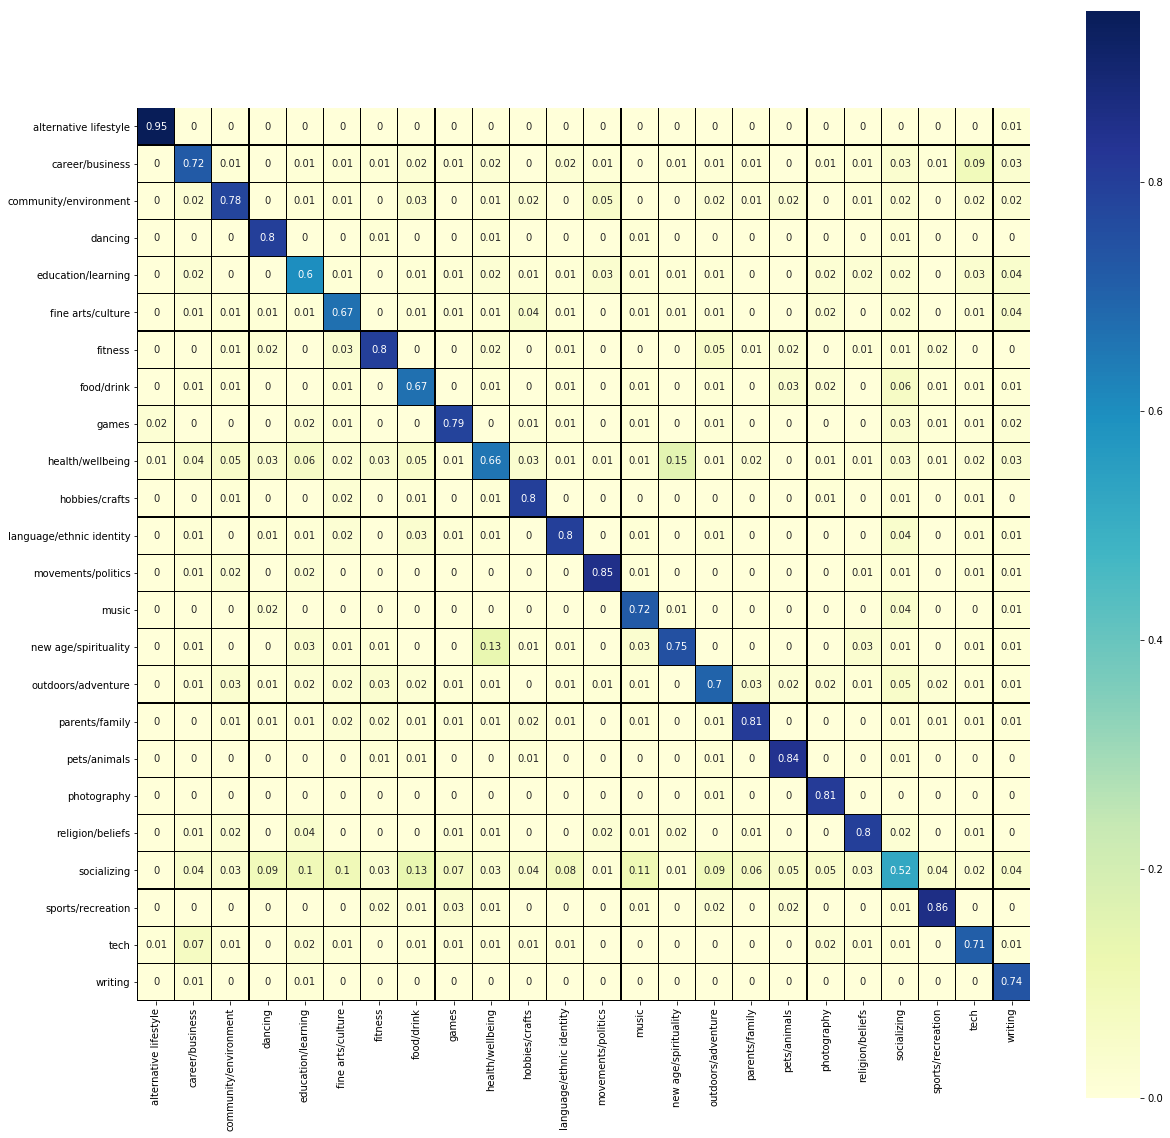

precision-way confusion matrix


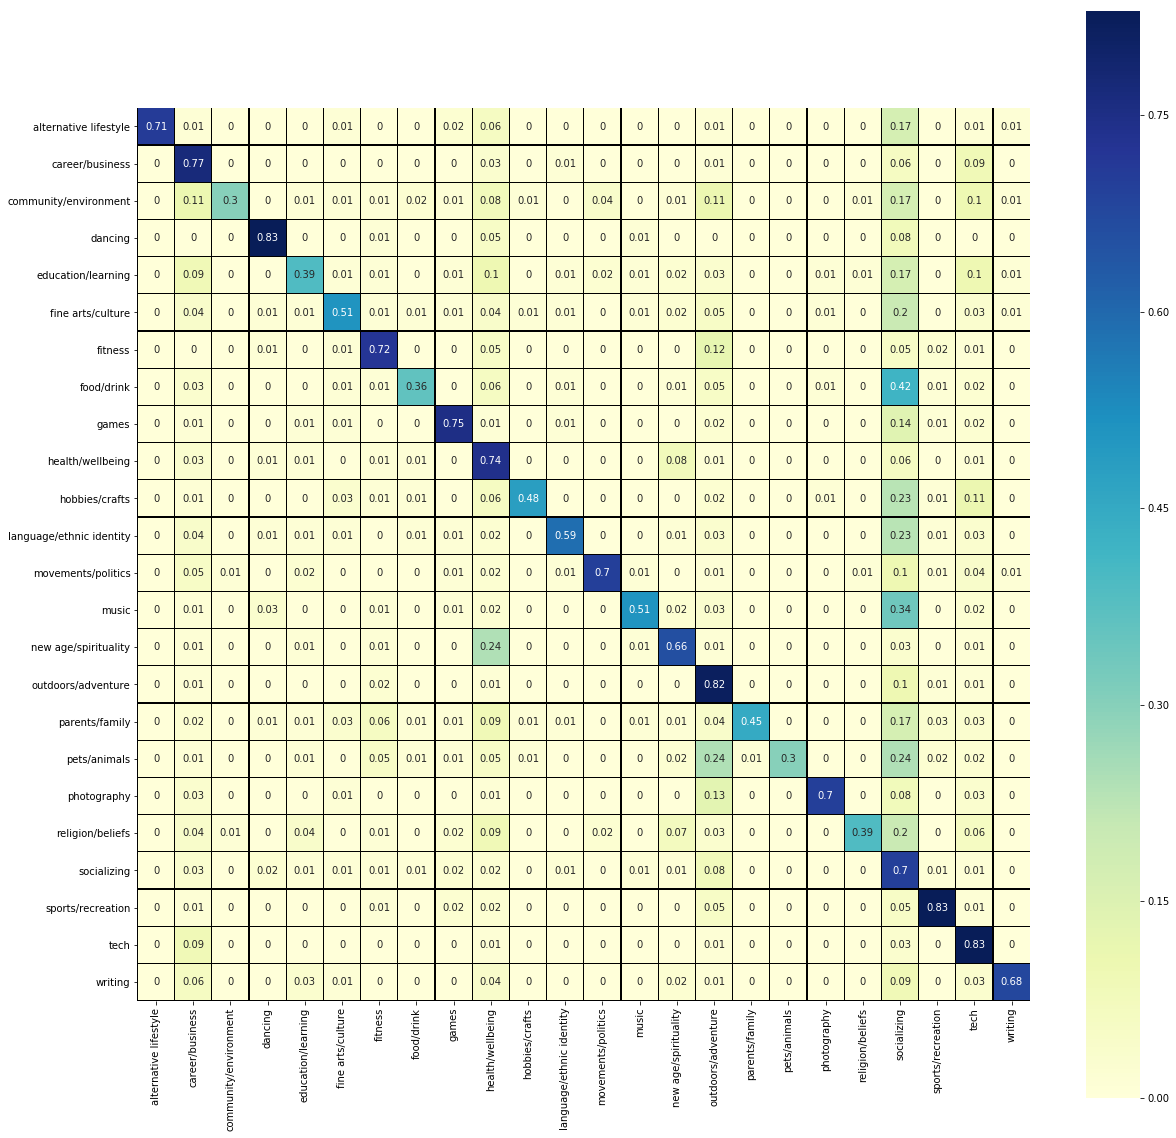

CPU times: user 29min 43s, sys: 8.35 s, total: 29min 51s
Wall time: 1min 13s


In [368]:
%%time
model_desc_stemm_no_badwords, score = run_experiment(df.desc_stemm_no_badwords, df.remap_category_label, 
               mode = "tfidf", max_features=5000, 
               param_grid = None, print_classification_report = True, show_confusion_matrix = True, le = l,
               verbose = True, random_search=False, params = None)

## Count Vectorizer

extracting count-resulting features...
count-vect features shape:	(120809, 5000)
Classifying with Random Forest...
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=35, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)
Starting to fit


[Parallel(n_jobs=35)]: Using backend ThreadingBackend with 35 concurrent workers.
[Parallel(n_jobs=35)]: Done 100 out of 100 | elapsed:   59.6s finished
[Parallel(n_jobs=35)]: Using backend ThreadingBackend with 35 concurrent workers.


Scoring


[Parallel(n_jobs=35)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=35)]: Using backend ThreadingBackend with 35 concurrent workers.


Test score:	0.6924095687443093


[Parallel(n_jobs=35)]: Done 100 out of 100 | elapsed:    0.2s finished


                          precision    recall  f1-score   support

   alternative lifestyle      0.917     0.706     0.798       109
         career/business      0.700     0.771     0.734      2214
   community/environment      0.808     0.301     0.438       449
                 dancing      0.798     0.824     0.811       643
      education/learning      0.637     0.396     0.488       647
       fine arts/culture      0.685     0.482     0.566       537
                 fitness      0.815     0.726     0.768      1286
              food/drink      0.714     0.365     0.484       684
                   games      0.766     0.757     0.762       915
        health/wellbeing      0.659     0.735     0.694      2638
          hobbies/crafts      0.787     0.466     0.585       262
language/ethnic identity      0.788     0.582     0.669       854
      movements/politics      0.873     0.656     0.749       387
                   music      0.748     0.495     0.596       493
    new a

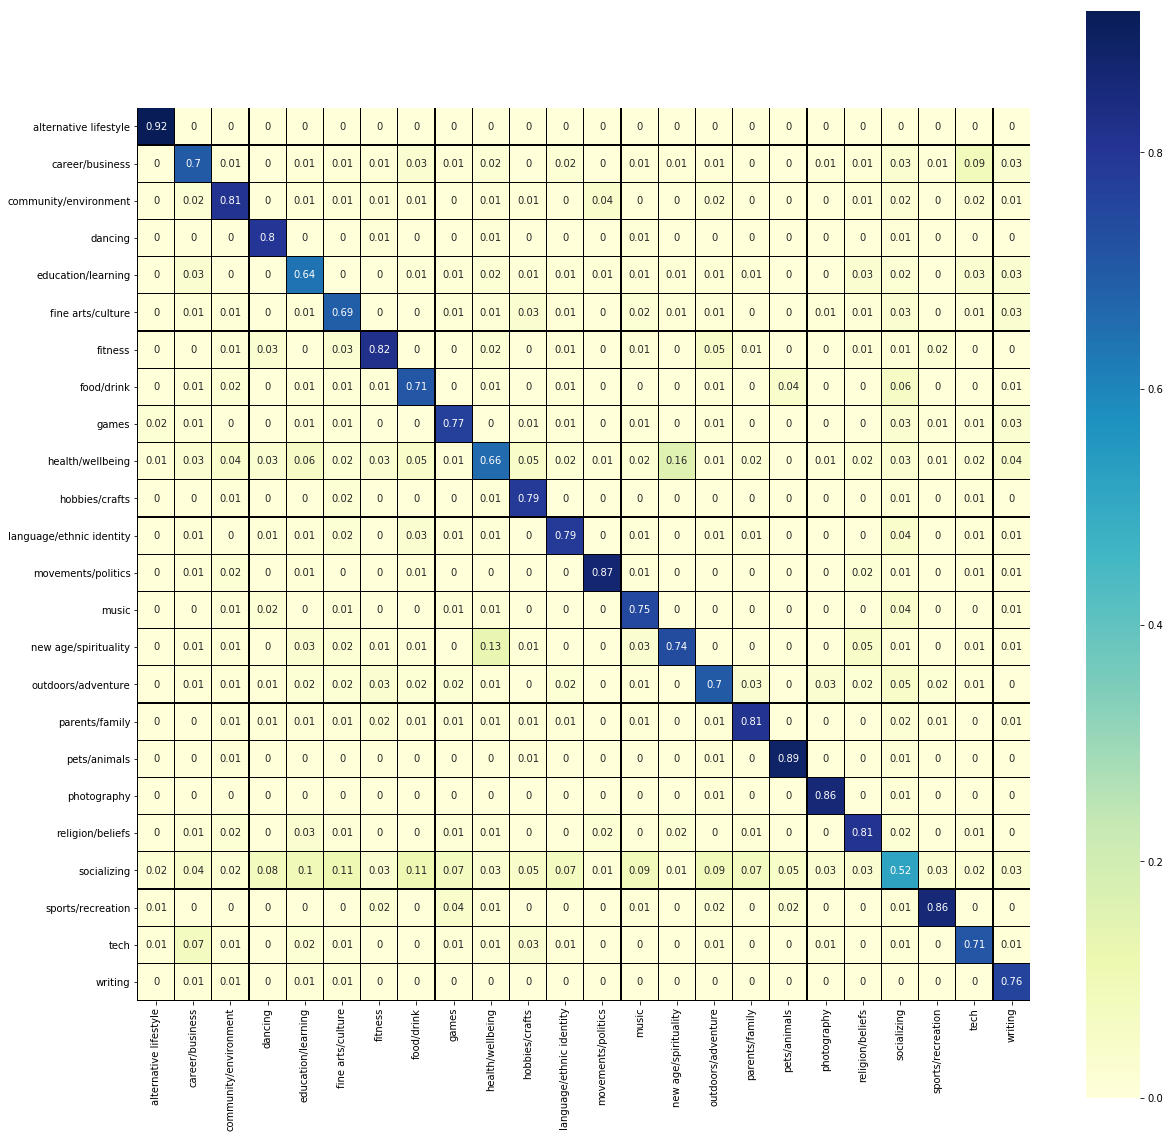

precision-way confusion matrix


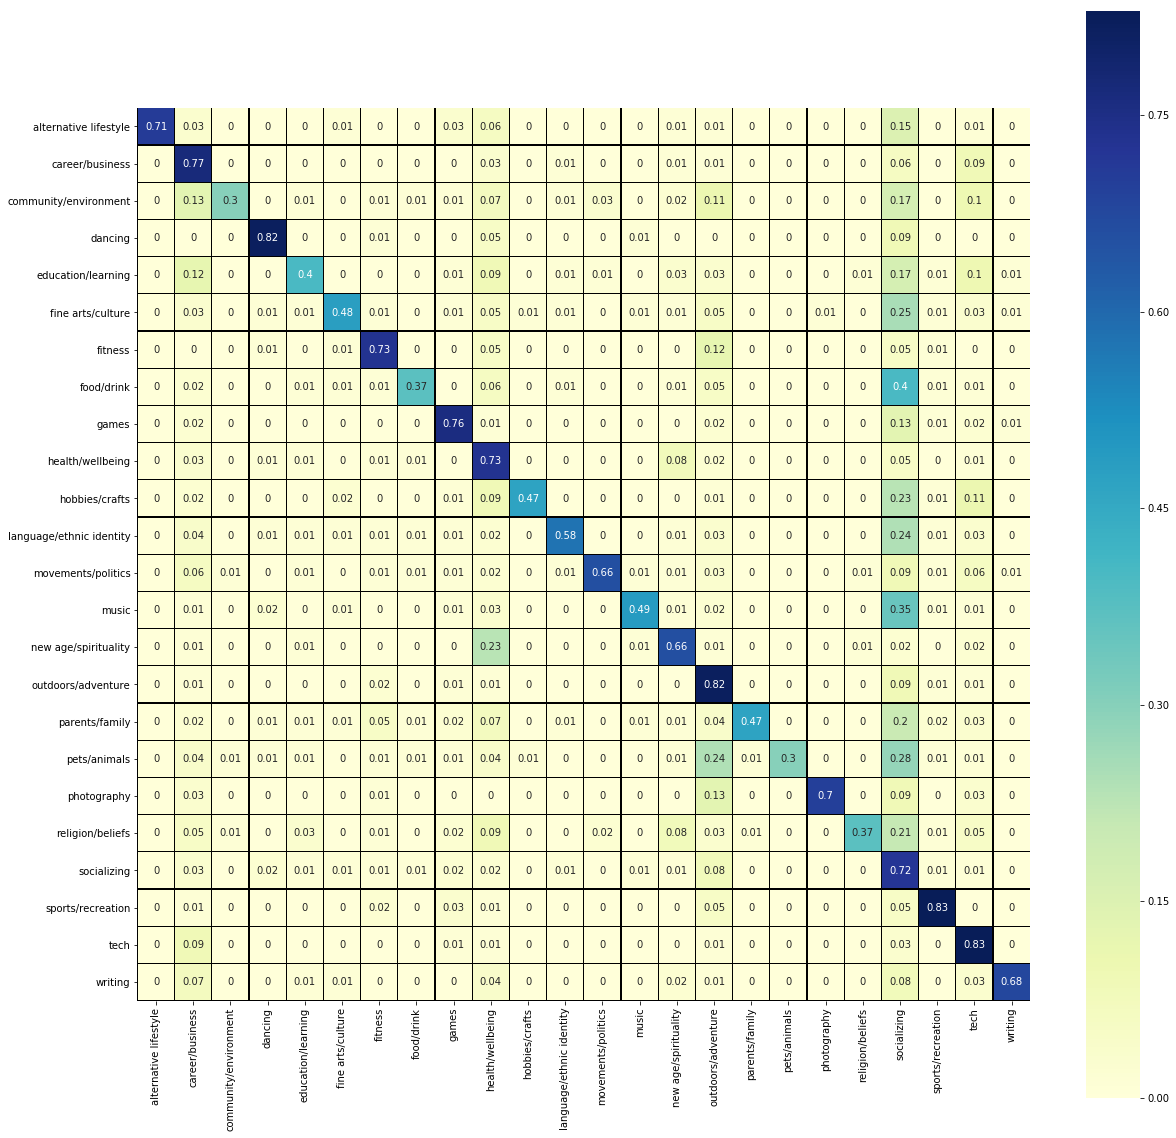

CPU times: user 32min 15s, sys: 9.83 s, total: 32min 25s
Wall time: 1min 21s


In [369]:
%%time
count_model_desc_lemm, score = run_experiment(df.desc_lemm, df.remap_category_label, 
               mode = "count", max_features=5000, 
               param_grid = None, print_classification_report = True, show_confusion_matrix = True, le = l,
               verbose = True, random_search=False, params = None)

extracting count-resulting features...
count-vect features shape:	(120809, 5000)
Classifying with Random Forest...
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=35, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)
Starting to fit


[Parallel(n_jobs=35)]: Using backend ThreadingBackend with 35 concurrent workers.
[Parallel(n_jobs=35)]: Done 100 out of 100 | elapsed:   57.1s finished
[Parallel(n_jobs=35)]: Using backend ThreadingBackend with 35 concurrent workers.


Scoring


[Parallel(n_jobs=35)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=35)]: Using backend ThreadingBackend with 35 concurrent workers.


Test score:	0.6925751179538118


[Parallel(n_jobs=35)]: Done 100 out of 100 | elapsed:    0.2s finished


                          precision    recall  f1-score   support

   alternative lifestyle      0.929     0.716     0.808       109
         career/business      0.705     0.773     0.737      2214
   community/environment      0.819     0.303     0.442       449
                 dancing      0.791     0.823     0.806       643
      education/learning      0.613     0.389     0.476       647
       fine arts/culture      0.671     0.508     0.578       537
                 fitness      0.803     0.730     0.765      1286
              food/drink      0.653     0.383     0.483       684
                   games      0.765     0.756     0.761       915
        health/wellbeing      0.656     0.729     0.691      2638
          hobbies/crafts      0.776     0.477     0.591       262
language/ethnic identity      0.782     0.589     0.672       854
      movements/politics      0.836     0.685     0.753       387
                   music      0.708     0.527     0.605       493
    new a

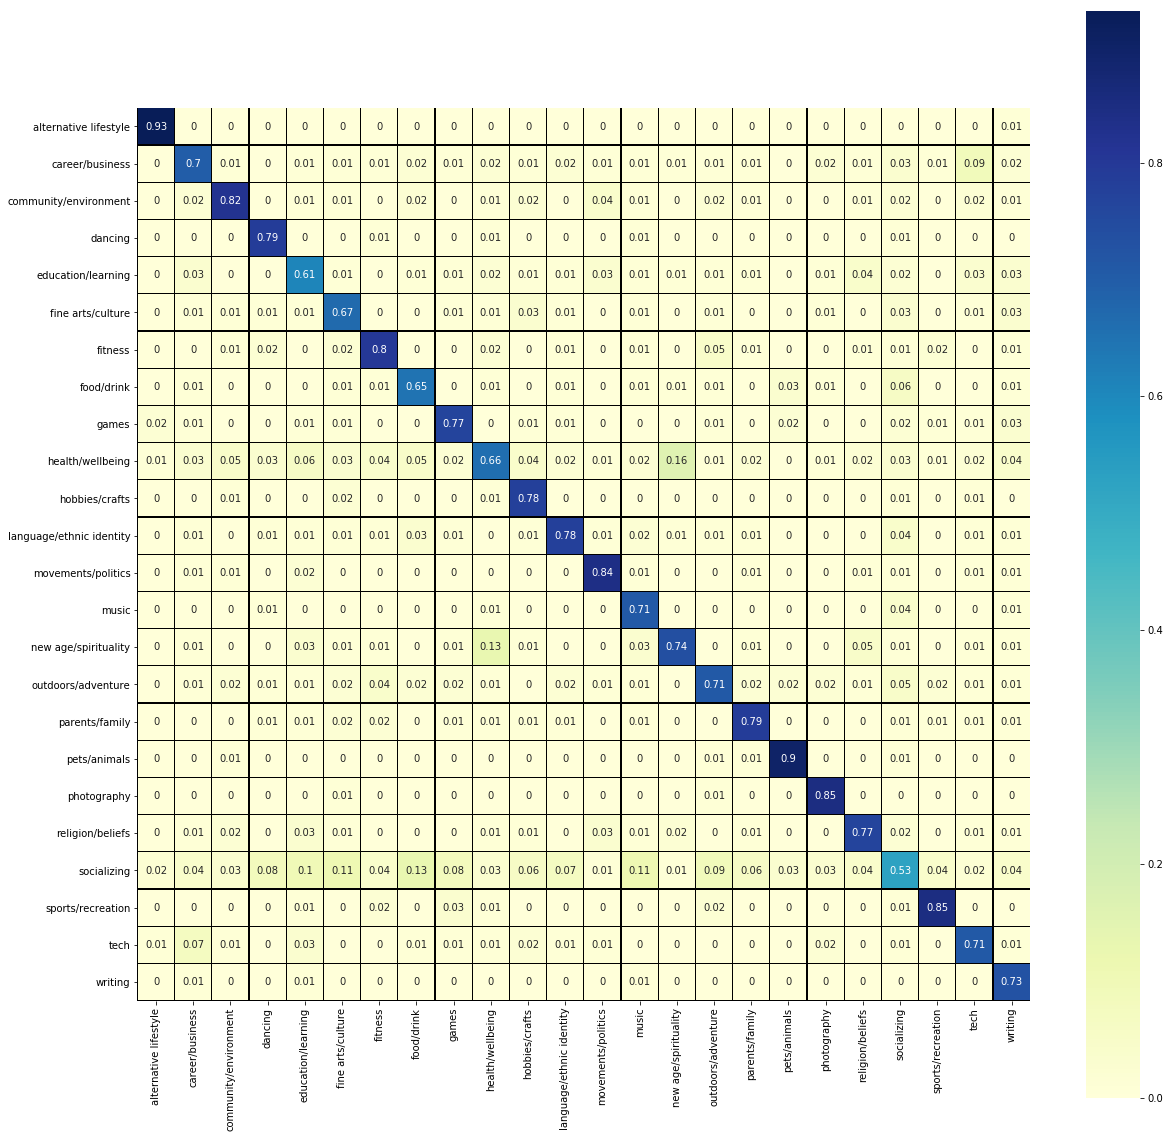

precision-way confusion matrix


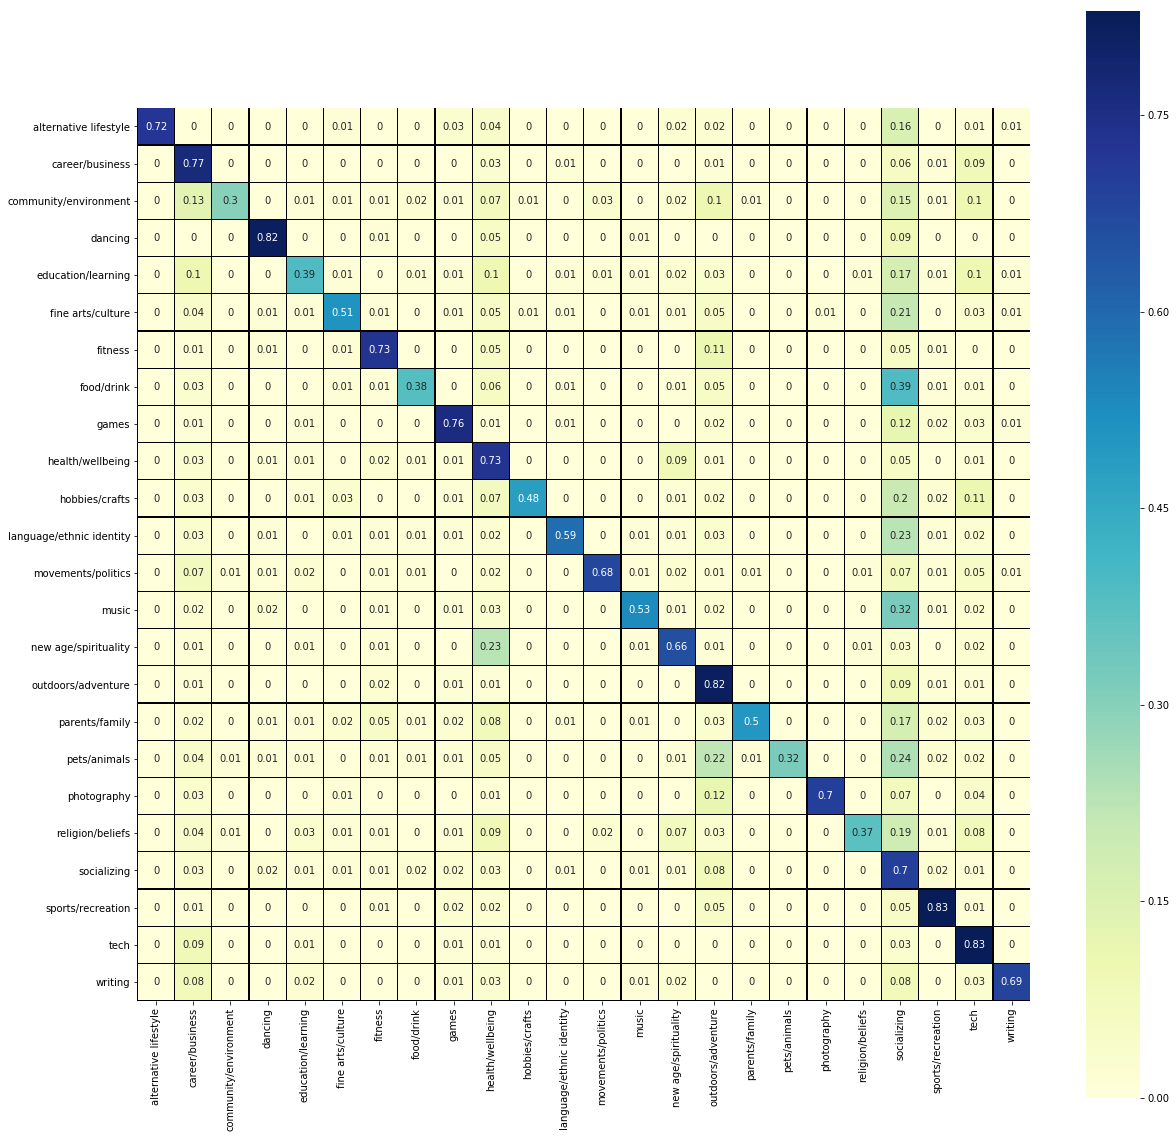

CPU times: user 31min 3s, sys: 9.28 s, total: 31min 13s
Wall time: 1min 16s


In [370]:
%%time
count_model_desc_lemm_no_badwords, score = run_experiment(df.desc_lemm_no_badwords, df.remap_category_label, 
               mode = "count", max_features=5000, 
               param_grid = None, print_classification_report = True, show_confusion_matrix = True, le = l,
               verbose = True, random_search=False, params = None)

extracting count-resulting features...
count-vect features shape:	(120809, 5000)
Classifying with Random Forest...
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=35, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)
Starting to fit


[Parallel(n_jobs=35)]: Using backend ThreadingBackend with 35 concurrent workers.
[Parallel(n_jobs=35)]: Done 100 out of 100 | elapsed:  1.0min finished
[Parallel(n_jobs=35)]: Using backend ThreadingBackend with 35 concurrent workers.


Scoring


[Parallel(n_jobs=35)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=35)]: Using backend ThreadingBackend with 35 concurrent workers.


Test score:	0.6915818226967966


[Parallel(n_jobs=35)]: Done 100 out of 100 | elapsed:    0.2s finished


                          precision    recall  f1-score   support

   alternative lifestyle      0.929     0.716     0.808       109
         career/business      0.704     0.772     0.737      2214
   community/environment      0.841     0.294     0.436       449
                 dancing      0.803     0.818     0.810       643
      education/learning      0.640     0.410     0.500       647
       fine arts/culture      0.690     0.490     0.573       537
                 fitness      0.809     0.729     0.767      1286
              food/drink      0.689     0.352     0.466       684
                   games      0.764     0.738     0.751       915
        health/wellbeing      0.666     0.737     0.699      2638
          hobbies/crafts      0.785     0.473     0.590       262
language/ethnic identity      0.778     0.591     0.672       854
      movements/politics      0.860     0.651     0.741       387
                   music      0.747     0.485     0.588       493
    new a

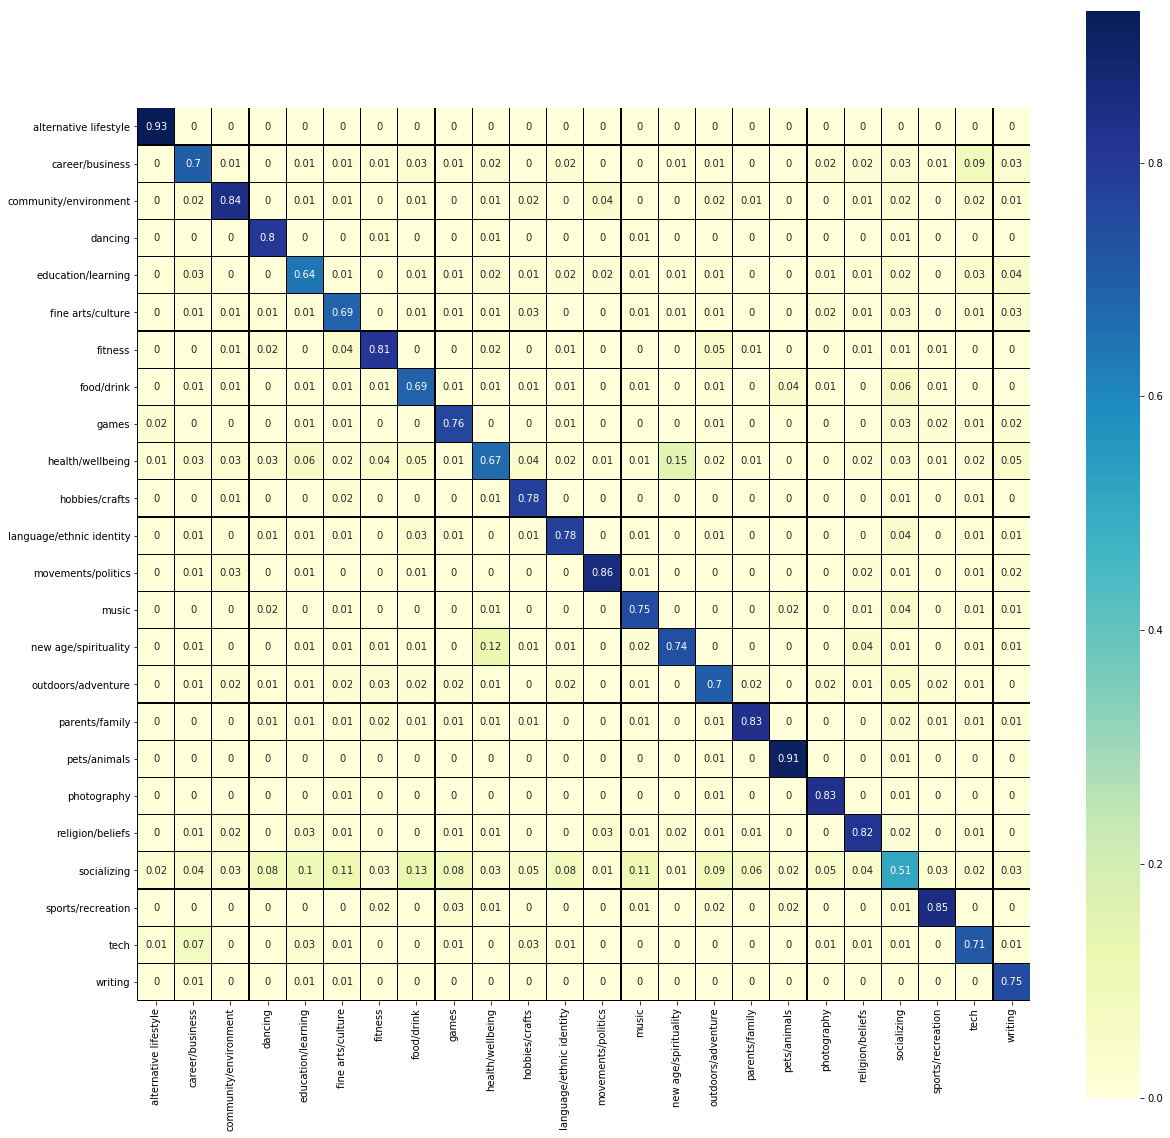

precision-way confusion matrix


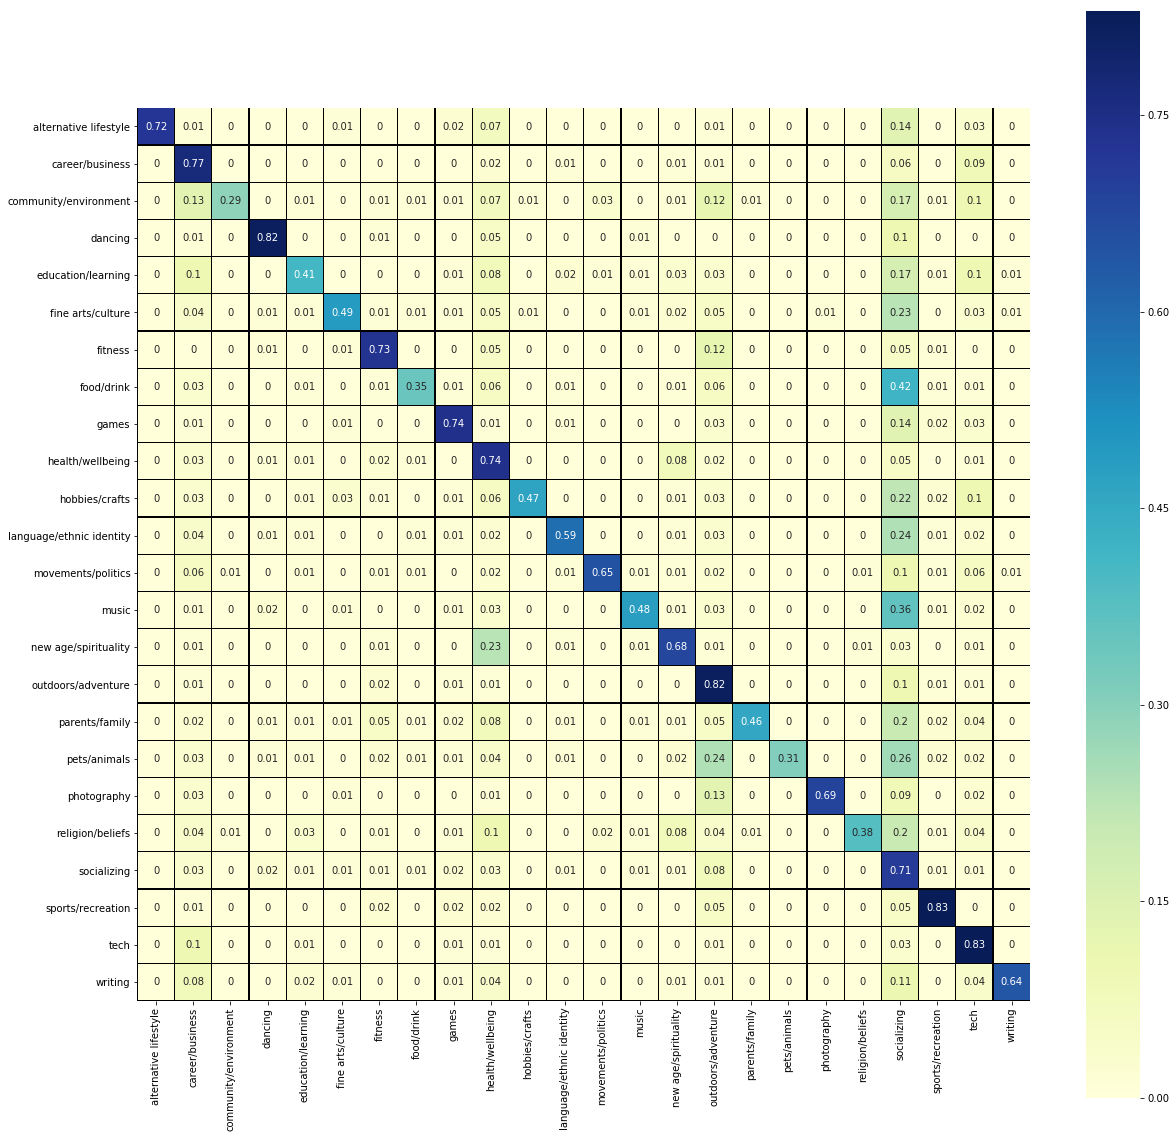

CPU times: user 32min 39s, sys: 8.53 s, total: 32min 47s
Wall time: 1min 20s


In [372]:
%%time 
#no classification report damnit
count_model_desc_stemm, score = run_experiment(df.desc_stemm, df.remap_category_label, 
               mode = "count", max_features=5000, 
               param_grid = None, print_classification_report = True, show_confusion_matrix = True, le = l,
               verbose = True, random_search=False, params = None)

extracting count-resulting features...
count-vect features shape:	(120809, 5000)
Classifying with Random Forest...
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=35, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)
Starting to fit


[Parallel(n_jobs=35)]: Using backend ThreadingBackend with 35 concurrent workers.
[Parallel(n_jobs=35)]: Done 100 out of 100 | elapsed:   57.8s finished
[Parallel(n_jobs=35)]: Using backend ThreadingBackend with 35 concurrent workers.


Scoring


[Parallel(n_jobs=35)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=35)]: Using backend ThreadingBackend with 35 concurrent workers.


Test score:	0.6918301465110505


[Parallel(n_jobs=35)]: Done 100 out of 100 | elapsed:    0.2s finished


                          precision    recall  f1-score   support

   alternative lifestyle      0.917     0.706     0.798       109
         career/business      0.708     0.772     0.739      2214
   community/environment      0.777     0.287     0.420       449
                 dancing      0.778     0.821     0.799       643
      education/learning      0.594     0.394     0.474       647
       fine arts/culture      0.674     0.490     0.567       537
                 fitness      0.797     0.734     0.764      1286
              food/drink      0.673     0.382     0.487       684
                   games      0.770     0.753     0.761       915
        health/wellbeing      0.656     0.730     0.691      2638
          hobbies/crafts      0.760     0.496     0.600       262
language/ethnic identity      0.776     0.587     0.668       854
      movements/politics      0.857     0.682     0.760       387
                   music      0.712     0.521     0.602       493
    new a

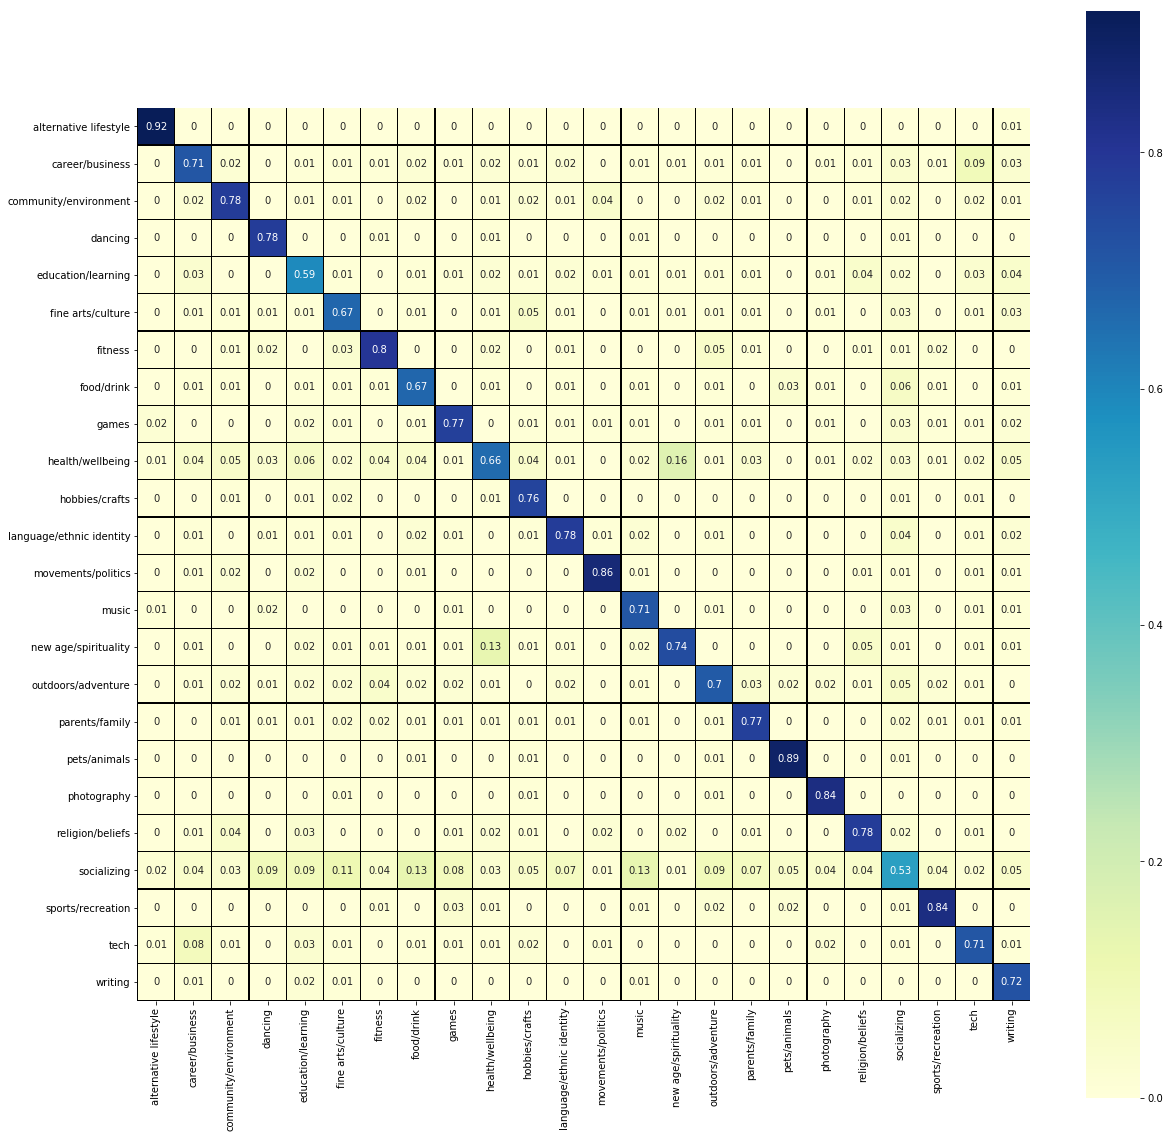

precision-way confusion matrix


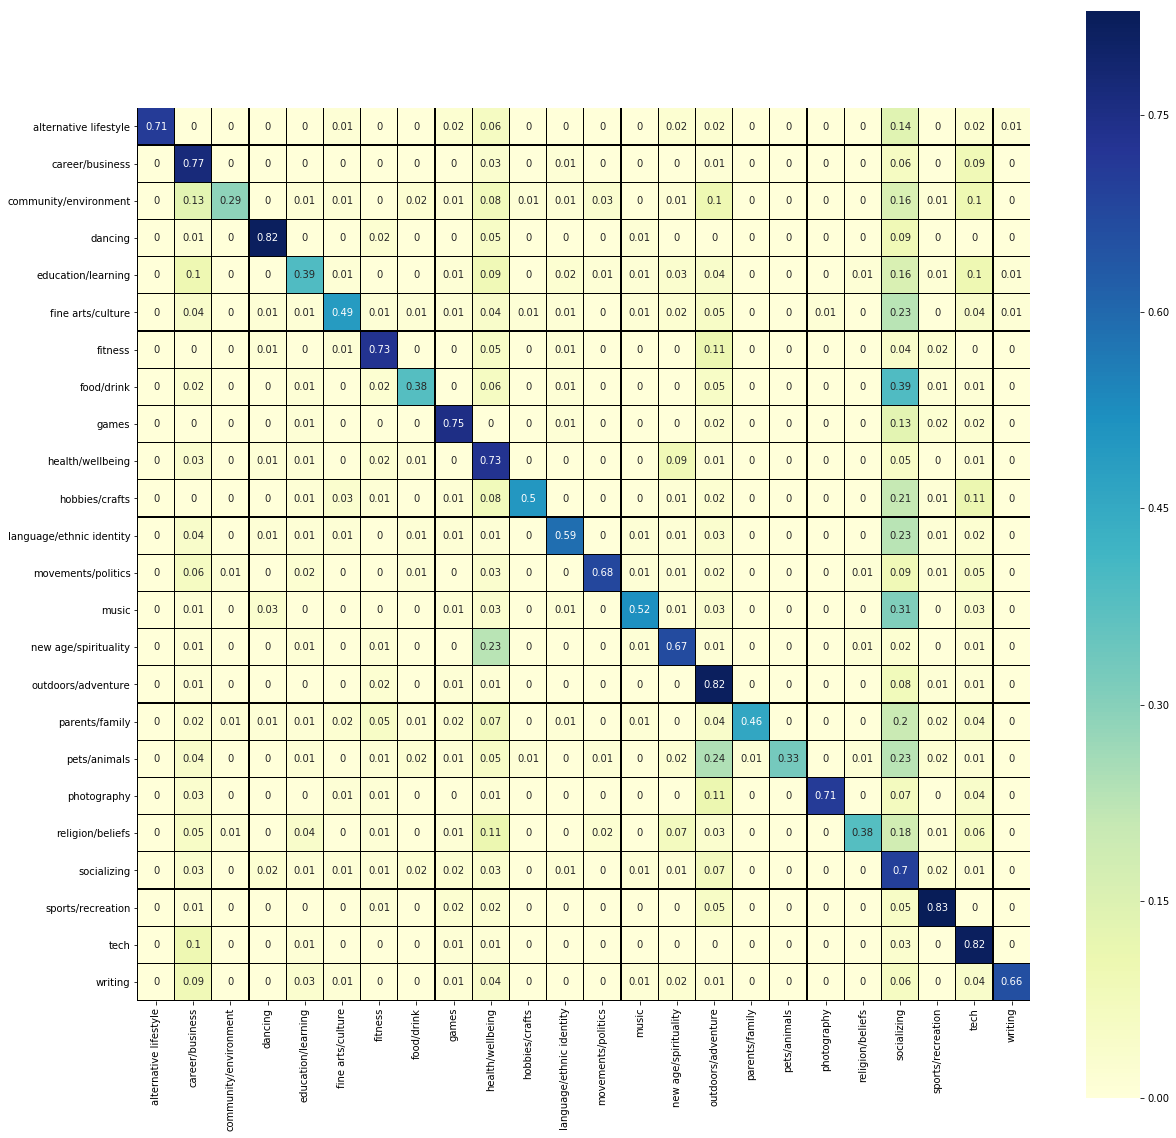

CPU times: user 31min 15s, sys: 9.17 s, total: 31min 24s
Wall time: 1min 16s


In [373]:
%%time
count_model_desc_stemm_no_badwords, score = run_experiment(df.desc_stemm_no_badwords, df.remap_category_label, 
               mode = "count", max_features=5000, 
               param_grid = None, print_classification_report = True, show_confusion_matrix = True, le = l,
            
                                                           
               verbose = True, random_search=False, params = None)

# Bigram Attempt TF-IDF

extracting tf-idf features...
tf-idf features shape:	(120809, 5000)
Classifying with Random Forest...
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=35, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)
Starting to fit


[Parallel(n_jobs=35)]: Using backend ThreadingBackend with 35 concurrent workers.
[Parallel(n_jobs=35)]: Done 100 out of 100 | elapsed:   56.4s finished
[Parallel(n_jobs=35)]: Using backend ThreadingBackend with 35 concurrent workers.


Scoring


[Parallel(n_jobs=35)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=35)]: Using backend ThreadingBackend with 35 concurrent workers.


Test score:	0.6922854068371823


[Parallel(n_jobs=35)]: Done 100 out of 100 | elapsed:    0.2s finished


                          precision    recall  f1-score   support

   alternative lifestyle      0.951     0.716     0.817       109
         career/business      0.723     0.768     0.745      2214
   community/environment      0.813     0.310     0.448       449
                 dancing      0.802     0.809     0.806       643
      education/learning      0.614     0.399     0.484       647
       fine arts/culture      0.671     0.512     0.581       537
                 fitness      0.800     0.723     0.760      1286
              food/drink      0.671     0.361     0.470       684
                   games      0.762     0.757     0.760       915
        health/wellbeing      0.665     0.732     0.697      2638
          hobbies/crafts      0.799     0.485     0.603       262
language/ethnic identity      0.795     0.587     0.675       854
      movements/politics      0.825     0.695     0.755       387
                   music      0.734     0.531     0.616       493
    new a

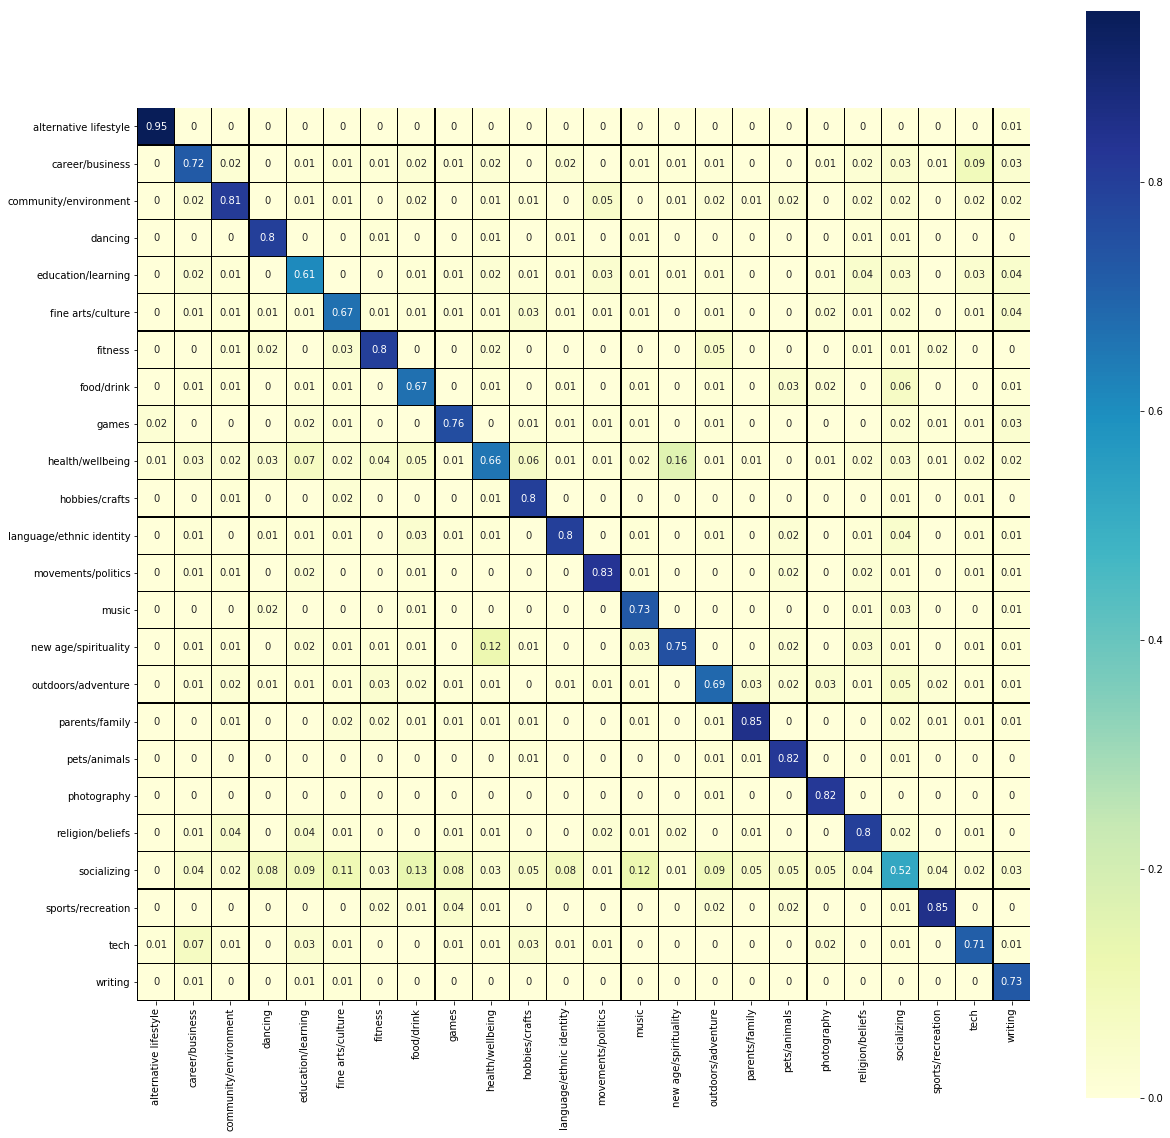

precision-way confusion matrix


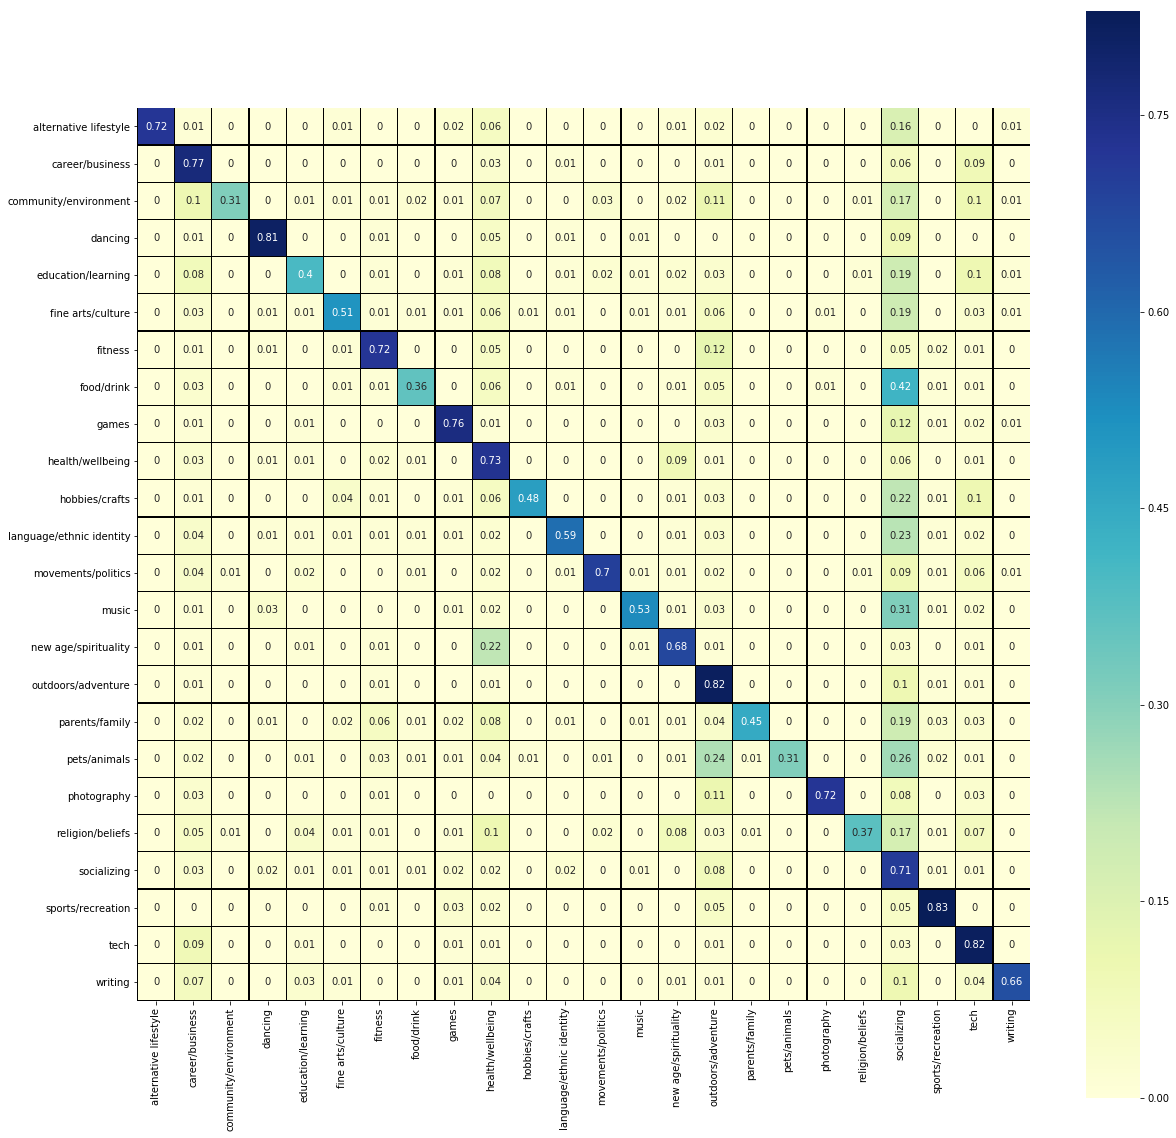

CPU times: user 31min 58s, sys: 12.8 s, total: 32min 11s
Wall time: 2min 38s


In [363]:
%%time
count_model_desc_stemm_no_badwords, score = run_experiment(df.desc_stemm_no_badwords, df.remap_category_label, 
               mode = "tfidf", max_features=5000, ngram_range = (1,3),
               param_grid = None, print_classification_report = True, show_confusion_matrix = True, le = l,
            
                                                           
               verbose = True, random_search=False, params = None)

extracting count-resulting features...
count-vect features shape:	(120809, 5000)
Classifying with Random Forest...
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=35, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)
Starting to fit


[Parallel(n_jobs=35)]: Using backend ThreadingBackend with 35 concurrent workers.
[Parallel(n_jobs=35)]: Done 100 out of 100 | elapsed:   59.1s finished


Scoring


[Parallel(n_jobs=35)]: Using backend ThreadingBackend with 35 concurrent workers.
[Parallel(n_jobs=35)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=35)]: Using backend ThreadingBackend with 35 concurrent workers.


Test score:	0.694230610048837


[Parallel(n_jobs=35)]: Done 100 out of 100 | elapsed:    0.2s finished


                          precision    recall  f1-score   support

   alternative lifestyle      0.929     0.716     0.808       109
         career/business      0.717     0.768     0.742      2214
   community/environment      0.778     0.305     0.438       449
                 dancing      0.800     0.829     0.814       643
      education/learning      0.606     0.397     0.480       647
       fine arts/culture      0.681     0.505     0.580       537
                 fitness      0.797     0.731     0.763      1286
              food/drink      0.676     0.370     0.478       684
                   games      0.756     0.756     0.756       915
        health/wellbeing      0.667     0.735     0.699      2638
          hobbies/crafts      0.726     0.496     0.590       262
language/ethnic identity      0.778     0.602     0.679       854
      movements/politics      0.855     0.687     0.762       387
                   music      0.703     0.558     0.622       493
    new a

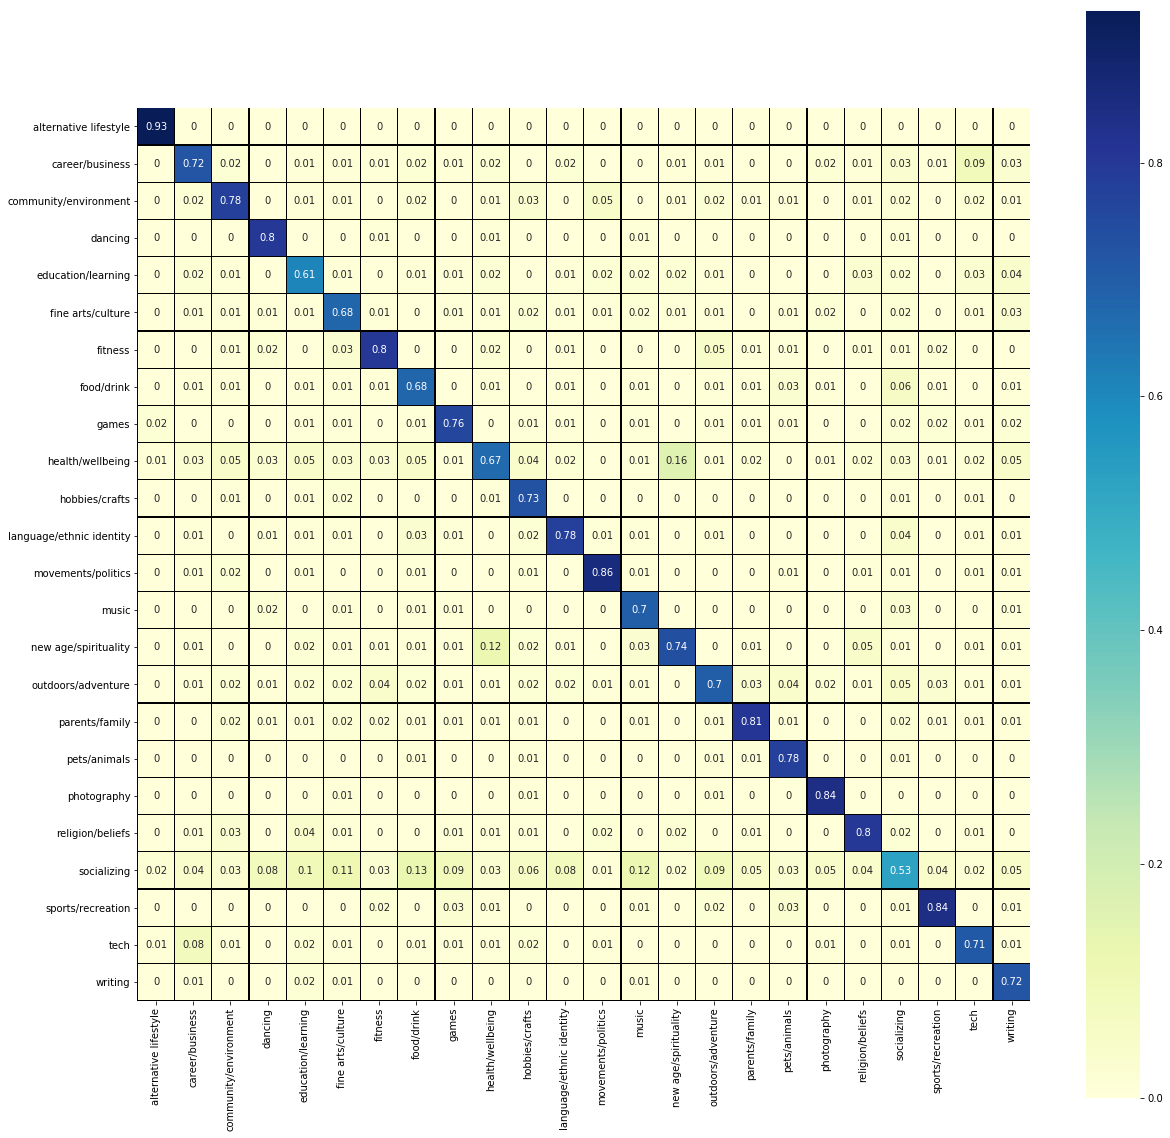

precision-way confusion matrix


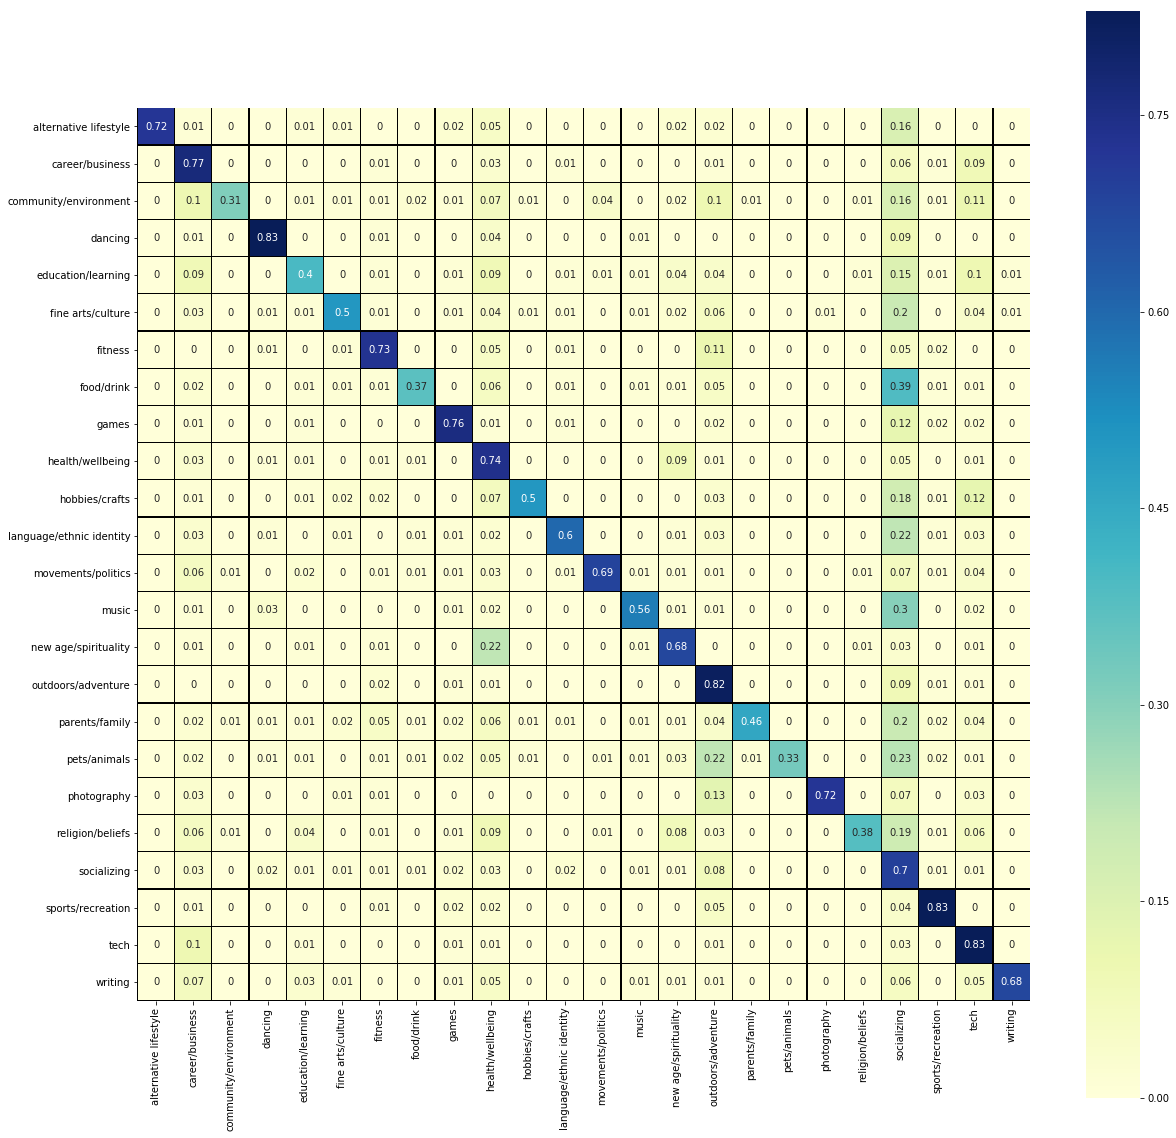

CPU times: user 34min 51s, sys: 19.9 s, total: 35min 11s
Wall time: 4min 36s


In [364]:
%%time
count_model_desc_stemm_no_badwords, score = run_experiment(df.desc_stemm_no_badwords, df.remap_category_label, 
               mode = "count", max_features=5000, ngram_range = (1,5),
               param_grid = None, print_classification_report = True, show_confusion_matrix = True, le = l,
            
                                                           
               verbose = True, random_search=False, params = None)